In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [1]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

Failed to load image Python extension: /mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
2025-02-14 22:00:22.594151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739566822.697661 2112627 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739566822.729144 2112627 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 22:00:23.221388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operatio

## Setup imports

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import monai
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader, NibabelReader, decollate_batch
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, RandAffined, CastToTyped
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to load image Python extension: /mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
2025-02-17 20:56:46.036427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739822206.159872 3886469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739822206.196901 3886469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one 

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.12.0+cu102
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")
training_dir_sphere = os.path.join(root_dir, "masks_training_sphere")
testing_dir_sphere = os.path.join(root_dir, "masks_testing_sphere")
training_dir_sphere_2 = os.path.join(root_dir, "masks_training_sphere_2")
testing_dir_sphere_2 = os.path.join(root_dir, "masks_testing_sphere_2")
training_dir_sphere_3 = os.path.join(root_dir, "masks_training_dilation")
testing_dir_sphere_3 = os.path.join(root_dir, "masks_testing_dilation")
training_dir_elongated = os.path.join(root_dir, "training_deformation_prueba")
testing_dir_elongated = os.path.join(root_dir, "testing_deformation_prueba")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"
assert os.path.exists(training_dir_sphere), f"El directorio {training_dir_sphere} no existe"
assert os.path.exists(testing_dir_sphere), f"El directorio {testing_dir_sphere} no existe"
assert os.path.exists(training_dir_sphere_2), f"El directorio {training_dir_sphere_2} no existe"
assert os.path.exists(testing_dir_sphere_2), f"El directorio {testing_dir_sphere_2} no existe"
assert os.path.exists(training_dir_sphere_3), f"El directorio {training_dir_sphere_3} no existe"
assert os.path.exists(testing_dir_sphere_3), f"El directorio {testing_dir_sphere_3} no existe"
assert os.path.exists(training_dir_elongated), f"El directorio {training_dir_elongated} no existe"
assert os.path.exists(testing_dir_elongated), f"El directorio {testing_dir_elongated} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)
training_files_sphere = list_nifti_files(training_dir_sphere)
testing_files_sphere = list_nifti_files(testing_dir_sphere)
training_files_sphere_2 = list_nifti_files(training_dir_sphere_2)
testing_files_sphere_2 = list_nifti_files(testing_dir_sphere_2)
training_files_sphere_3 = list_nifti_files(training_dir_sphere_3)
testing_files_sphere_3 = list_nifti_files(testing_dir_sphere_3)
training_files_elongated = list_nifti_files(training_dir_elongated)
testing_files_elongated = list_nifti_files(testing_dir_elongated)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")
print(f"Se encontraron {len(training_files_sphere)} archivos en {training_files_sphere}")
print(f"Se encontraron {len(testing_files_sphere)} archivos en {testing_dir_sphere}")
print(f"Se encontraron {len(training_files_sphere_2)} archivos en {training_files_sphere_2}")
print(f"Se encontraron {len(testing_files_sphere_2)} archivos en {testing_dir_sphere_2}")
print(f"Se encontraron {len(training_files_sphere_3)} archivos en {training_files_sphere_3}")
print(f"Se encontraron {len(testing_files_sphere_3)} archivos en {testing_dir_sphere_3}")
print(f"Se encontraron {len(training_files_elongated)} archivos en {training_files_elongated}")
print(f"Se encontraron {len(testing_files_elongated)} archivos en {testing_files_elongated}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


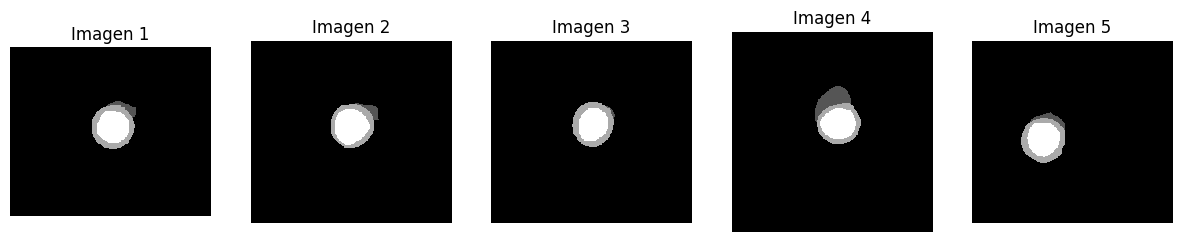

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


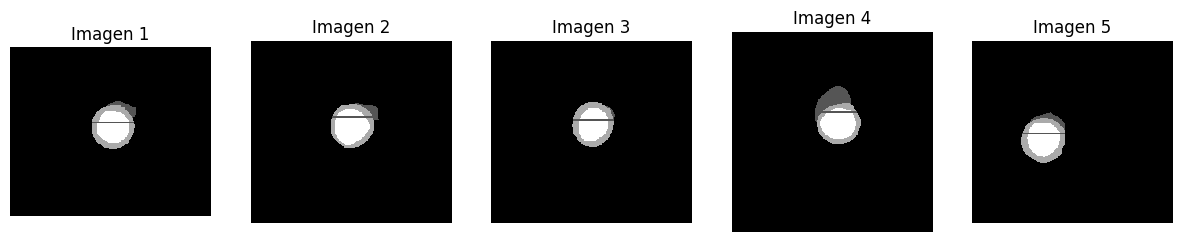

In [7]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


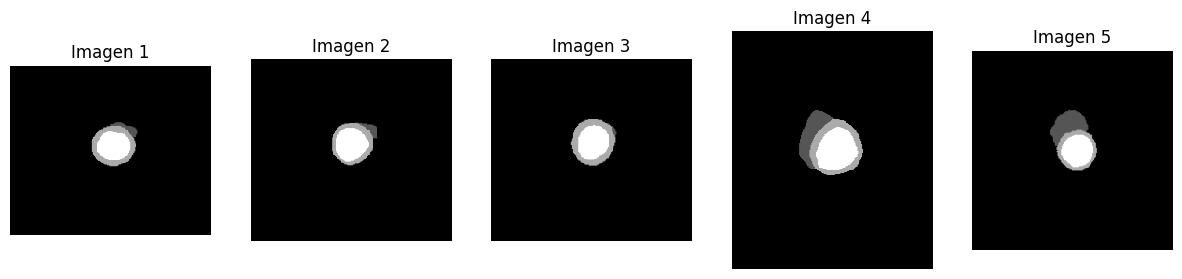

In [8]:
images_noise_elongated = [nib.load(file).get_fdata() for file in training_files_elongated[:5]] 
fig, axs = plt.subplots(1, len(images_noise_elongated), figsize=(15, 5))

for i, img in enumerate(images_noise_elongated):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


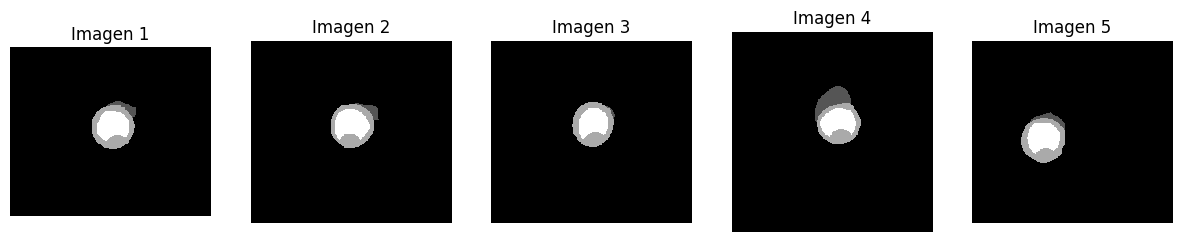

In [9]:
images_sphere = [nib.load(file).get_fdata() for file in training_files_sphere[:5]] 
fig, axs = plt.subplots(1, len(images_sphere), figsize=(15, 5))

for i, img in enumerate(images_sphere):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


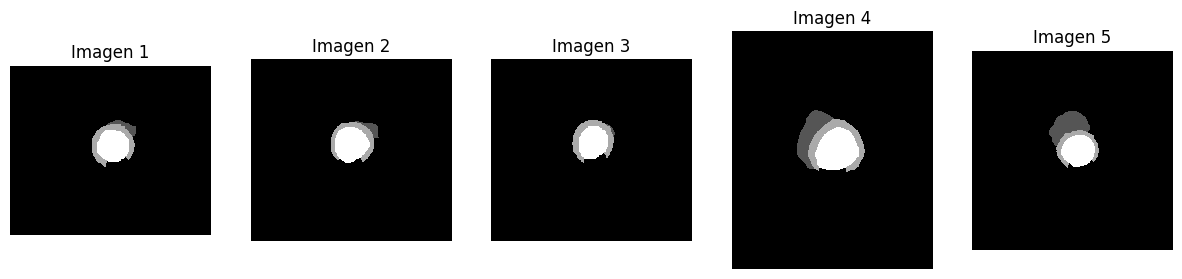

In [10]:
images_sphere_2 = [nib.load(file).get_fdata() for file in training_files_sphere_2[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_2), figsize=(15, 5))

for i, img in enumerate(images_sphere_2):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


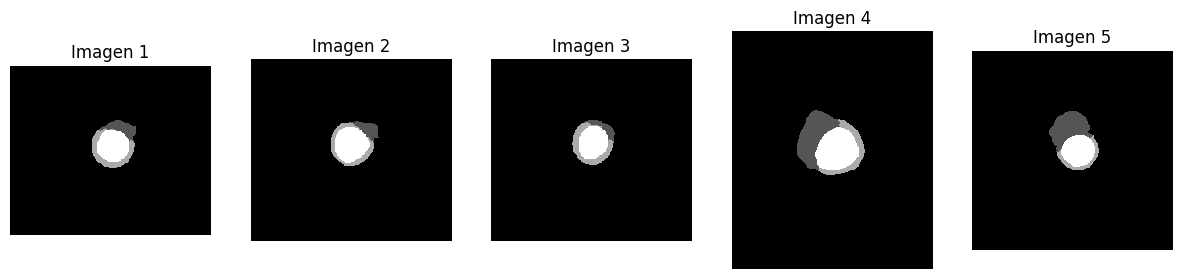

In [11]:
images_sphere_3 = [nib.load(file).get_fdata() for file in training_files_sphere_3[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_3), figsize=(15, 5))

for i, img in enumerate(images_sphere_3):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [12]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise
all_files_sphere = training_files_sphere + testing_files_sphere
all_files_sphere_2 = training_files_sphere_2 + testing_files_sphere_2
all_files_sphere_3 = training_files_sphere_3 + testing_files_sphere_3

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
images_sphere = [nib.load(file).get_fdata() for file in all_files_sphere]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
image_shapes_sphere = [img.shape for img in images_sphere]
image_shapes_sphere_2 = [img.shape for img in images_sphere_2]
image_shapes_sphere_3 = [img.shape for img in images_sphere_3]
images_shapes_elongated = [img.shape for img in images_noise_elongated]

print(image_shapes)
print(image_shapes_noise)
print(image_shapes_sphere)
print(image_shapes_sphere_2)
print(image_shapes_sphere_3)
print(images_shapes_elongated)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
average_shape_sphere = np.mean(image_shapes_sphere, axis=0).astype(int)
average_shape_sphere_2 = np.mean(image_shapes_sphere_2, axis=0).astype(int)
average_shape_sphere_3 = np.mean(image_shapes_sphere_3, axis=0).astype(int)
average_shape_elongated = np.mean(images_shapes_elongated, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_2}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_3}")
print(f"Tamaño promedio de las imágenes con deformación: {average_shape_elongated}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)
min_shape_sphere = np.min(image_shapes_sphere, axis=0)
max_shape_sphere = np.max(image_shapes_sphere, axis=0)
min_shape_sphere_2 = np.min(image_shapes_sphere_2, axis=0)
max_shape_sphere_2 = np.max(image_shapes_sphere_2, axis=0)
min_shape_sphere_3 = np.min(image_shapes_sphere_3, axis=0)
max_shape_sphere_3 = np.max(image_shapes_sphere_3, axis=0)
min_shape_elongated = np.min(images_shapes_elongated, axis=0)
max_shape_elongated = np.max(images_shapes_elongated, axis=0)

print(f"Tamaño mínimo -original: {min_shape}")
print(f"Tamaño máximo -original: {max_shape}")
print(f"Tamaño mínimo -line: {min_shape_noise}")
print(f"Tamaño máximo -line: {max_shape_noise}")
print(f"Tamaño mínimo -sphere: {min_shape_sphere}")
print(f"Tamaño máximo -sphere: {max_shape_sphere}")
print(f"Tamaño mínimo -sphere_2: {min_shape_sphere_2}")
print(f"Tamaño máximo -sphere_2: {max_shape_sphere_2}")
print(f"Tamaño mínimo -dilation: {min_shape_sphere_3}")
print(f"Tamaño máximo -dilation: {max_shape_sphere_3}")
print(f"Tamaño mínimo -elongation: {min_shape_elongated}")
print(f"Tamaño máximo -elongation: {max_shape_elongated}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

In [13]:
images_train = [nib.load(file).get_fdata() for file in training_files]
images_test = [nib.load(file).get_fdata() for file in testing_files]
image_shapes_train = [img.shape for img in images_train]
image_shapes_test = [img.shape for img in images_test]
print(image_shapes_train)
print(image_shapes_test)

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [14]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

In [ ]:
preprocess_list1 = [
    transforms.LoadImaged(keys=["image"], reader=NibabelReader()),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"], track_meta=True),
    # transforms.Orientationd(keys=["image"], axcodes="LPS"),
    transforms.Spacingd(keys=["image"], pixdim=(1.52344, 1.52344, 5), mode='nearest'), # pixdim=(1.52344, 1.52344, 10.0)
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
]

training_data_aug = [
    transforms.RandFlipd(keys=["image"], spatial_axis=0, prob=0.5),
    transforms.RandFlipd(keys=["image"], spatial_axis=1, prob=0.5),
    transforms.RandFlipd(keys=["image"], spatial_axis=2, prob=0.5),
    transforms.RandAffined(keys=["image"], mode="nearest", scale_range=(0, 0.2, 0.2),
                        rotate_range=(1.0, 0, 0), padding_mode="zeros", prob=7.0),
    
]

preprocess_list2 = [
    transforms.CropForegroundd(keys=["image"], source_key="image", allow_smaller=False),
    transforms.SpatialPadd(keys=["image"], spatial_size=(24, 128, 128)),
    transforms.Resized(keys=["image"], spatial_size=(24, None, None), mode="nearest"),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
]

all_transforms = transforms.Compose(preprocess_list1 + training_data_aug + preprocess_list2)
validation_transforms = transforms.Compose(preprocess_list1 + preprocess_list2)

postprocessing_training = transforms.Compose([
    transforms.AsDiscreted(keys=["pred"], argmax=True),
    transforms.EnsureTyped(keys=["pred"], dtype=int),
    transforms.Invertd(keys=["pred"], transform=all_transforms, orig_keys="image"),
    transforms.SaveImaged(keys=["pred"], 
                          meta_keys=["image_meta_data"], 
                          output_dir="reconstructed_masks_testing", 
                          output_postfix="reconstructed", 
                          output_ext=".nii.gz",
                          data_root_dir=root_dir,
                          separate_folder=False),
])

postprocessing_testing = transforms.Compose([
    transforms.AsDiscreted(keys=["pred"], argmax=True),
    transforms.EnsureTyped(keys=["pred"], dtype=int),
    transforms.Invertd(keys=["pred"], transform=validation_transforms, orig_keys="image"),
    transforms.SaveImaged(keys=["pred"], 
                          meta_keys=["image_meta_data"], 
                          output_dir="reconstructed_masks_testing", 
                          output_postfix="reconstructed", 
                          output_ext=".nii.gz",
                          data_root_dir=root_dir,
                          separate_folder=False),
])

In [17]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [18]:
val_data_dicts = [{"image": file} for file in testing_files][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [19]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_noise)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [20]:
val_data_dicts_noise = [{"image": file} for file in testing_files_noise][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts_noise)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [21]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [22]:
val_data_dicts_sphere = [{"image": file} for file in testing_files_sphere][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts_sphere)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [23]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_2)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [24]:
val_data_dicts_sphere_2 = [{"image": file} for file in testing_files_sphere_2][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts_sphere_2)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [25]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_3)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [26]:
val_data_dicts_sphere_3 = [{"image": file} for file in testing_files_sphere_3][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts_sphere_3)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [27]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 24, 128, 128])

In [28]:
val_data_dicts_elongated= [{"image": file} for file in testing_files_elongated][0:1]
transform = Compose(validation_transforms)
transform(val_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 24, 128, 128])

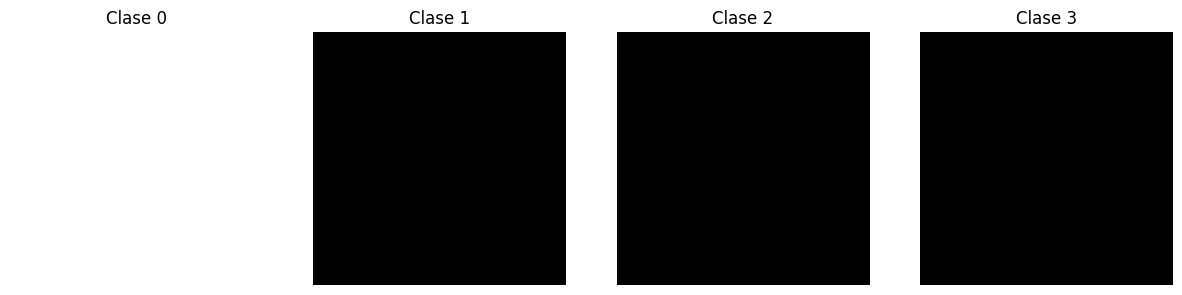

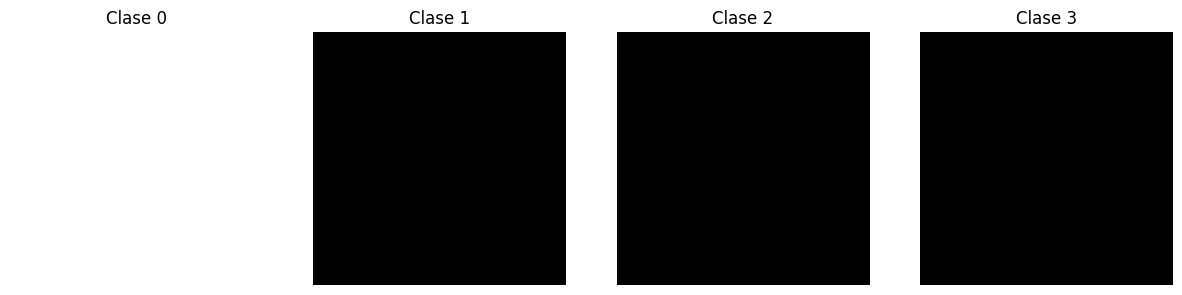

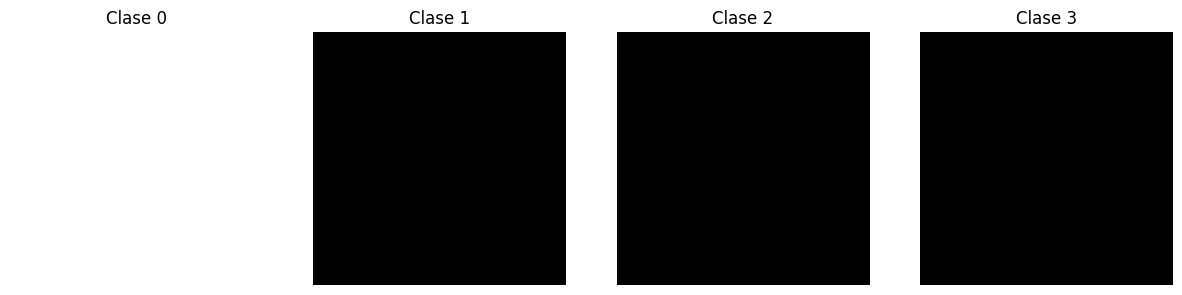

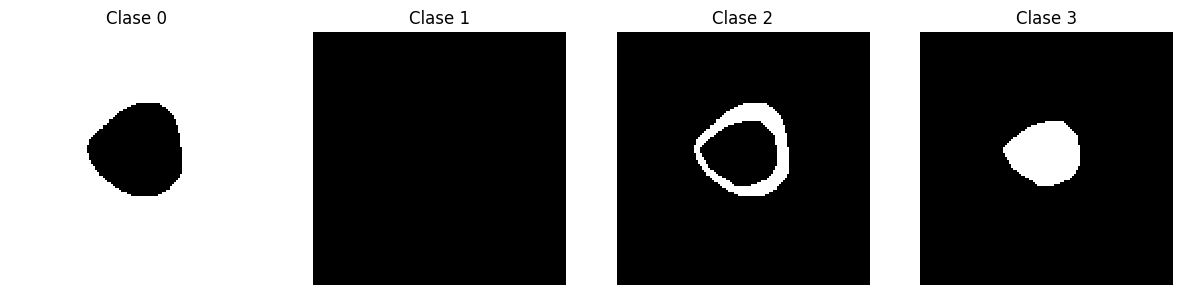

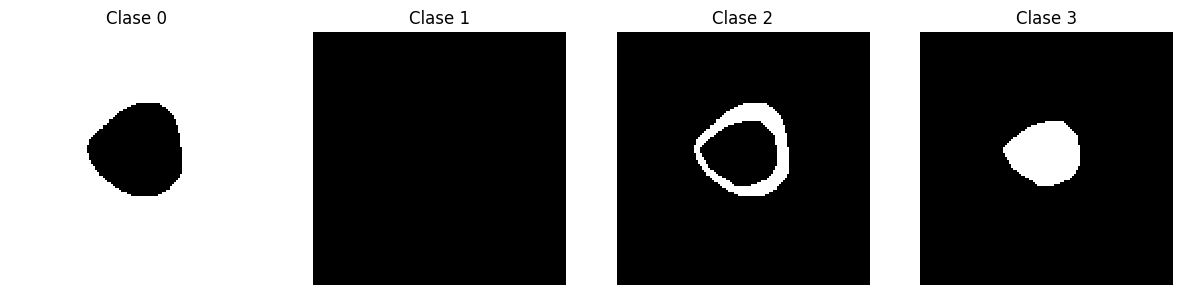

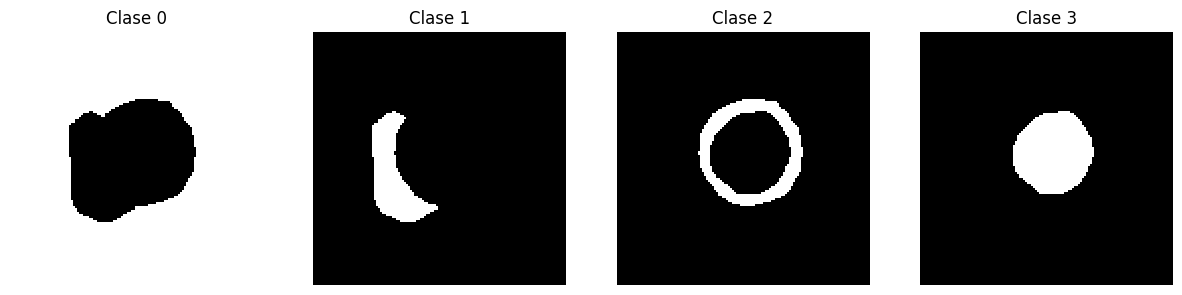

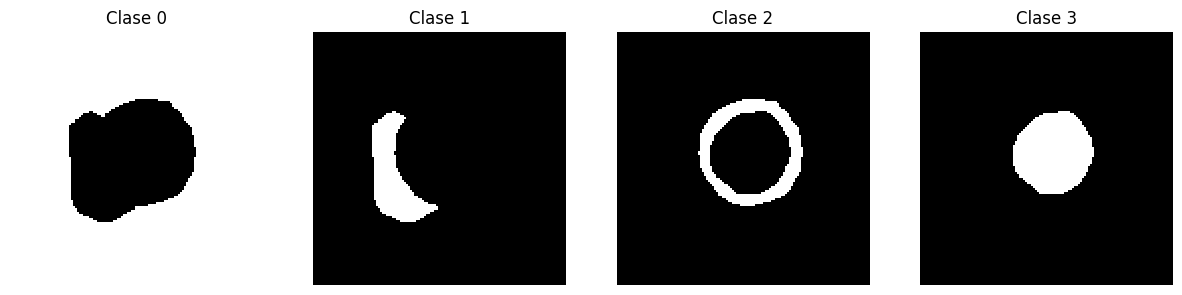

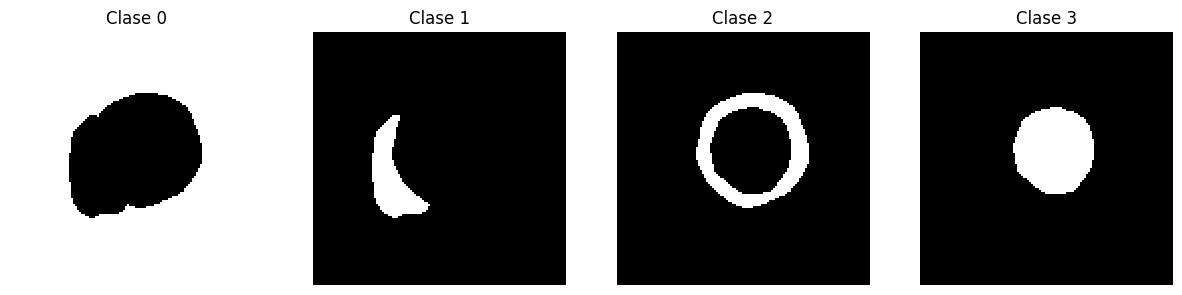

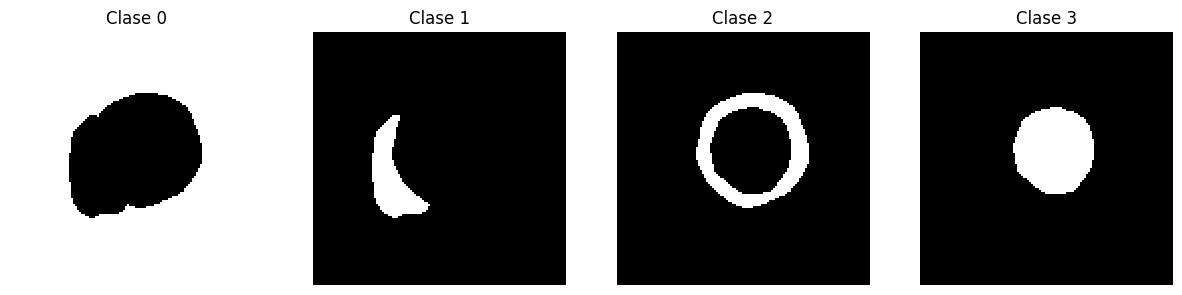

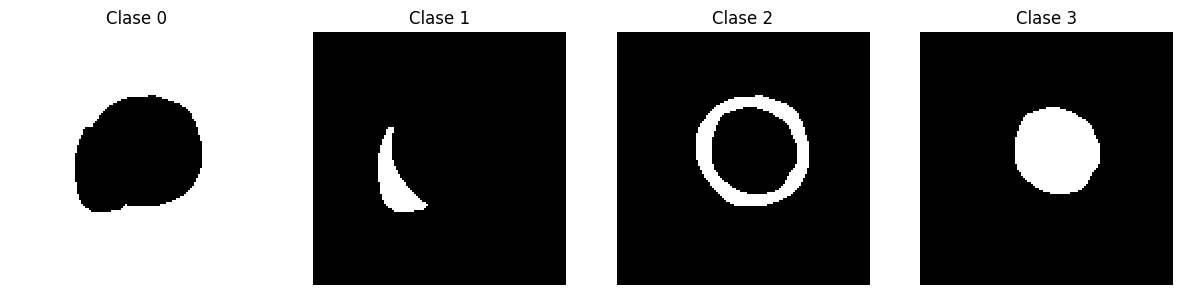

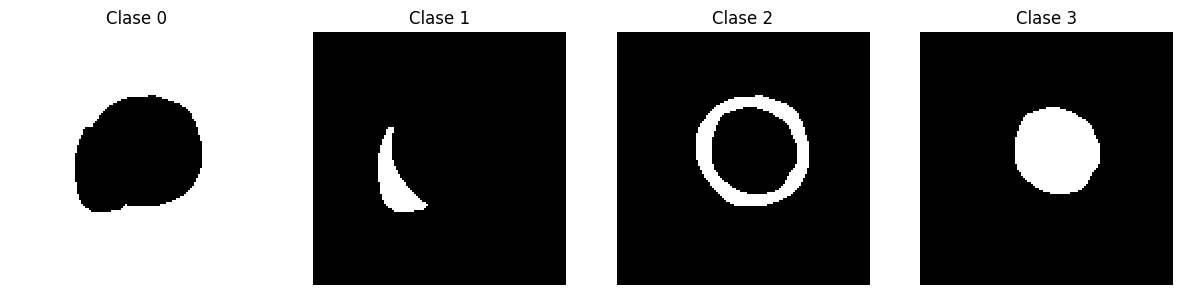

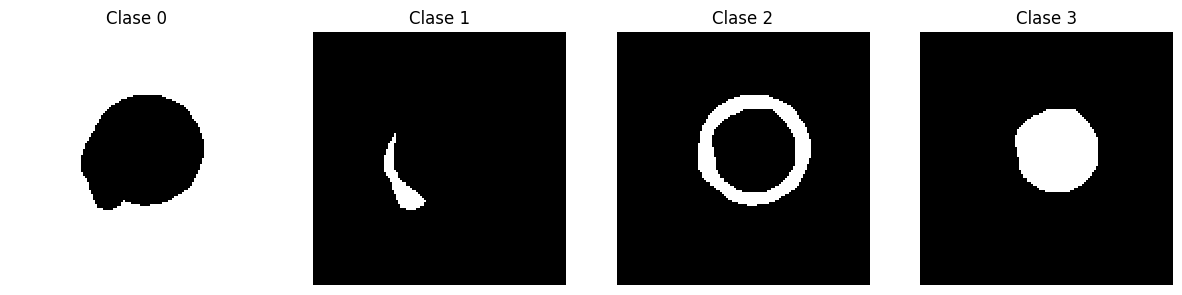

In [29]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

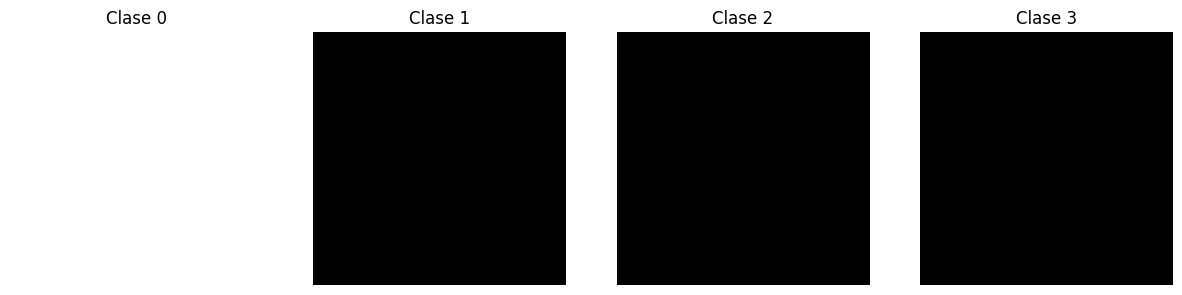

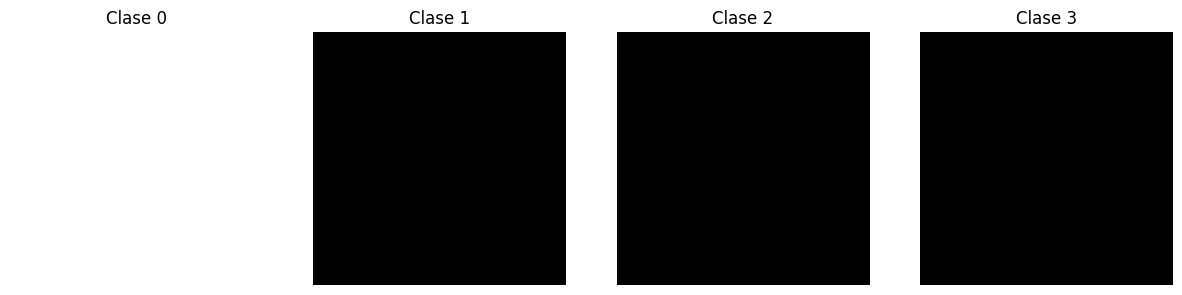

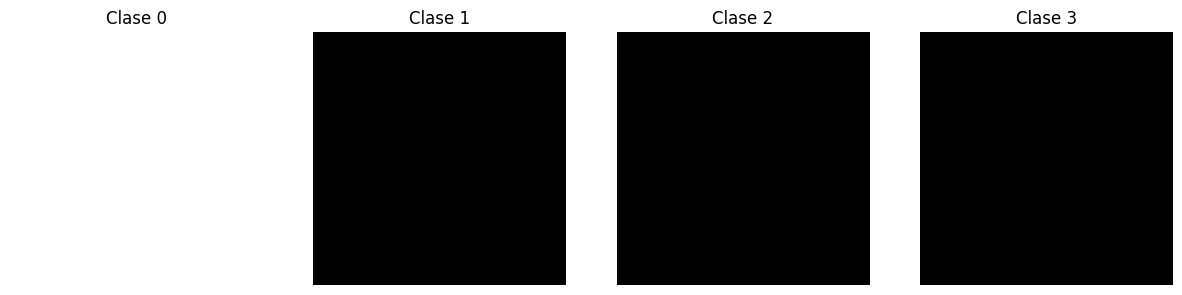

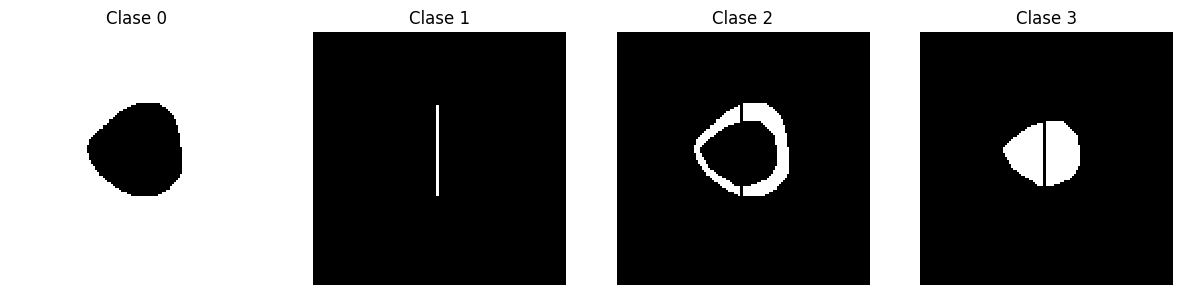

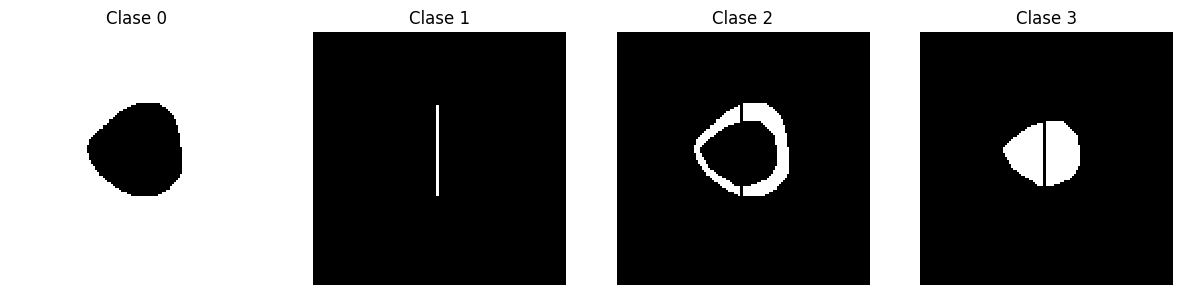

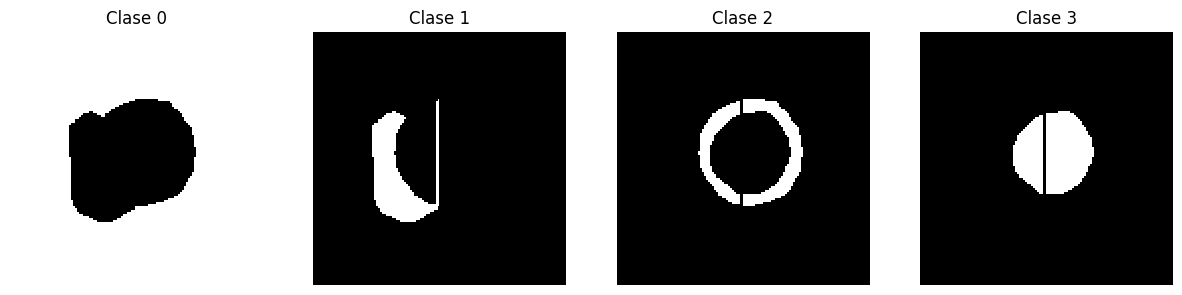

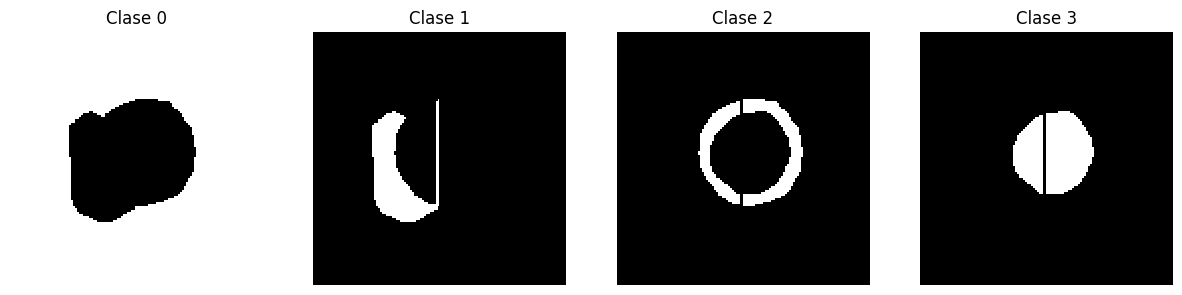

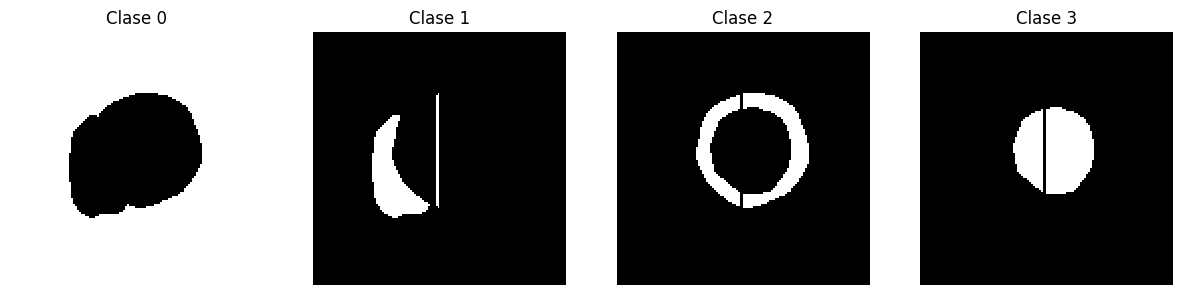

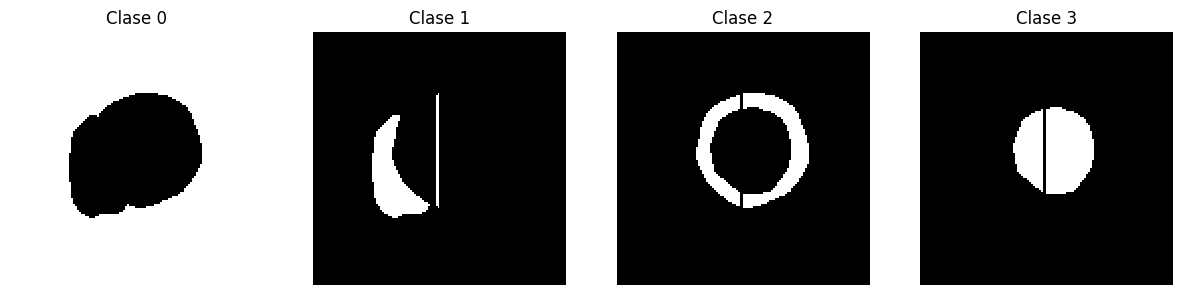

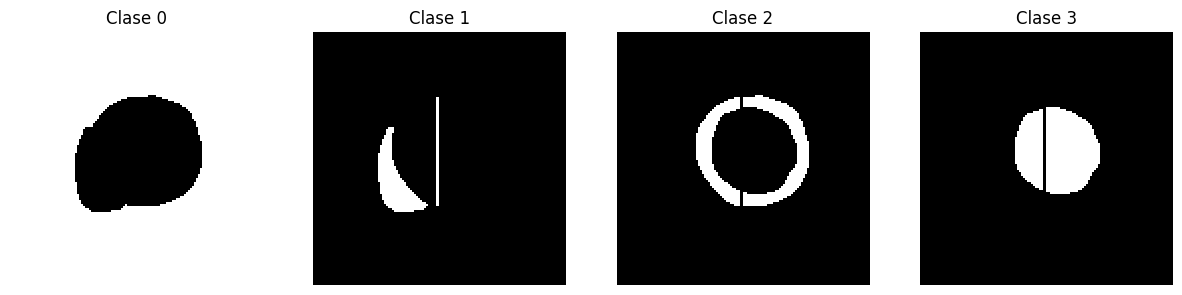

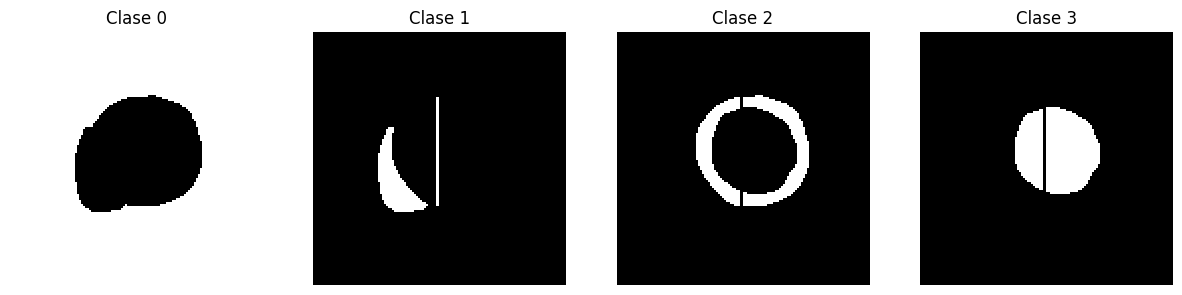

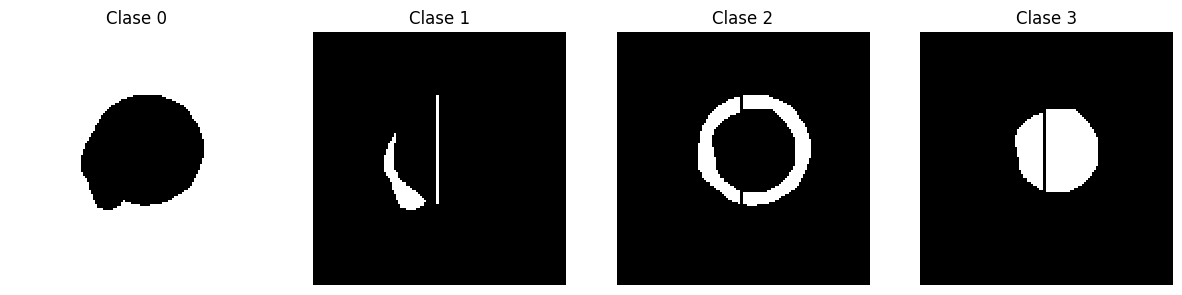

In [30]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

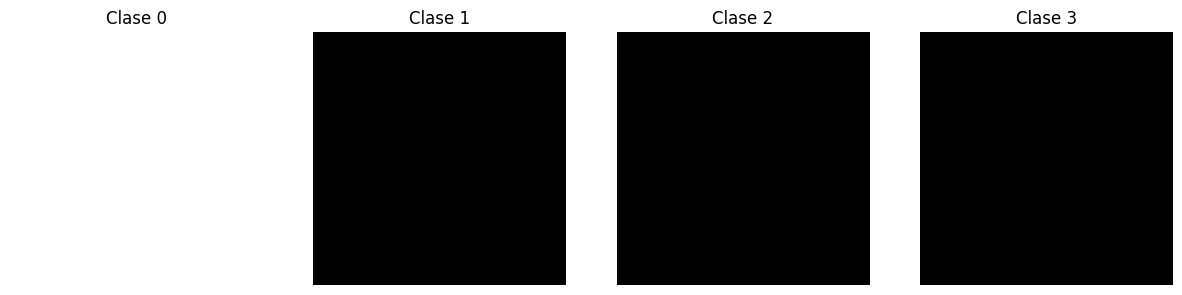

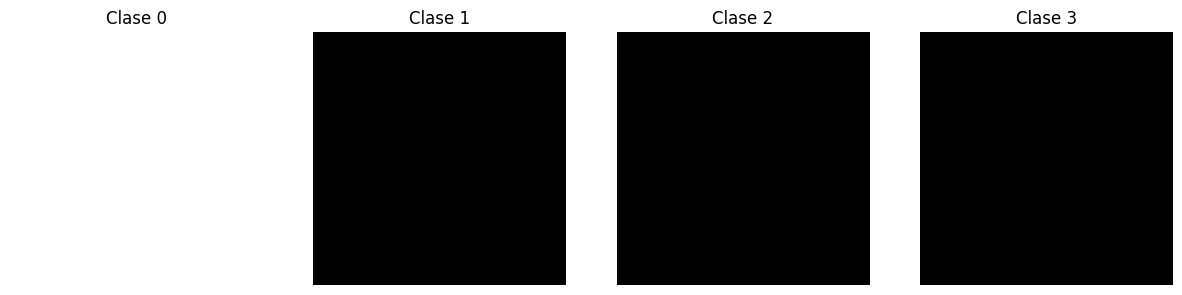

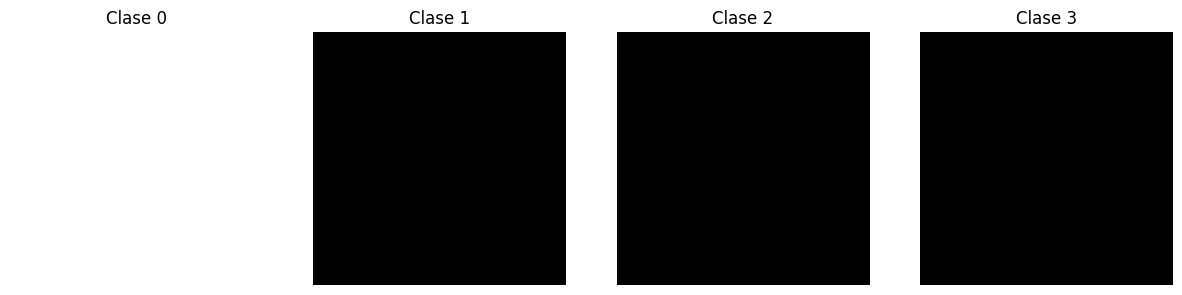

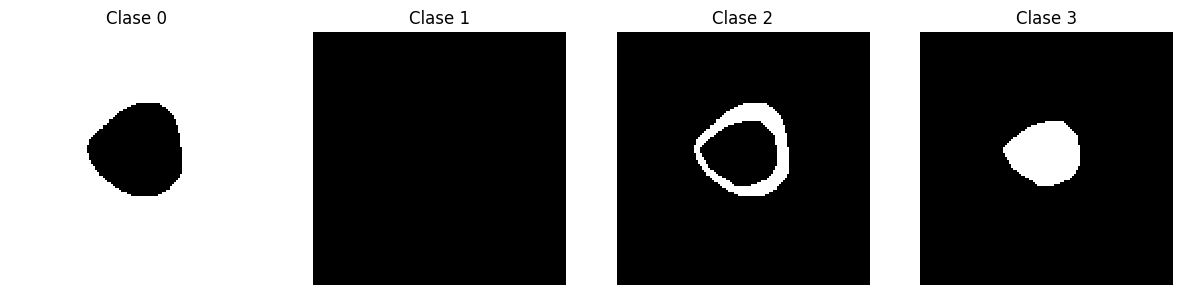

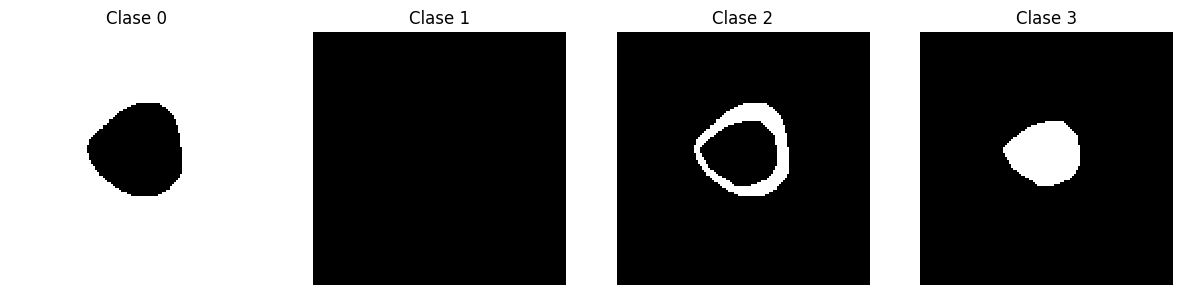

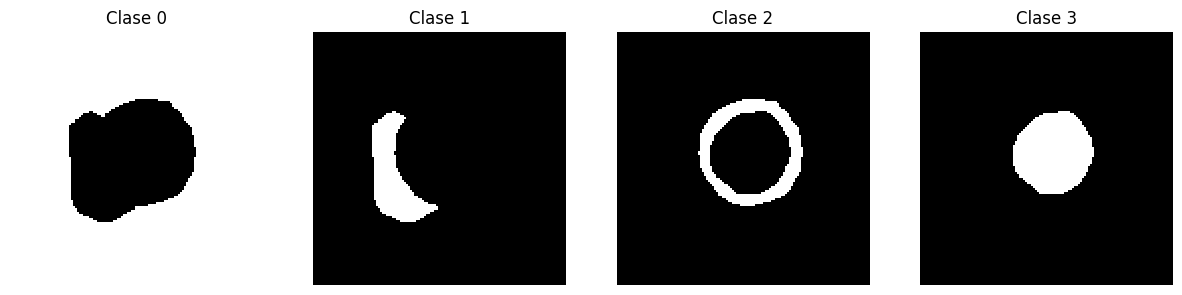

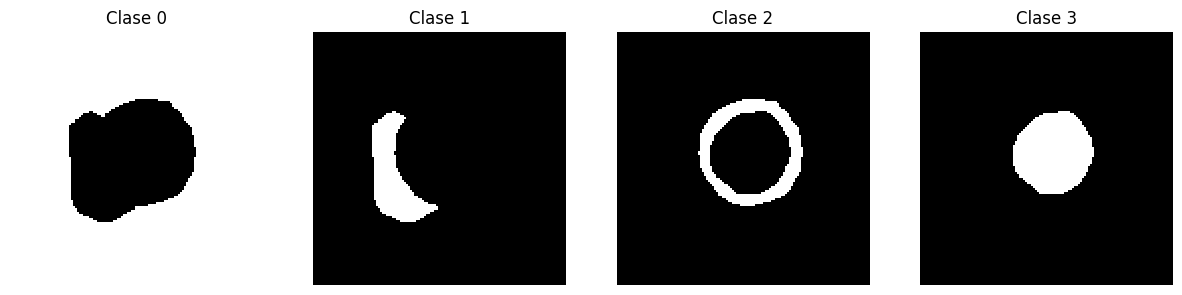

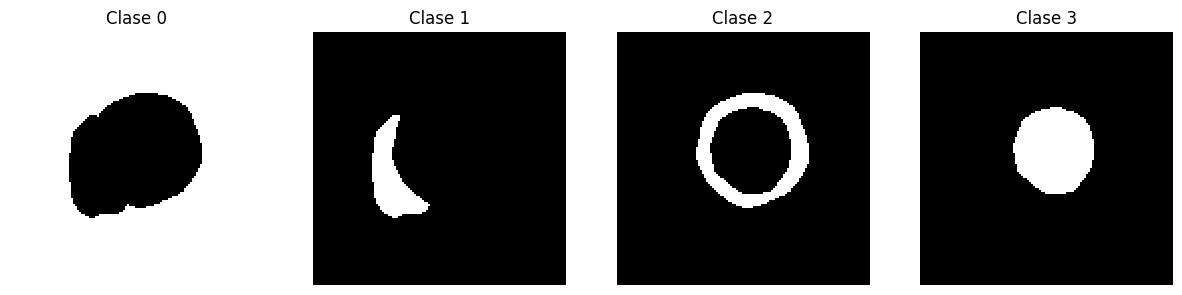

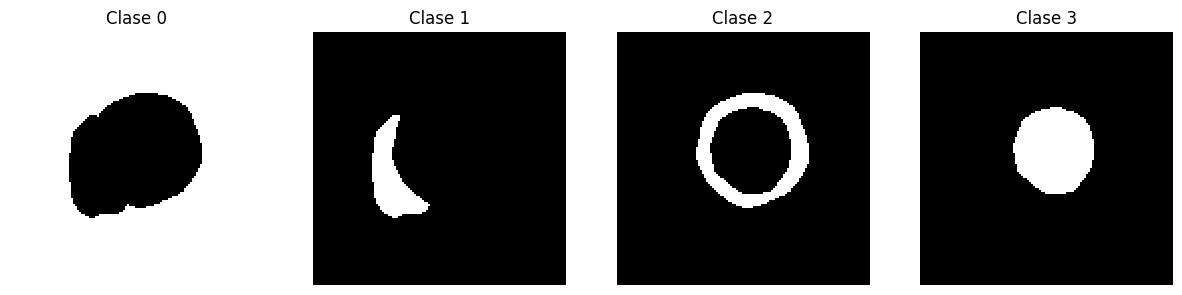

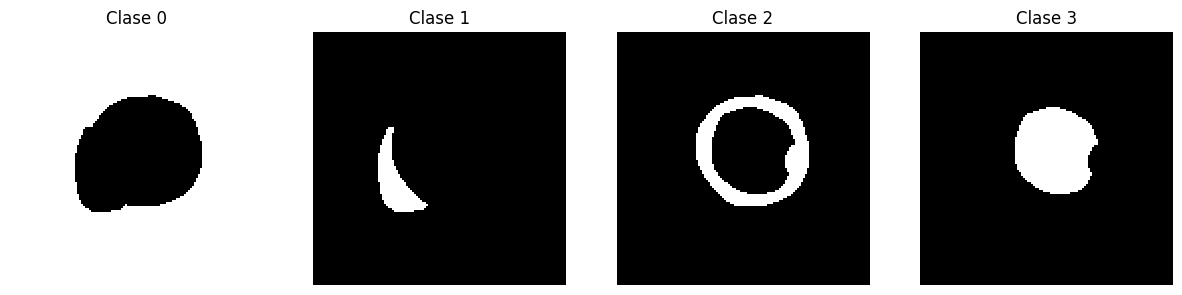

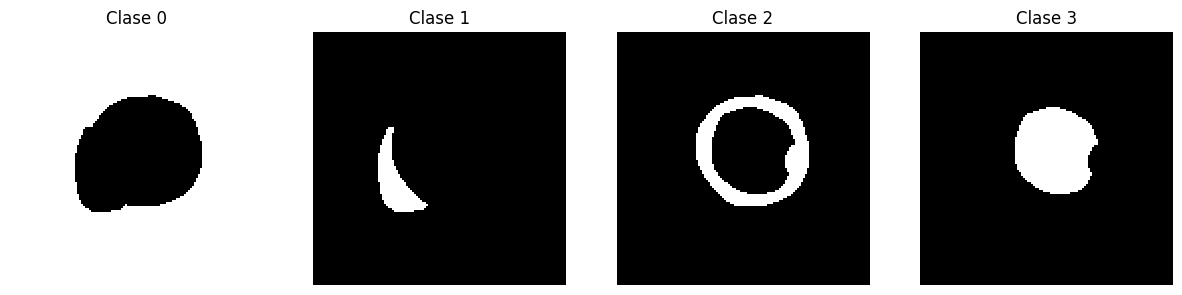

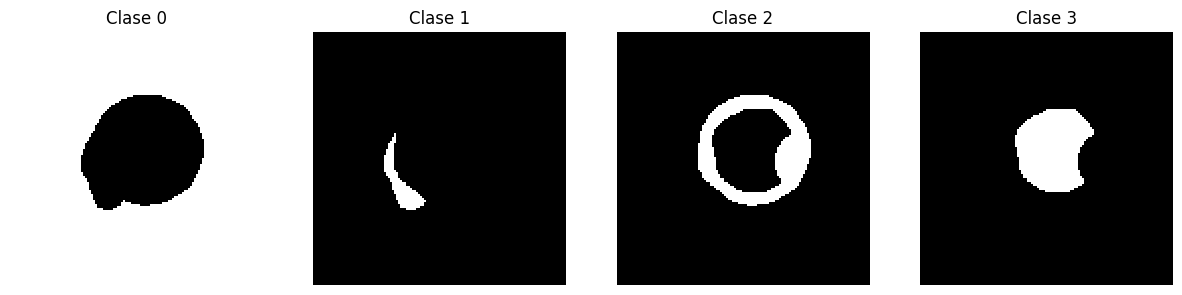

In [31]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

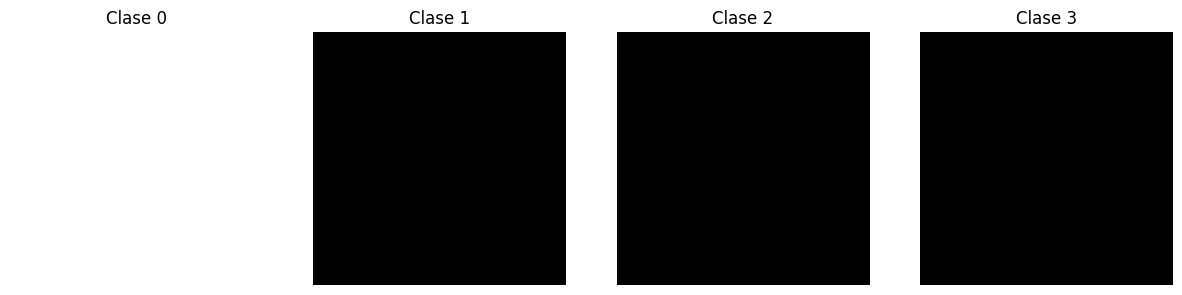

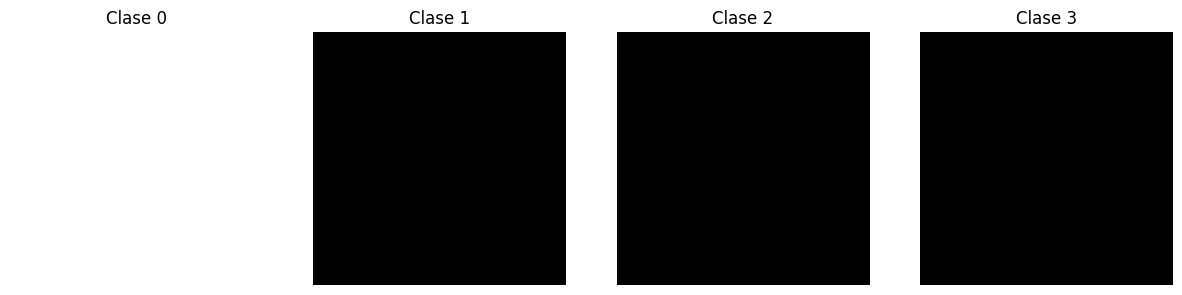

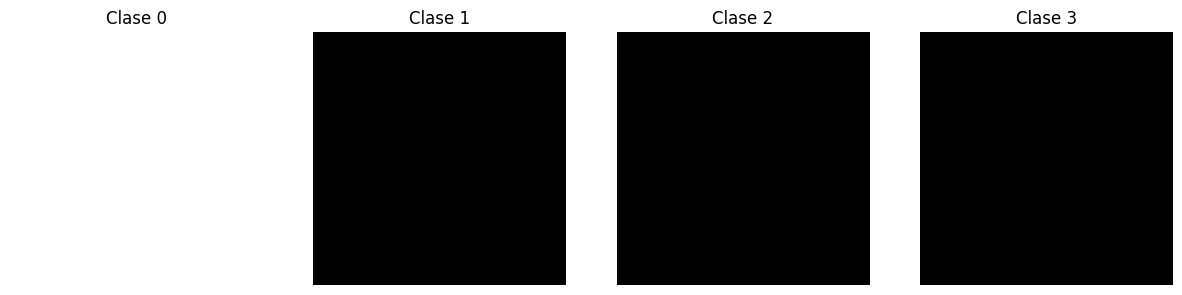

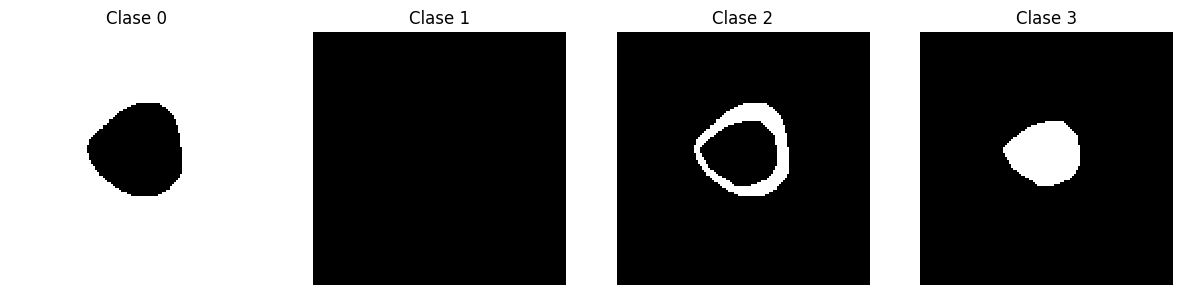

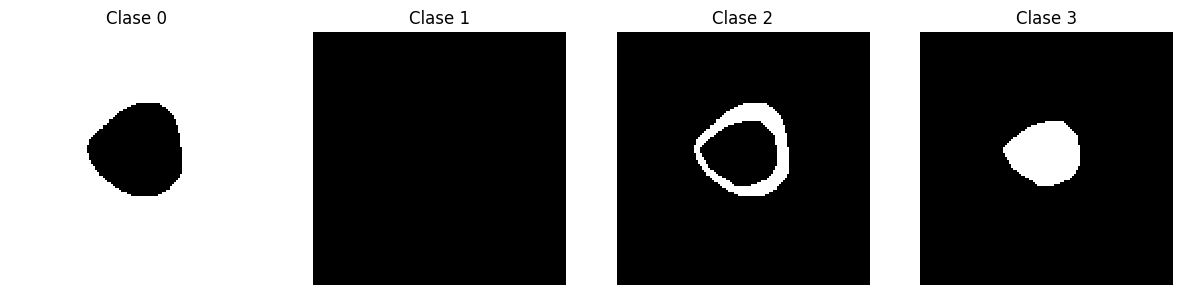

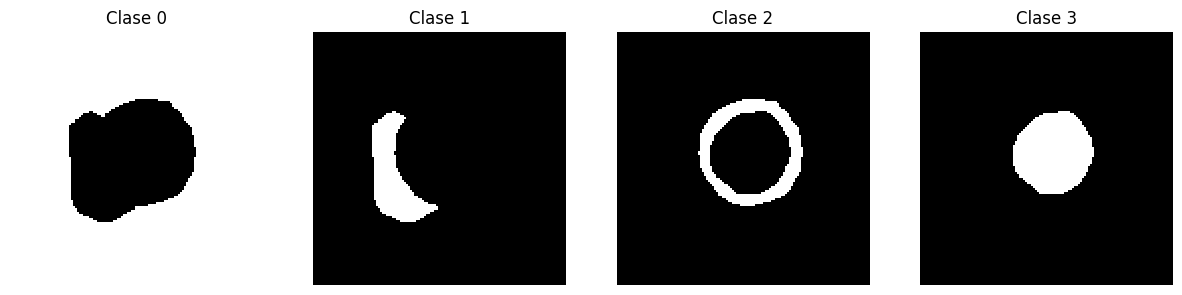

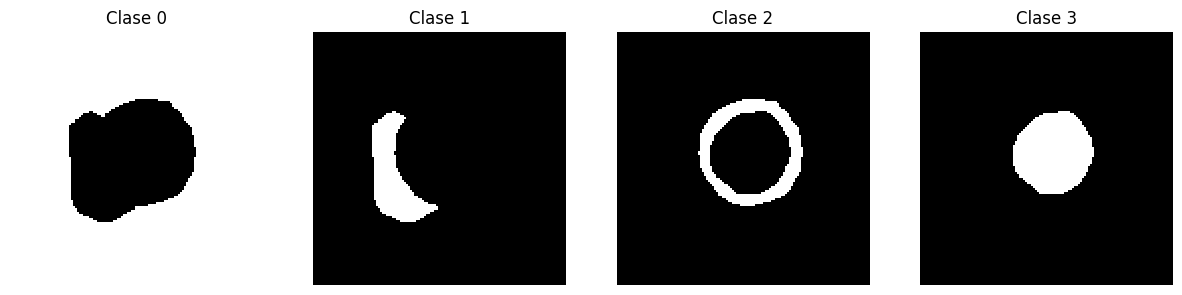

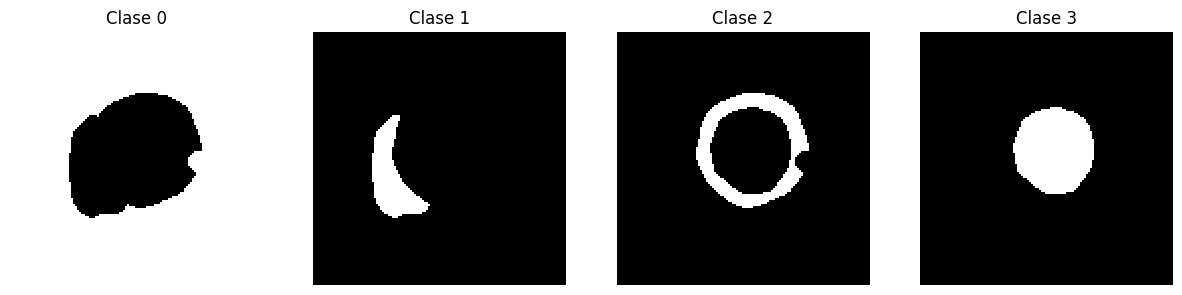

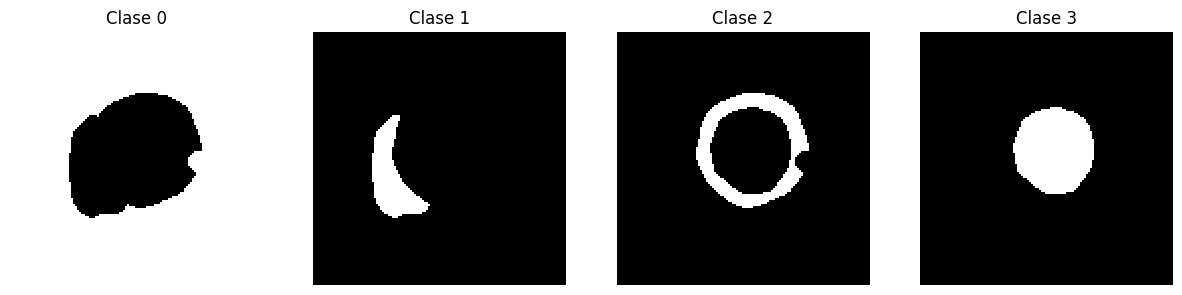

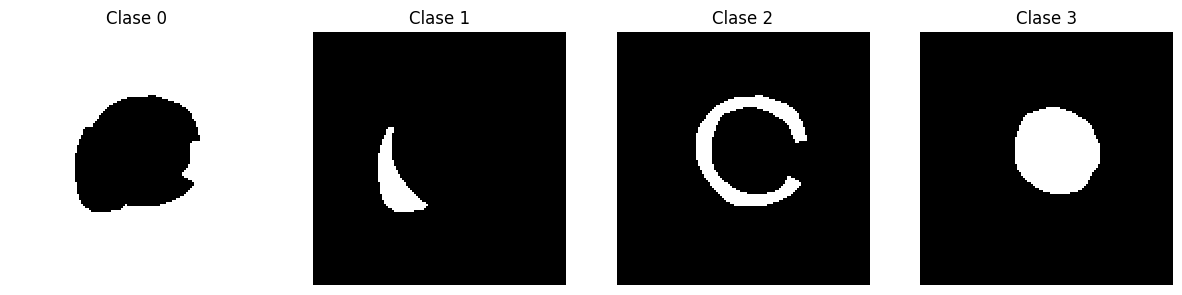

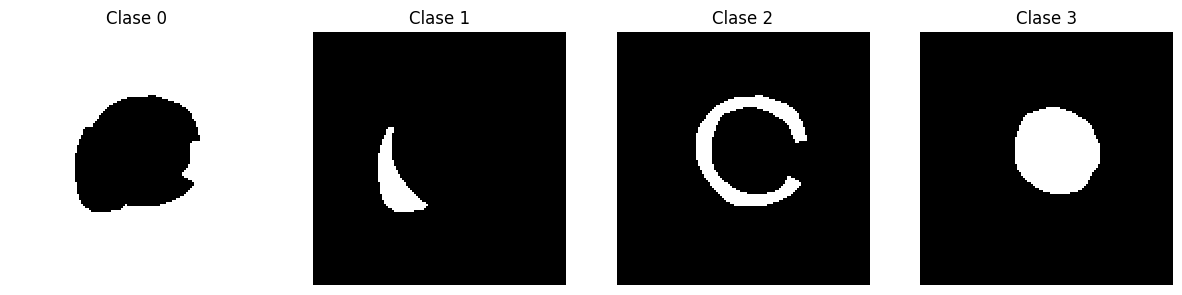

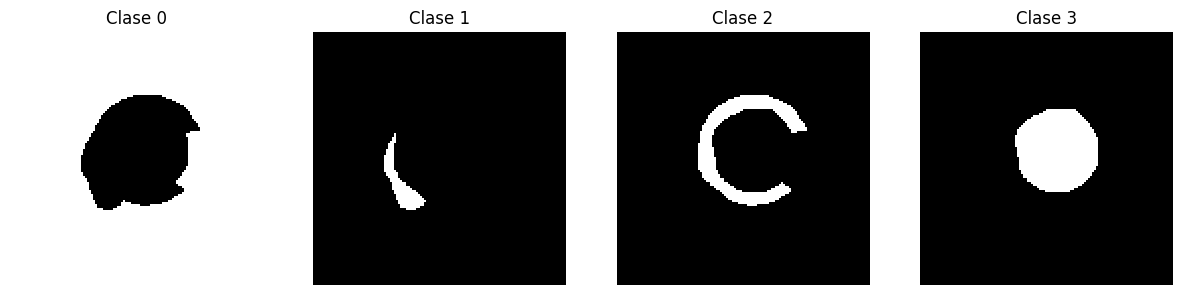

In [32]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_2)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

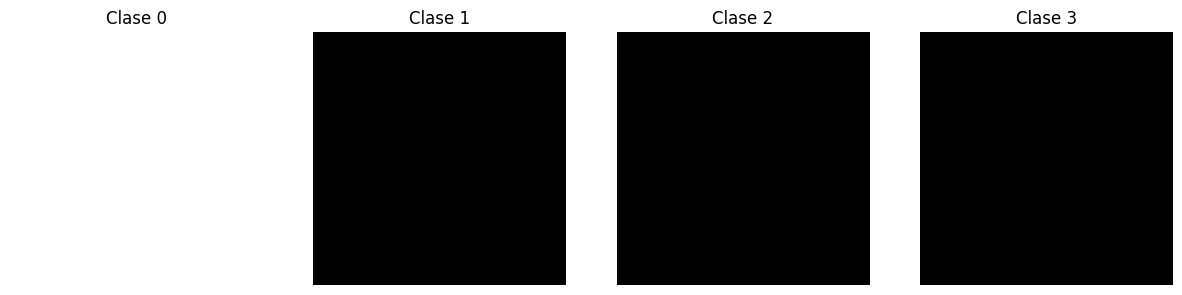

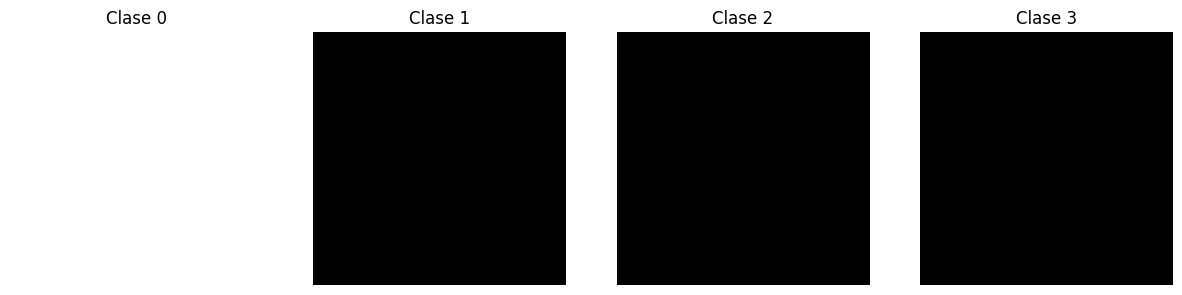

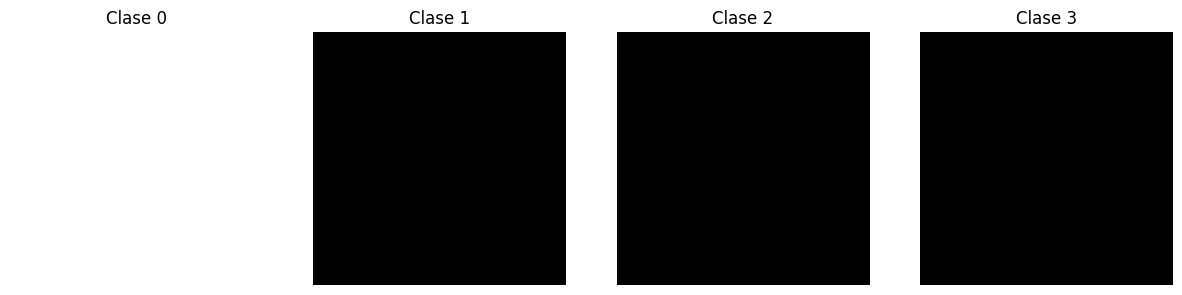

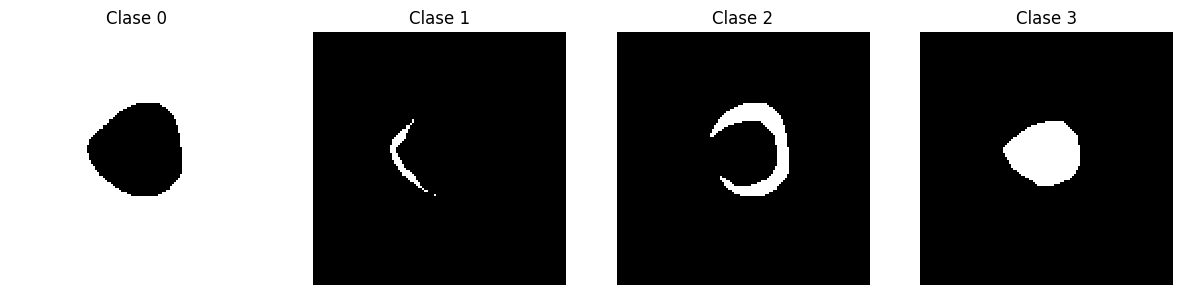

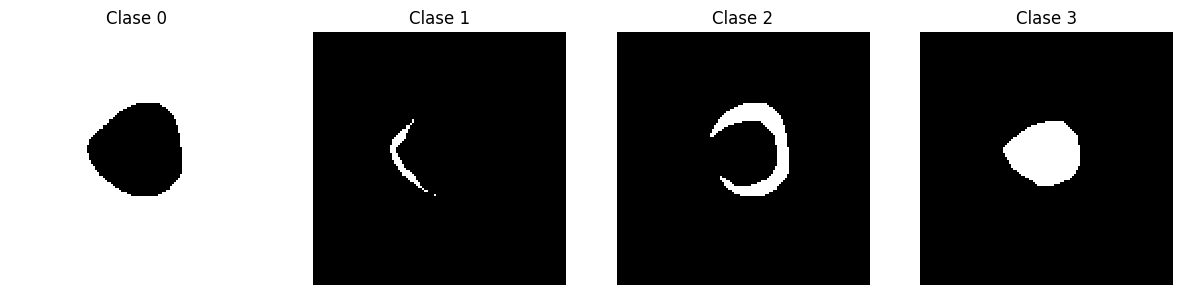

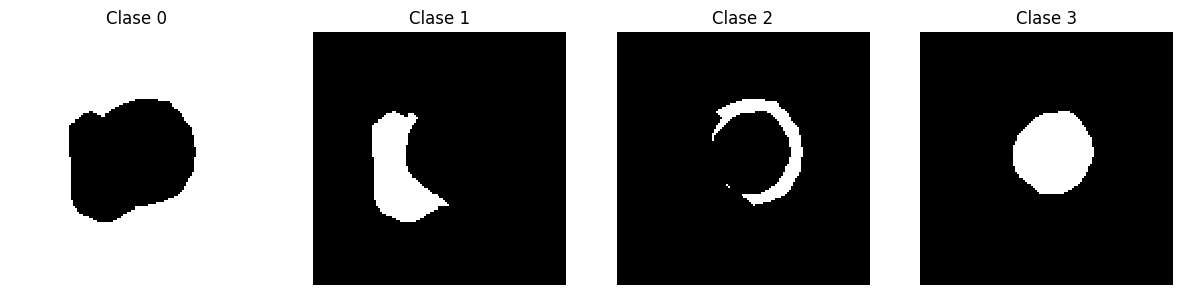

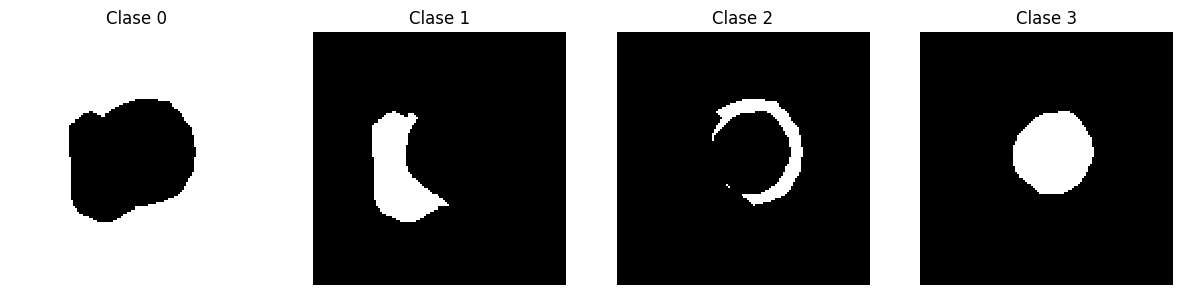

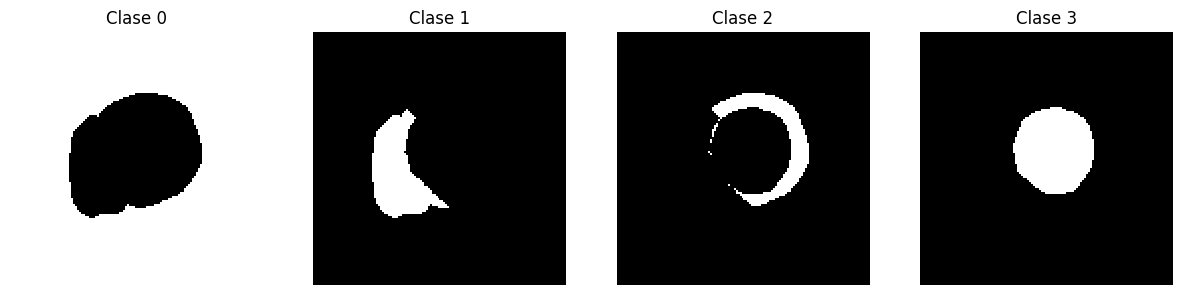

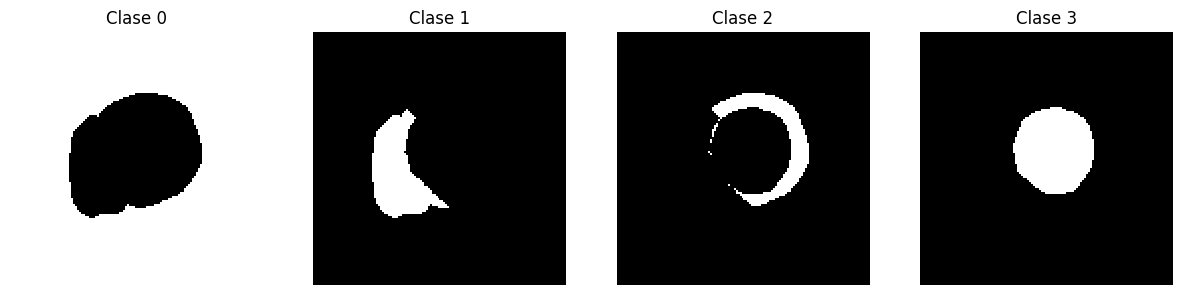

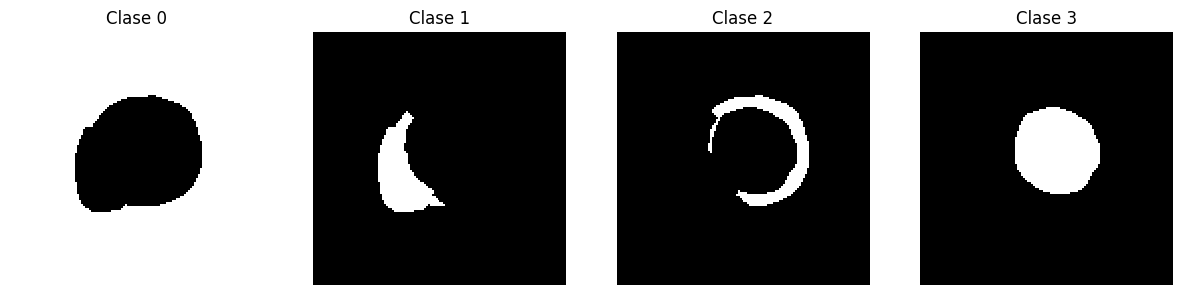

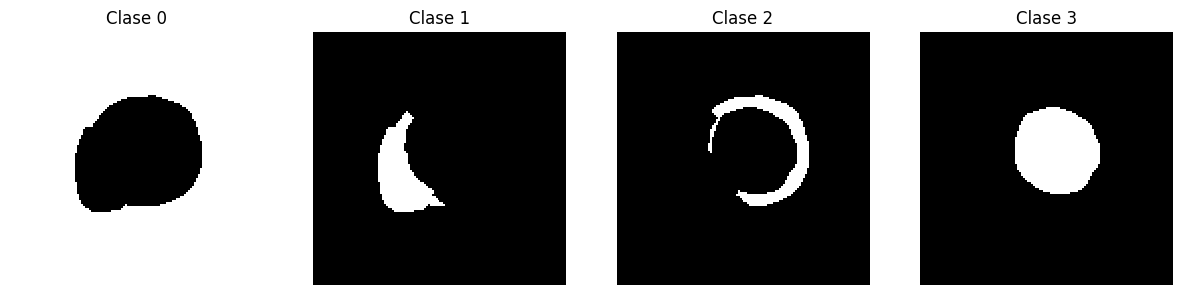

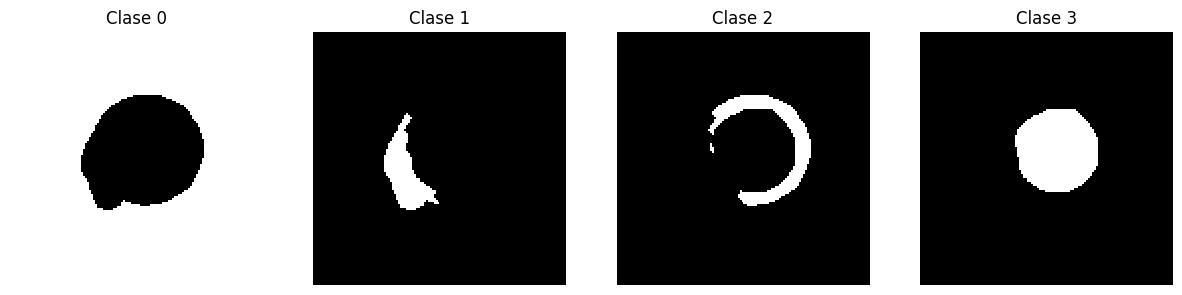

In [33]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_3)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [ ]:
train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=validation_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [35]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=validation_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [36]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere]
train_ds_sphere = Dataset(data=train_data_dicts_sphere, transform=all_transforms)

val_data_dicts_sphere = [{"image": file} for file in testing_files_sphere]
val_ds_sphere = Dataset(data=val_data_dicts_sphere, transform=validation_transforms)

train_loader_sphere = DataLoader(train_ds_sphere, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere[0]["image"].shape}')
val_loader_sphere = DataLoader(val_ds_sphere, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [37]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2]
train_ds_sphere_2 = Dataset(data=train_data_dicts_sphere_2, transform=all_transforms)

val_data_dicts_sphere_2 = [{"image": file} for file in testing_files_sphere_2]
val_ds_sphere_2 = Dataset(data=val_data_dicts_sphere_2, transform=validation_transforms)

train_loader_sphere_2 = DataLoader(train_ds_sphere_2, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_2[0]["image"].shape}')
val_loader_sphere_2 = DataLoader(val_ds_sphere_2, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_2[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [38]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3]
train_ds_sphere_3 = Dataset(data=train_data_dicts_sphere_3, transform=all_transforms)

val_data_dicts_sphere_3 = [{"image": file} for file in testing_files_sphere_3]
val_ds_sphere_3 = Dataset(data=val_data_dicts_sphere_3, transform=validation_transforms)

train_loader_sphere_3 = DataLoader(train_ds_sphere_3, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_3[0]["image"].shape}')
val_loader_sphere_3 = DataLoader(val_ds_sphere_3, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_3[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [39]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated]
train_ds_elongated = Dataset(data=train_data_dicts_elongated, transform=all_transforms)

val_data_dicts_elongated = [{"image": file} for file in testing_files_elongated]
val_ds_elongated = Dataset(data=val_data_dicts_elongated, transform=validation_transforms)

train_loader_elongated = DataLoader(train_ds_elongated, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_elongated[0]["image"].shape}')
val_loader_elongated = DataLoader(val_ds_elongated, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_elongated[0]["image"].shape}')

Image shape torch.Size([4, 24, 128, 128])
Image shape torch.Size([4, 24, 128, 128])


In [ ]:
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape
first(val_loader_sphere).__getitem__("image").shape
first(val_loader_sphere_2).__getitem__("image").shape
first(val_loader_sphere_3).__getitem__("image").shape
first(val_loader_elongated).__getitem__("image").shape

torch.Size([1, 4, 24, 128, 128])

In [41]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [42]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [43]:
postprocess_mask_sphere = postprocess_transform(val_ds_sphere[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere.shape[0]):
    plt.subplot(1, postprocess_mask_sphere.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere[i], cmap="gray", interpolation='none')
    plt.axis("off")
    
postprocess_mask_sphere_2 = postprocess_transform(val_ds_sphere_2[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_2.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_2.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_2[i], cmap="gray", interpolation='none')
    plt.axis("off")

postprocess_mask_sphere_3 = postprocess_transform(val_ds_sphere_3[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_3.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_3.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_3[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [44]:
postprocess_mask_elongated = postprocess_transform(val_ds_elongated[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_elongated.shape[0]):
    plt.subplot(1, postprocess_mask_elongated.shape[1], i + 1)
    plt.imshow(postprocess_mask_elongated[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 24, 128, 128])


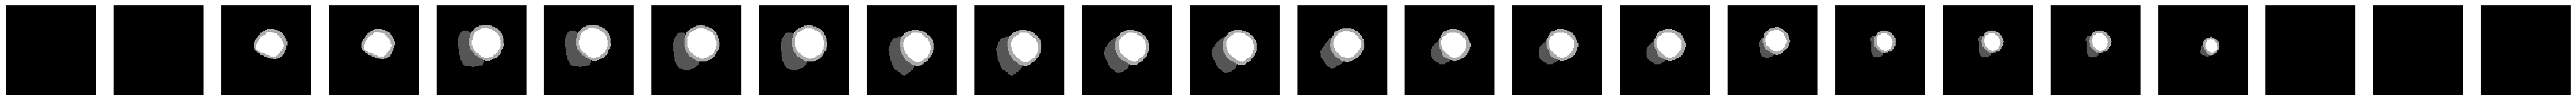

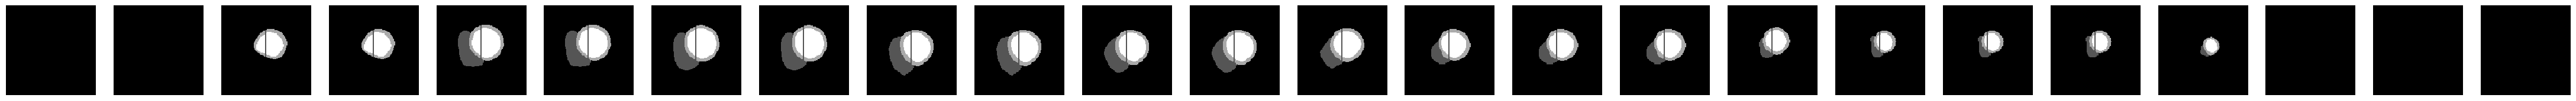

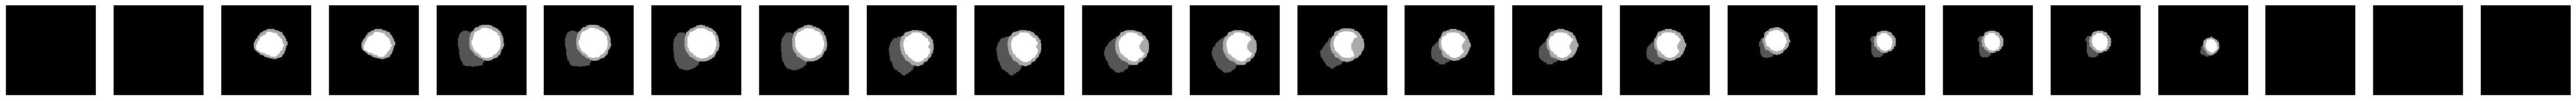

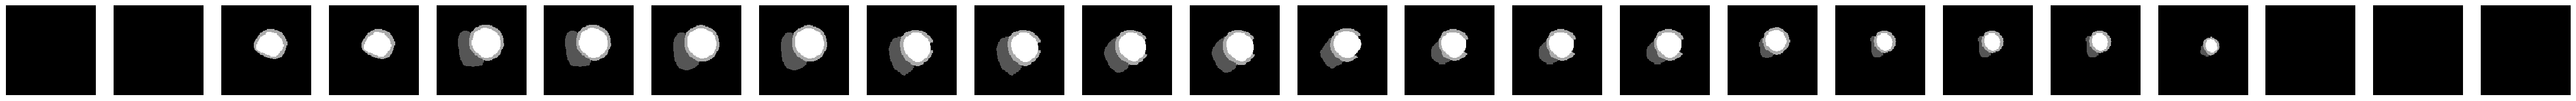

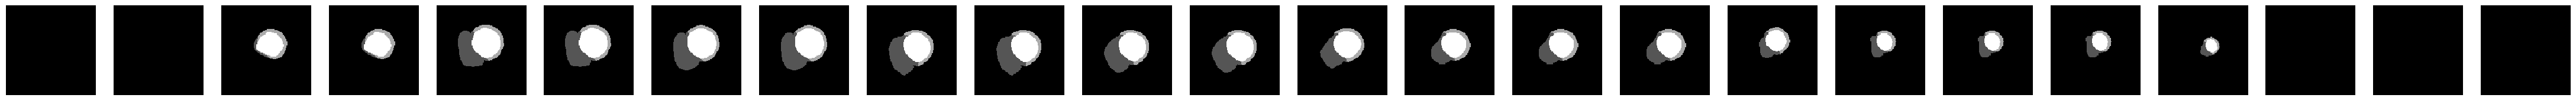

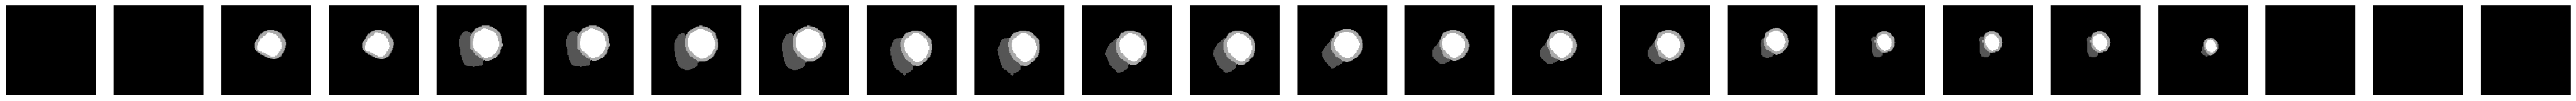

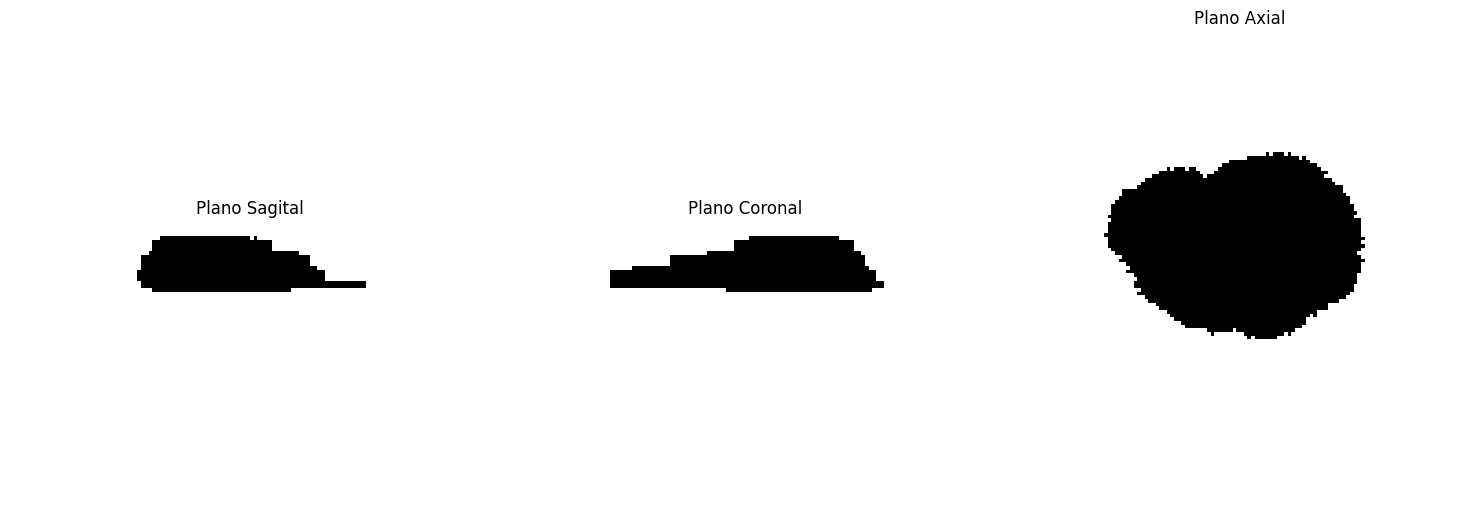

In [45]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 24, 128, 128])


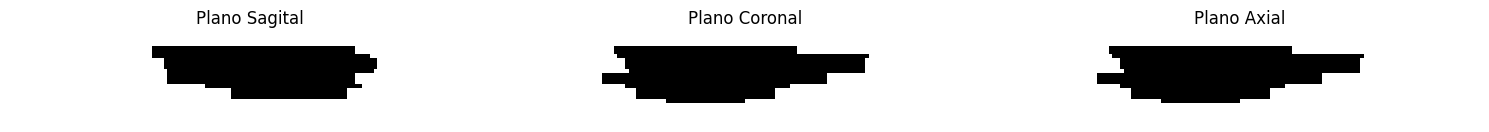

In [ ]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Sagittal
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

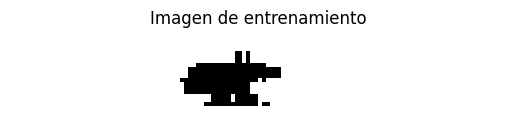

In [ ]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 24, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


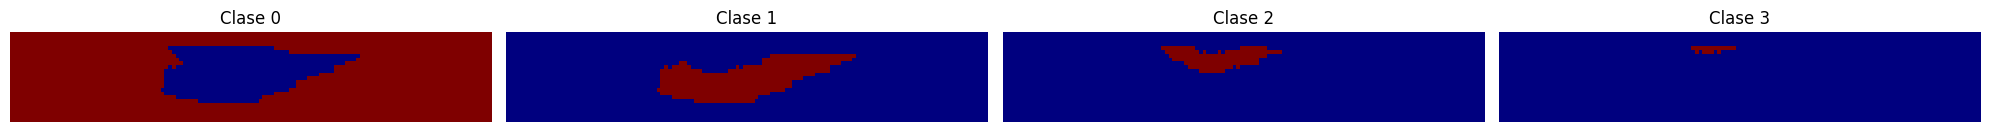

In [ ]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, classes, width, heitght, depth)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

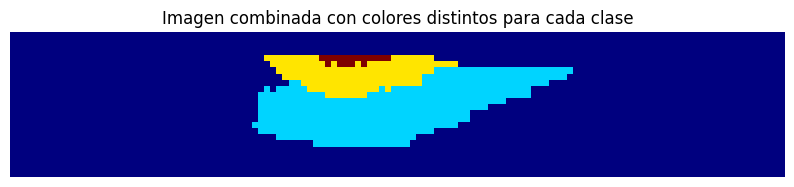

In [ ]:
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx] 

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=2, padding=1),       # [4, 24, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=(1,1,1)),      # [16, 12, 64, 64] -> [16, 24, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 24, 128, 128] -> [4, 24, 128, 128]
        )
    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x) 
        flattened = encoded.view(encoded.size(0), -1)
        latent_vector = self.fc[1](flattened) 
        fc_output = self.fc[2:](latent_vector) 

        # Decoder
        reshaped = fc_output.view(encoded.size())
        decoded = self.decoder(reshaped)

        return decoded, latent_vector 
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 24, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 24, 128, 128])
Output shape: torch.Size([1, 4, 24, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [52]:
def save_latent_vectors(model, train_loader, val_loader, desc):
    train_latent_vectors = []
    val_latent_vectors = []

    with torch.no_grad():
        for batch_data in tqdm(train_loader, desc=f"Saving Train Latent Vectors ({desc})"):
            inputs = batch_data["image"].to(device)
            _, latent_vectors = model(inputs)
            train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

        for val_data in tqdm(val_loader, desc=f"Saving Validation Latent Vectors ({desc})"):
            val_inputs = val_data["image"].to(device)
            _, latent_vectors = model(val_inputs)
            val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    train_latent_vectors = np.concatenate(train_latent_vectors, axis=0)
    val_latent_vectors = np.concatenate(val_latent_vectors, axis=0)

    return train_latent_vectors, val_latent_vectors

In [ ]:
# Calculation of Dice and Hausdorff with Monai (class-wise metrics, reduction="none")

from monai.metrics import DiceMetric, compute_hausdorff_distance

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

num_epochs = 30
val_interval = 1
train_loss_list = []
val_loss_list = []
best_val_dice = 0
best_val_hausdorff = float('inf')

num_classes = 4
dice_metric = DiceMetric(include_background=False, reduction="none", get_not_nans=False)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    dice_metric.reset()

    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)

        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        outputs_softmax = F.softmax(outputs, dim=1)
        outputs_one_hot = F.one_hot(torch.argmax(outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        dice_metric(y_pred=outputs_one_hot, y=inputs)

    dice_per_class = dice_metric.aggregate()
    avg_train_dice = dice_per_class.mean().item()

    hausdorff_distances_train = compute_hausdorff_distance(outputs_one_hot, inputs, include_background=False)
    avg_train_hausdorff = hausdorff_distances_train.mean().item()

    train_loss_list.append(train_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss_list[-1]:.4f}")
    print(f"  Train Dice: {avg_train_dice:.4f}")
    print(f"  Train Dice by Class: {dice_per_class.tolist()}")
    print(f"  Train Hausdorff: {avg_train_hausdorff:.4f}")
    print(f"  Train Hausdorff by Class: {hausdorff_distances_train.tolist()}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        dice_metric.reset()

        with torch.no_grad():
            for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)

                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

                val_outputs_softmax = F.softmax(val_outputs, dim=1)
                val_outputs_one_hot = F.one_hot(torch.argmax(val_outputs_softmax, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
                dice_metric(y_pred=val_outputs_one_hot, y=val_inputs)

        dice_per_class_val = dice_metric.aggregate()
        avg_val_dice = dice_per_class_val.mean().item()
        
        hausdorff_distances_val = compute_hausdorff_distance(val_outputs_one_hot, val_inputs, include_background=False)
        avg_val_hausdorff = hausdorff_distances_val.mean().item()

        val_loss_list.append(val_loss / len(val_loader))

        print(f"  Validation Loss: {val_loss_list[-1]:.4f}")
        print(f"  Validation Dice: {avg_val_dice:.4f}")
        print(f"  Validation Dice by Class: {dice_per_class_val.tolist()}")
        print(f"  Validation Hausdorff: {avg_val_hausdorff:.4f}")
        print(f"  Validation Hausdorff by Class: {hausdorff_distances_val.tolist()}")

        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Best Dice")

        if avg_val_hausdorff < best_val_hausdorff:
            best_val_hausdorff = avg_val_hausdorff
            best_train_latent_vectors_hausdorff, best_val_latent_vectors_hausdorff = save_latent_vectors(model, train_loader, val_loader, "Best Hausdorff")

last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

Epoch 1/30 [Train]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


Epoch [1/30]
  Train Loss: 0.2431
  Train Dice: 0.0634
  Train Dice by Class: [[0.04458802938461304, 0.035651348531246185, 0.0646534115076065], [0.01981143280863762, 0.008449402637779713, 0.036897413432598114], [0.0014144271844998002, 0.0007198776002041996, 0.008142493665218353], [0.0, 0.0, 0.0005470459582284093], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.00010603891860228032], [0.3443574011325836, 0.0, 0.05254893749952316], [0.26102012395858765, 0.0, 0.07709679752588272], [0.48161110281944275, 0.00026113068452104926, 0.06004878878593445], [0.14047755300998688, 0.0, 0.03894510865211487], [0.1882598102092743, 0.0, 0.09624999761581421], [0.25919654965400696, 0.00020026034326292574, 0.06553353369235992], [0.20034843683242798, 0.0, 0.13564729690551758

Epoch 1/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


  Validation Loss: 0.1909
  Validation Dice: 0.1877
  Validation Dice by Class: [[0.0335673913359642, 0.00038295835838653147, 0.6035937070846558], [0.04058416560292244, 0.0003737270017154515, 0.6202862858772278], [0.03662401810288429, 0.0, 0.6103479862213135], [0.0, 0.0002770850551314652, 0.15326035022735596], [0.0277410838752985, 0.0008482963312417269, 0.6882588863372803], [0.0202774815261364, 0.0008313703583553433, 0.6752732992172241], [0.021725691854953766, 0.0008968609618023038, 0.6236196160316467], [0.00040941659244708717, 0.0, 0.4393531084060669], [0.017961211502552032, 0.0, 0.6462985873222351], [0.0, 0.00015256693586707115, 0.5126618146896362], [0.02948916330933571, 0.00039623575867153704, 0.5276431441307068], [0.030672980472445488, 0.00019880715990439057, 0.556897759437561], [0.03540872409939766, 0.0, 0.5867717266082764], [0.0403246246278286, 0.000320461462251842, 0.5546339750289917], [0.021429426968097687, 0.0007011147681623697, 0.46482527256011963], [0.0, 0.0, 0.2535872757434

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:18<00:00, 10.81it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 18.26it/s]
Epoch 2/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


Epoch [2/30]
  Train Loss: 0.1941
  Train Dice: 0.1609
  Train Dice by Class: [[0.014938599430024624, 0.00026140373665839434, 0.5938131809234619], [0.0019755526445806026, 0.00016330530343111604, 0.5913353562355042], [0.048072345554828644, 0.00034837136627174914, 0.5772043466567993], [0.030419612303376198, 0.000900495273526758, 0.21647147834300995], [0.018342526629567146, 0.00048564316239207983, 0.5368613004684448], [0.031079716980457306, 0.0014695076970383525, 0.6795474290847778], [0.012423131614923477, 0.000902170839253813, 0.5773029923439026], [0.025168539956212044, 0.0008676789584569633, 0.32077115774154663], [0.03962206467986107, 0.00014893141633365303, 0.4722326397895813], [0.03448275849223137, 0.000837170344311744, 0.6846014261245728], [0.018899979069828987, 0.0015145777724683285, 0.483190655708313], [0.003393160179257393, 0.00011711659317370504, 0.5400010347366333], [0.01132743339985609, 0.0011554014636203647, 0.605847179889679], [0.013106290251016617, 0.0008451894391328096, 0.5

Epoch 2/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


  Validation Loss: 0.1848
  Validation Dice: 0.1940
  Validation Dice by Class: [[0.0, 0.0011476663639768958, 0.6759505271911621], [0.0, 0.0013075558235868812, 0.7512573599815369], [0.0, 0.0009960159659385681, 0.6313861608505249], [0.0, 0.0005536332027986646, 0.4993884265422821], [0.0, 0.0012719949008896947, 0.7545548677444458], [0.0, 0.0011077263625338674, 0.7350893020629883], [0.0, 0.0019420376047492027, 0.6707970499992371], [0.0, 0.0013135425979271531, 0.33917397260665894], [0.0, 0.0015957446303218603, 0.6922774314880371], [0.0, 0.002286062575876713, 0.46649378538131714], [0.0, 0.0017812963342294097, 0.5639447569847107], [0.0, 0.0019847177900373936, 0.5883315205574036], [0.0, 0.0010319917928427458, 0.5912139415740967], [0.0, 0.00031999999191612005, 0.546649158000946], [0.0, 0.0018202184000983834, 0.5234991908073425], [0.0, 0.0015429718187078834, 0.4457540810108185], [0.0, 0.001549386652186513, 0.6153488159179688], [0.0, 0.00024975024280138314, 0.5425739884376526], [0.0, 0.0010736525

Epoch 3/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.84it/s]


Epoch [3/30]
  Train Loss: 0.1915
  Train Dice: 0.1715
  Train Dice by Class: [[0.0, 0.0006762239499948919, 0.30674535036087036], [0.0, 0.0, 0.24936799705028534], [0.0, 0.001206090790219605, 0.2894698977470398], [0.0, 0.0005519525147974491, 0.26780056953430176], [0.0, 0.0, 0.17163263261318207], [0.0, 0.0008691333350725472, 0.3592563569545746], [0.0, 0.0, 0.4579993188381195], [0.0, 0.00021343577827792615, 0.5735043883323669], [0.0, 0.00036934440140612423, 0.4989278018474579], [0.0, 0.0008133387309499085, 0.442353755235672], [0.0, 0.0, 0.4089210629463196], [0.0, 0.001300178817473352, 0.26748064160346985], [0.0, 0.0016704949084669352, 0.1950055956840515], [0.0, 0.0014767083339393139, 0.6873819828033447], [0.0, 0.0014204545877873898, 0.6944025158882141], [0.0, 0.0007927699480205774, 0.5207332372665405], [0.0, 0.0005458018858917058, 0.4428510367870331], [0.0, 0.0019368978682905436, 0.7102755308151245], [0.0, 0.0008770647691562772, 0.5364783406257629], [0.0, 0.0010473032016307116, 0.61091053

Epoch 3/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.80it/s]


  Validation Loss: 0.1854
  Validation Dice: 0.1802
  Validation Dice by Class: [[0.0, 0.004006104543805122, 0.6220025420188904], [0.0, 0.0016795744886621833, 0.7004157304763794], [0.0, 0.0006626905524171889, 0.5319286584854126], [0.0, 0.0035911602899432182, 0.3834705948829651], [0.0, 0.0012708274880424142, 0.7253730297088623], [0.0, 0.0013830302050337195, 0.7460416555404663], [0.0, 0.0011946539161726832, 0.6594783663749695], [0.0, 0.001706708688288927, 0.29970407485961914], [0.0, 0.0001773521362338215, 0.5805813670158386], [0.0, 0.0027420215774327517, 0.38052648305892944], [0.0, 0.0033537186682224274, 0.4981549382209778], [0.0, 0.001784121268428862, 0.5127440690994263], [0.0, 0.0030895983800292015, 0.6818400621414185], [0.0, 0.002233567414805293, 0.6031838059425354], [0.0, 0.002098929602652788, 0.44231367111206055], [0.0, 0.0020046259742230177, 0.3962991535663605], [0.0, 0.00154440151527524, 0.6366756558418274], [0.0, 0.0022413148544728756, 0.6174255013465881], [0.0, 0.000643155770376

Epoch 4/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.96it/s]


Epoch [4/30]
  Train Loss: 0.1817
  Train Dice: 0.1821
  Train Dice by Class: [[0.0, 0.0016268579056486487, 0.6064878106117249], [0.0, 0.0020820321515202522, 0.5034266114234924], [0.0, 0.0019186493009328842, 0.6022210121154785], [0.0, 0.0009192584548145533, 0.4734330177307129], [0.0, 0.002933583687990904, 0.7155804634094238], [0.0, 0.002807148965075612, 0.5488665699958801], [0.0, 0.004283310379832983, 0.21926061809062958], [0.0, 0.0030756324995309114, 0.32844096422195435], [0.0, 0.007825600914657116, 0.37477031350135803], [0.0, 0.005924540106207132, 0.40232717990875244], [0.0, 0.0060761114582419395, 0.49010026454925537], [0.0, 0.0034817932173609734, 0.33412665128707886], [0.0, 0.0027171741239726543, 0.5630818009376526], [0.0, 0.0023141452111303806, 0.2745314836502075], [0.0, 0.0030244113877415657, 0.44183990359306335], [0.0, 0.002889616647735238, 0.3666403591632843], [0.0, 0.0011848341673612595, 0.6034406423568726], [0.0, 0.005799056030809879, 0.26384249329566956], [0.0, 0.003036673646

Epoch 4/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


  Validation Loss: 0.1818
  Validation Dice: 0.2019
  Validation Dice by Class: [[0.0, 0.04453118145465851, 0.6560587882995605], [0.0, 0.043794311583042145, 0.725865364074707], [0.0, 0.02366127073764801, 0.6639015078544617], [0.0, 0.04081091657280922, 0.45770975947380066], [0.0, 0.05499628558754921, 0.7303626537322998], [0.0, 0.026089895516633987, 0.7232420444488525], [0.0, 0.05034945160150528, 0.6827046871185303], [0.0, 0.04873369261622429, 0.30089884996414185], [0.0, 0.04550415650010109, 0.6285285949707031], [0.0, 0.056923191994428635, 0.39280906319618225], [0.0, 0.01918078400194645, 0.47429677844047546], [0.0, 0.01679609902203083, 0.49384447932243347], [0.0, 0.05659184232354164, 0.7508915066719055], [0.0, 0.05851462855935097, 0.659540593624115], [0.0, 0.012232817709445953, 0.4220586121082306], [0.0, 0.0493956133723259, 0.4008617103099823], [0.0, 0.07548022270202637, 0.6416605114936829], [0.0, 0.06103340536355972, 0.6757038831710815], [0.0, 0.0414000004529953, 0.5999799370765686], [0

Epoch 5/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


Epoch [5/30]
  Train Loss: 0.1695
  Train Dice: 0.2294
  Train Dice by Class: [[0.0, 0.0458715595304966, 0.6794674396514893], [0.0, 0.053565867245197296, 0.7697129845619202], [0.0, 0.008673653937876225, 0.4723094403743744], [0.0, 0.04627910256385803, 0.20797888934612274], [0.0, 0.014970059506595135, 0.5433964729309082], [0.0, 0.006367234513163567, 0.7512835264205933], [0.0, 0.0019491066923364997, 0.5413986444473267], [0.0, 0.009114212356507778, 0.41256260871887207], [0.0, 0.006966699380427599, 0.24833659827709198], [0.0, 0.001716738217510283, 0.7081958651542664], [0.0, 0.005889176391065121, 0.6742607951164246], [0.0, 0.011043465696275234, 0.5973998308181763], [0.0, 0.0020374897867441177, 0.48191091418266296], [0.0, 0.014498122036457062, 0.7301396727561951], [0.0, 0.00798509456217289, 0.40392082929611206], [0.0, 0.013037138618528843, 0.7292580008506775], [0.0010704727610573173, 0.023993873968720436, 0.7473309636116028], [0.002023976296186447, 0.010259333066642284, 0.48418790102005005], 

Epoch 5/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


  Validation Loss: 0.1843
  Validation Dice: 0.3044
  Validation Dice by Class: [[0.38002341985702515, 0.06319702416658401, 0.7109589576721191], [0.15057572722434998, 0.028137600049376488, 0.649458646774292], [0.11218568682670593, 0.057551853358745575, 0.4173074960708618], [0.0014240957098081708, 0.0033199612516909838, 0.0], [0.25790947675704956, 0.04660627618432045, 0.6505984663963318], [0.09733229130506516, 0.029565103352069855, 0.5620938539505005], [0.34361138939857483, 0.06574585288763046, 0.7227845191955566], [0.17002081871032715, 0.0810287818312645, 0.43863892555236816], [0.27200090885162354, 0.055780768394470215, 0.5531818866729736], [0.013862148858606815, 0.07047756761312485, 0.3845975399017334], [0.21568351984024048, 0.10159789770841599, 0.5894855260848999], [0.27477502822875977, 0.12432432174682617, 0.6309095025062561], [0.33832526206970215, 0.06755555421113968, 0.7325748801231384], [0.3024110496044159, 0.08875070512294769, 0.5903156995773315], [0.3828316330909729, 0.11714145

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:18<00:00, 10.82it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]
Epoch 6/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


Epoch [6/30]
  Train Loss: 0.1604
  Train Dice: 0.3657
  Train Dice by Class: [[0.2933841943740845, 0.01631265878677368, 0.2698284387588501], [0.4098171293735504, 0.026743490248918533, 0.4403097331523895], [0.20591118931770325, 0.027464644983410835, 0.6151666641235352], [0.3990335464477539, 0.022664016112685204, 0.6444108486175537], [0.14094199240207672, 0.037766169756650925, 0.6187489628791809], [0.32134801149368286, 0.06001829728484154, 0.5176835656166077], [0.2382211536169052, 0.046124763786792755, 0.3910839855670929], [0.138229638338089, 0.09816493839025497, 0.6733333468437195], [0.5490936040878296, 0.032450705766677856, 0.6040738821029663], [0.2347150593996048, 0.060506097972393036, 0.6291041970252991], [0.08931021392345428, 0.10431821644306183, 0.7824938297271729], [0.24208903312683105, 0.06087180972099304, 0.26318618655204773], [0.465037077665329, 0.13184700906276703, 0.5716704726219177], [0.27002835273742676, 0.12021777778863907, 0.696336567401886], [0.2729853093624115, 0.07152

Epoch 6/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


  Validation Loss: 0.1575
  Validation Dice: 0.3559
  Validation Dice by Class: [[0.5210517644882202, 0.19982358813285828, 0.7839508056640625], [0.2092653214931488, 0.1231919378042221, 0.7768939137458801], [0.047884706407785416, 0.16607823967933655, 0.7852662205696106], [0.0, 0.19245682656764984, 0.6589936017990112], [0.49072474241256714, 0.23038740456104279, 0.7935864329338074], [0.17187300324440002, 0.2011442333459854, 0.7153249979019165], [0.6160857081413269, 0.2545090317726135, 0.7189984321594238], [0.08795137703418732, 0.10529553145170212, 0.30066174268722534], [0.4361605644226074, 0.23163233697414398, 0.7715553045272827], [0.02586737833917141, 0.1672642081975937, 0.44479212164878845], [0.32534077763557434, 0.0377572737634182, 0.5735543370246887], [0.39104974269866943, 0.0656934306025505, 0.6064379215240479], [0.15482735633850098, 0.1251172125339508, 0.7685509324073792], [0.0007790184463374317, 0.08558623492717743, 0.6032291054725647], [0.537991464138031, 0.10547912120819092, 0.57

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:18<00:00, 10.78it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]
Epoch 7/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


Epoch [7/30]
  Train Loss: 0.1430
  Train Dice: 0.4601
  Train Dice by Class: [[0.5505735278129578, 0.2971698045730591, 0.6167234778404236], [0.46541786193847656, 0.3885488510131836, 0.6015259623527527], [0.18498392403125763, 0.4655509293079376, 0.5915682315826416], [0.32107624411582947, 0.19826383888721466, 0.7758492231369019], [0.518752932548523, 0.20944051444530487, 0.6205689907073975], [0.18703266978263855, 0.10621009767055511, 0.7646411657333374], [0.1812964677810669, 0.14980100095272064, 0.7890823483467102], [0.06939799338579178, 0.11987122148275375, 0.7953381538391113], [0.22509530186653137, 0.15884019434452057, 0.4624898433685303], [0.19432780146598816, 0.10899553447961807, 0.565684974193573], [0.3979282081127167, 0.14438562095165253, 0.7271009683609009], [0.4601018726825714, 0.31819427013397217, 0.8350408673286438], [0.23645944893360138, 0.2336968183517456, 0.6420397162437439], [0.4463701844215393, 0.3536481559276581, 0.8053318858146667], [0.5051903128623962, 0.391952306032180

Epoch 7/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


  Validation Loss: 0.1456
  Validation Dice: 0.4241
  Validation Dice by Class: [[0.42351871728897095, 0.2911924719810486, 0.82469242811203], [0.255344420671463, 0.33150526881217957, 0.826443076133728], [0.09792626649141312, 0.32765820622444153, 0.7288680076599121], [0.0, 0.29219144582748413, 0.5105313062667847], [0.41639477014541626, 0.4101215898990631, 0.8099936842918396], [0.2585407793521881, 0.33982953429222107, 0.7183994054794312], [0.37207239866256714, 0.2976638972759247, 0.7404689788818359], [0.145454540848732, 0.31726282835006714, 0.3612690269947052], [0.38811758160591125, 0.3806329667568207, 0.7825837135314941], [0.15617623925209045, 0.4186508059501648, 0.5010937452316284], [0.18716362118721008, 0.02530837059020996, 0.6671992540359497], [0.3522551655769348, 0.05281723663210869, 0.7126195430755615], [0.05276443436741829, 0.32180261611938477, 0.8386156558990479], [0.0, 0.2717219591140747, 0.6723712086677551], [0.47954174876213074, 0.26083922386169434, 0.7045966982841492], [0.113

Epoch 8/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


Epoch [8/30]
  Train Loss: 0.1304
  Train Dice: 0.4879
  Train Dice by Class: [[0.589241087436676, 0.14789894223213196, 0.4605003595352173], [0.49550437927246094, 0.40389958024024963, 0.8720650672912598], [0.6077765226364136, 0.29676729440689087, 0.40391531586647034], [0.19511885941028595, 0.2363489419221878, 0.7548120021820068], [0.2922170162200928, 0.16678832471370697, 0.2592225968837738], [0.4024035930633545, 0.3240339159965515, 0.8082908391952515], [0.21124741435050964, 0.2759045958518982, 0.6339461207389832], [0.5547879934310913, 0.10621169954538345, 0.5682870149612427], [0.0, 0.2013745754957199, 0.5311559438705444], [0.4524686932563782, 0.2982531487941742, 0.2959881126880646], [0.35465937852859497, 0.12188602238893509, 0.5361461043357849], [0.08567335456609726, 0.38043782114982605, 0.5729808807373047], [0.6237332224845886, 0.22773706912994385, 0.5435144305229187], [0.5288262963294983, 0.18186059594154358, 0.6450300216674805], [0.5306693911552429, 0.19272640347480774, 0.6584621071

Epoch 8/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.67it/s]


  Validation Loss: 0.1418
  Validation Dice: 0.5012
  Validation Dice by Class: [[0.6274846196174622, 0.5327306985855103, 0.8513004779815674], [0.49197953939437866, 0.4754527509212494, 0.8191965222358704], [0.12490064650774002, 0.5387938022613525, 0.8032811284065247], [0.0, 0.5136300921440125, 0.6277705430984497], [0.4985831677913666, 0.4549884498119354, 0.7631057500839233], [0.347295343875885, 0.44033393263816833, 0.6136146783828735], [0.6018837690353394, 0.4349760413169861, 0.7526273727416992], [0.4620179235935211, 0.5276245474815369, 0.39934128522872925], [0.5102402567863464, 0.5113195776939392, 0.7560340762138367], [0.22067256271839142, 0.5673714876174927, 0.5406230688095093], [0.24113430082798004, 0.014909339137375355, 0.656135618686676], [0.3735961616039276, 0.028446635231375694, 0.7092714905738831], [0.46254682540893555, 0.40977931022644043, 0.848656177520752], [0.16664710640907288, 0.521293580532074, 0.7517547011375427], [0.5210185647010803, 0.2720203101634979, 0.69871968030929

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:18<00:00, 10.95it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]
Epoch 9/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.94it/s]


Epoch [9/30]
  Train Loss: 0.1213
  Train Dice: 0.5478
  Train Dice by Class: [[0.6125643253326416, 0.4683479070663452, 0.7693432569503784], [0.5090065598487854, 0.05296158045530319, 0.2673746943473816], [0.5309659242630005, 0.5713759064674377, 0.8573955297470093], [0.7299895286560059, 0.5243822932243347, 0.7790511846542358], [0.5447840690612793, 0.44170600175857544, 0.7218253016471863], [0.42272067070007324, 0.3936074376106262, 0.6928112506866455], [0.41728827357292175, 0.411533921957016, 0.7202685475349426], [0.5148029327392578, 0.34923622012138367, 0.5485571622848511], [0.54127037525177, 0.5440975427627563, 0.8677780032157898], [0.3323562443256378, 0.38684675097465515, 0.35795414447784424], [0.5137670040130615, 0.5475683808326721, 0.6762052178382874], [0.5390127301216125, 0.5104933381080627, 0.8038005232810974], [0.7465818524360657, 0.5180074572563171, 0.8057771325111389], [0.4766157567501068, 0.5246461629867554, 0.44349420070648193], [0.654618501663208, 0.41040390729904175, 0.81318

Epoch 9/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.88it/s]


  Validation Loss: 0.1586
  Validation Dice: 0.4627
  Validation Dice by Class: [[0.2603467106819153, 0.5027721524238586, 0.833649218082428], [0.12530121207237244, 0.5132856965065002, 0.8145756125450134], [0.0, 0.4235219955444336, 0.5894479155540466], [0.0, 0.29642313718795776, 0.0], [0.39696934819221497, 0.5648772120475769, 0.802530825138092], [0.26437073945999146, 0.50669926404953, 0.6669730544090271], [0.4104025065898895, 0.560085654258728, 0.7940245866775513], [0.2325325459241867, 0.5953795909881592, 0.4777889847755432], [0.33197030425071716, 0.5420633554458618, 0.7292969822883606], [0.003579647047445178, 0.5800801515579224, 0.5539568066596985], [0.09054981917142868, 0.07510446757078171, 0.7693566083908081], [0.15442593395709991, 0.19141508638858795, 0.8354777693748474], [0.12035028636455536, 0.4505143165588379, 0.7721673250198364], [0.0, 0.5620479583740234, 0.7180925607681274], [0.30020672082901, 0.49195051193237305, 0.7643114924430847], [0.0, 0.6259255409240723, 0.589240193367004

Epoch 10/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.82it/s]


Epoch [10/30]
  Train Loss: 0.1173
  Train Dice: 0.5515
  Train Dice by Class: [[0.6366089582443237, 0.5662493705749512, 0.8195667266845703], [0.37587985396385193, 0.4540432393550873, 0.6360105872154236], [0.455331414937973, 0.5970149040222168, 0.6769955158233643], [0.5140594244003296, 0.4800833463668823, 0.8197547197341919], [0.454873651266098, 0.38418078422546387, 0.7758310437202454], [0.5135539770126343, 0.4528239667415619, 0.7186671495437622], [0.7132484316825867, 0.6923856139183044, 0.8213453888893127], [0.6256852149963379, 0.6194967031478882, 0.5348646640777588], [0.30420053005218506, 0.7069304585456848, 0.5577819347381592], [0.6242176294326782, 0.52671879529953, 0.7293846011161804], [0.7141246199607849, 0.4134279489517212, 0.7162454724311829], [0.66561359167099, 0.5674105882644653, 0.8684827089309692], [0.6399498581886292, 0.5335022211074829, 0.8380399942398071], [0.6967996954917908, 0.5654443502426147, 0.6388856172561646], [0.22600767016410828, 0.3500930964946747, 0.59449964761

Epoch 10/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


  Validation Loss: 0.1521
  Validation Dice: 0.4659
  Validation Dice by Class: [[0.49372488260269165, 0.3092936873435974, 0.810383677482605], [0.49758046865463257, 0.4891819953918457, 0.8480129241943359], [0.2563658058643341, 0.5304076075553894, 0.701738715171814], [0.0, 0.32611674070358276, 0.0], [0.43979424238204956, 0.5139651894569397, 0.7962003350257874], [0.36974209547042847, 0.5235841274261475, 0.6845401525497437], [0.39474770426750183, 0.4224485158920288, 0.7441282272338867], [0.4281269311904907, 0.6117308735847473, 0.5023696422576904], [0.4884752333164215, 0.5190922021865845, 0.7730555534362793], [0.33555153012275696, 0.6699370741844177, 0.5479848384857178], [0.18541981279850006, 0.031911879777908325, 0.639583170413971], [0.23123912513256073, 0.07180763781070709, 0.6841995120048523], [0.18141980469226837, 0.4626334607601166, 0.8793360590934753], [0.057508789002895355, 0.5497673749923706, 0.7137612104415894], [0.41634345054626465, 0.17010487616062164, 0.6452983617782593], [0.35

Epoch 11/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.79it/s]


Epoch [11/30]
  Train Loss: 0.1148
  Train Dice: 0.5696
  Train Dice by Class: [[0.5176920294761658, 0.6693187952041626, 0.7586656808853149], [0.490757554769516, 0.47350817918777466, 0.7348848581314087], [0.3920893669128418, 0.5156198740005493, 0.8228539824485779], [0.6124231219291687, 0.5358499884605408, 0.4782448410987854], [0.5951178073883057, 0.44881537556648254, 0.7639991641044617], [0.46529650688171387, 0.5944271087646484, 0.8306330442428589], [0.5734351873397827, 0.5643773078918457, 0.6691871285438538], [0.6601678133010864, 0.5876432657241821, 0.8243299722671509], [0.6196897029876709, 0.20168757438659668, 0.6793291568756104], [0.47418496012687683, 0.4731701910495758, 0.5926101803779602], [0.682137668132782, 0.5925467610359192, 0.8793365359306335], [0.6204016208648682, 0.315920889377594, 0.4623109698295593], [0.6560202240943909, 0.4468540847301483, 0.7155563235282898], [0.57294762134552, 0.5380683541297913, 0.8502981066703796], [0.5020609498023987, 0.25358468294143677, 0.73907715

Epoch 11/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


  Validation Loss: 0.1419
  Validation Dice: 0.4621
  Validation Dice by Class: [[0.26407304406166077, 0.3630695939064026, 0.8080421090126038], [0.33149170875549316, 0.5452696084976196, 0.8450418710708618], [0.0182355847209692, 0.47689583897590637, 0.6559816598892212], [0.0, 0.1969587206840515, 0.0], [0.23777222633361816, 0.4964633285999298, 0.8017791509628296], [0.2845662832260132, 0.5305790901184082, 0.6957868337631226], [0.3140372335910797, 0.43161889910697937, 0.750885009765625], [0.4770773649215698, 0.5922501683235168, 0.5541177988052368], [0.2821807265281677, 0.500709593296051, 0.7668461203575134], [0.21532003581523895, 0.6243126392364502, 0.5591909289360046], [0.08014796674251556, 0.09339224547147751, 0.7359208464622498], [0.12653927505016327, 0.17675606906414032, 0.7716918587684631], [0.3851436674594879, 0.4766612648963928, 0.8404102325439453], [0.08922118693590164, 0.45371243357658386, 0.5568946599960327], [0.26805222034454346, 0.2959880828857422, 0.6954999566078186], [0.10118

Epoch 12/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.56it/s]


Epoch [12/30]
  Train Loss: 0.1152
  Train Dice: 0.5755
  Train Dice by Class: [[0.5162198543548584, 0.4828547239303589, 0.8106264472007751], [0.6313980221748352, 0.5359485149383545, 0.7493254542350769], [0.6410940885543823, 0.5060478448867798, 0.7455297112464905], [0.7133273482322693, 0.5682508945465088, 0.8440303206443787], [0.48585405945777893, 0.5597986578941345, 0.6237095594406128], [0.39202260971069336, 0.39496055245399475, 0.7806161642074585], [0.44673842191696167, 0.4978259205818176, 0.5510077476501465], [0.5661304593086243, 0.40660643577575684, 0.7720215916633606], [0.733492374420166, 0.3800497353076935, 0.8431031703948975], [0.5777480006217957, 0.5434751510620117, 0.744088888168335], [0.6027219891548157, 0.24474701285362244, 0.7065516710281372], [0.02012808807194233, 0.5370060801506042, 0.42363545298576355], [0.23709902167320251, 0.5089170932769775, 0.6510940194129944], [0.6889499425888062, 0.5353235602378845, 0.8469616770744324], [0.5205861926078796, 0.26987424492836, 0.6805

Epoch 12/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.73it/s]


  Validation Loss: 0.1343
  Validation Dice: 0.5243
  Validation Dice by Class: [[0.6699808239936829, 0.4727562367916107, 0.8416250944137573], [0.565738320350647, 0.5132649540901184, 0.8254821300506592], [0.42163315415382385, 0.49030008912086487, 0.7447567582130432], [0.0, 0.15890763700008392, 0.0], [0.5717113018035889, 0.4717281758785248, 0.7953352332115173], [0.37716829776763916, 0.4932083785533905, 0.7450168132781982], [0.5852411985397339, 0.41947174072265625, 0.7515667676925659], [0.3450148105621338, 0.5313927531242371, 0.5584092736244202], [0.5603417158126831, 0.4648955464363098, 0.7466369271278381], [0.2051810473203659, 0.5159956812858582, 0.5984740257263184], [0.6331592798233032, 0.06348569691181183, 0.723310649394989], [0.6732901334762573, 0.10972525924444199, 0.7476262450218201], [0.46425360441207886, 0.4336664080619812, 0.8433422446250916], [0.16125252842903137, 0.5518584251403809, 0.728556215763092], [0.5942341685295105, 0.29145729541778564, 0.7071314454078674], [0.245950654

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:18<00:00, 10.85it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]
Epoch 13/30 [Train]: 100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


Epoch [13/30]
  Train Loss: 0.1085
  Train Dice: 0.6000
  Train Dice by Class: [[0.5693753361701965, 0.6377828121185303, 0.8118118047714233], [0.6457621455192566, 0.6049266457557678, 0.8391280770301819], [0.45936188101768494, 0.48629996180534363, 0.5284173488616943], [0.5166340470314026, 0.6413130760192871, 0.8073605895042419], [0.5069745182991028, 0.4906943142414093, 0.6768373847007751], [0.4244215488433838, 0.247963085770607, 0.7563753724098206], [0.613435685634613, 0.5698965191841125, 0.8558971881866455], [0.6093006730079651, 0.20796550810337067, 0.5803665518760681], [0.5551095604896545, 0.7264488935470581, 0.6779908537864685], [0.6103857755661011, 0.3408258259296417, 0.7599759697914124], [0.45248955488204956, 0.3146669268608093, 0.5309552550315857], [0.4833158850669861, 0.5128021240234375, 0.6994199156761169], [0.523455023765564, 0.653484046459198, 0.8057231307029724], [0.40242287516593933, 0.6397207379341125, 0.7141731381416321], [0.5621973872184753, 0.606582522392273, 0.681226670

Epoch 13/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 19.14it/s]


  Validation Loss: 0.1268
  Validation Dice: 0.5542
  Validation Dice by Class: [[0.5547566413879395, 0.3987118601799011, 0.8127405643463135], [0.5179855823516846, 0.49727532267570496, 0.8163890242576599], [0.33487415313720703, 0.5406741499900818, 0.7389813661575317], [0.0, 0.4638524055480957, 0.037344399839639664], [0.43716588616371155, 0.5083029270172119, 0.7838696241378784], [0.2222907394170761, 0.5470604300498962, 0.7129071950912476], [0.48380905389785767, 0.5357879400253296, 0.7903512120246887], [0.21120768785476685, 0.639855146408081, 0.5416313409805298], [0.5761950016021729, 0.492851585149765, 0.7747422456741333], [0.19910913705825806, 0.707183837890625, 0.5653612017631531], [0.5510759353637695, 0.17075471580028534, 0.8008855581283569], [0.588399350643158, 0.21307672560214996, 0.8140934109687805], [0.40348950028419495, 0.46473535895347595, 0.8217488527297974], [0.048657506704330444, 0.5082616806030273, 0.5454829931259155], [0.5877671837806702, 0.3519699275493622, 0.7129948139190

Epoch 14/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.37it/s]


Epoch [14/30]
  Train Loss: 0.1091
  Train Dice: 0.5994
  Train Dice by Class: [[0.17960669100284576, 0.2384885996580124, 0.5879611372947693], [0.5507033467292786, 0.3930394947528839, 0.7443679571151733], [0.7364168167114258, 0.698742151260376, 0.8724043369293213], [0.14852671325206757, 0.39494064450263977, 0.7035771012306213], [0.7629778385162354, 0.3561664819717407, 0.7128170728683472], [0.6631233096122742, 0.5004202127456665, 0.7274824380874634], [0.7023977637290955, 0.4131632149219513, 0.826869010925293], [0.5161381363868713, 0.5619480609893799, 0.8800821900367737], [0.14485082030296326, 0.42256736755371094, 0.45020779967308044], [0.6231868863105774, 0.5719941258430481, 0.7151274085044861], [0.48851391673088074, 0.339205801486969, 0.8182036280632019], [0.29108837246894836, 0.36124730110168457, 0.7180199027061462], [0.25064918398857117, 0.43856197595596313, 0.7162377238273621], [0.5254490971565247, 0.44777819514274597, 0.3140800893306732], [0.581718921661377, 0.5132380127906799, 0.7

Epoch 14/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


  Validation Loss: 0.1467
  Validation Dice: 0.4784
  Validation Dice by Class: [[0.5411266088485718, 0.37781310081481934, 0.8370303511619568], [0.5338742136955261, 0.5710510611534119, 0.8359784483909607], [0.25581395626068115, 0.33048301935195923, 0.4433363676071167], [0.0, 0.0, 0.0], [0.5800727009773254, 0.5043103694915771, 0.7727952003479004], [0.44108280539512634, 0.5774757862091064, 0.6764581799507141], [0.5768746137619019, 0.37475985288619995, 0.7138548493385315], [0.3324815034866333, 0.5566092133522034, 0.5982949137687683], [0.5638139843940735, 0.4921652376651764, 0.7280070781707764], [0.15901848673820496, 0.3897637724876404, 0.06537753343582153], [0.443418025970459, 0.019422555342316628, 0.7091442346572876], [0.49374914169311523, 0.05157008022069931, 0.7398693561553955], [0.4917225241661072, 0.5005491375923157, 0.8768185377120972], [0.10857787728309631, 0.29226407408714294, 0.29381927847862244], [0.47173741459846497, 0.22745630145072937, 0.7018076181411743], [0.1101358979940414

Epoch 15/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


Epoch [15/30]
  Train Loss: 0.1070
  Train Dice: 0.6129
  Train Dice by Class: [[0.47618430852890015, 0.4199642241001129, 0.7966465353965759], [0.4742684066295624, 0.5392959117889404, 0.7341049909591675], [0.6923787593841553, 0.6108317375183105, 0.8124374747276306], [0.3596612215042114, 0.6441276669502258, 0.8346388936042786], [0.35259929299354553, 0.46963152289390564, 0.7573076486587524], [0.729324221611023, 0.6177764534950256, 0.8654053807258606], [0.419262558221817, 0.7004361152648926, 0.7124477028846741], [0.6010676026344299, 0.4001707136631012, 0.5585841536521912], [0.6537958383560181, 0.7069985270500183, 0.7897007465362549], [0.6503767371177673, 0.6782501339912415, 0.7277530431747437], [0.7023399472236633, 0.40916508436203003, 0.7297110557556152], [0.40937894582748413, 0.3714544475078583, 0.28269121050834656], [0.6563915610313416, 0.7058823704719543, 0.7935656905174255], [0.6732115745544434, 0.382921427488327, 0.727572500705719], [0.6572219729423523, 0.46102502942085266, 0.761505

Epoch 15/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


  Validation Loss: 0.1240
  Validation Dice: 0.5261
  Validation Dice by Class: [[0.5926399230957031, 0.33899736404418945, 0.7877931594848633], [0.6046561598777771, 0.47061702609062195, 0.7993564009666443], [0.28484848141670227, 0.49972984194755554, 0.6777715086936951], [0.0, 0.0032055561896413565, 0.0], [0.5379077196121216, 0.4420441687107086, 0.7788941860198975], [0.38735494017601013, 0.533860981464386, 0.7320261597633362], [0.6062025427818298, 0.546934962272644, 0.7995374202728271], [0.3659049868583679, 0.5175174474716187, 0.5560629367828369], [0.5422835350036621, 0.4553588926792145, 0.7428408861160278], [0.14905314147472382, 0.4870707392692566, 0.508474588394165], [0.5174809098243713, 0.26462844014167786, 0.8085941076278687], [0.5318430066108704, 0.30881834030151367, 0.8240821361541748], [0.49974170327186584, 0.5571704506874084, 0.8568004965782166], [0.19709685444831848, 0.3412257432937622, 0.40829962491989136], [0.49343469738960266, 0.36391735076904297, 0.7063246369361877], [0.074

Epoch 16/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.03it/s]


Epoch [16/30]
  Train Loss: 0.1021
  Train Dice: 0.6158
  Train Dice by Class: [[0.5039425492286682, 0.622235119342804, 0.6946852207183838], [0.23102310299873352, 0.5555795431137085, 0.8366706967353821], [0.5033413171768188, 0.46963828802108765, 0.772484302520752], [0.6172860264778137, 0.547511875629425, 0.8503931760787964], [0.4389069080352783, 0.5235552787780762, 0.649372935295105], [0.49765512347221375, 0.4400580823421478, 0.566243588924408], [0.6338594555854797, 0.5147741436958313, 0.8575382828712463], [0.4852355718612671, 0.5992280840873718, 0.7938406467437744], [0.0816088616847992, 0.5299496650695801, 0.7486276030540466], [0.5898301601409912, 0.39921650290489197, 0.8162502646446228], [0.579285204410553, 0.6150738000869751, 0.7299325466156006], [0.5309266448020935, 0.5133985280990601, 0.8684297204017639], [0.6802110075950623, 0.5861749649047852, 0.882118821144104], [0.6687877178192139, 0.3945082724094391, 0.7657974362373352], [0.6805940866470337, 0.4923403263092041, 0.703564167022

Epoch 16/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


  Validation Loss: 0.1315
  Validation Dice: 0.4874
  Validation Dice by Class: [[0.48112958669662476, 0.48405975103378296, 0.8464646935462952], [0.4769826829433441, 0.6098335981369019, 0.8565467596054077], [0.2473689764738083, 0.32528361678123474, 0.4341157376766205], [0.0, 0.0, 0.0], [0.4049604535102844, 0.544083297252655, 0.8208698630332947], [0.21062573790550232, 0.6063821315765381, 0.7656291723251343], [0.3968898355960846, 0.5744750499725342, 0.8049467206001282], [0.08373397588729858, 0.4321560561656952, 0.3844704031944275], [0.4249133765697479, 0.5853613018989563, 0.7809622883796692], [0.007677542977035046, 0.355182021856308, 0.021647058427333832], [0.4340919256210327, 0.30200448632240295, 0.8557363748550415], [0.44905567169189453, 0.3356819450855255, 0.8667962551116943], [0.34174495935440063, 0.4946369528770447, 0.7185376286506653], [0.0, 0.1362007111310959, 0.04871739447116852], [0.422666996717453, 0.5111538767814636, 0.7672557234764099], [0.046176519244909286, 0.46027171611785

Epoch 17/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


Epoch [17/30]
  Train Loss: 0.0988
  Train Dice: 0.6400
  Train Dice by Class: [[0.643567681312561, 0.5782681107521057, 0.8032975792884827], [0.4826621115207672, 0.7110121846199036, 0.7567750811576843], [0.602584719657898, 0.2825084626674652, 0.6435635685920715], [0.7643693685531616, 0.6540854573249817, 0.8118183612823486], [0.595210075378418, 0.6673241853713989, 0.7573031783103943], [0.5280647873878479, 0.492215096950531, 0.6863178610801697], [0.6230555176734924, 0.6313852667808533, 0.5510331988334656], [0.7030161619186401, 0.65102618932724, 0.7891427278518677], [0.6756412386894226, 0.5656669735908508, 0.8795320987701416], [0.6140610575675964, 0.7132751941680908, 0.7493917346000671], [0.5405675172805786, 0.5885249972343445, 0.7837320566177368], [0.5834073424339294, 0.5770171284675598, 0.7415245771408081], [0.7580978870391846, 0.6548776030540466, 0.7282898426055908], [0.6055315136909485, 0.6246396899223328, 0.7363781929016113], [0.5812371373176575, 0.7204074263572693, 0.568488121032714

Epoch 17/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.49it/s]


  Validation Loss: 0.1338
  Validation Dice: 0.5022
  Validation Dice by Class: [[0.4061485230922699, 0.2679463326931, 0.774116039276123], [0.33540722727775574, 0.4006906747817993, 0.7774059772491455], [0.3736152946949005, 0.5378793478012085, 0.7122056484222412], [0.0, 0.1980810910463333, 0.0], [0.15555821359157562, 0.3550487458705902, 0.741198718547821], [0.001238006865605712, 0.4281569719314575, 0.7089866399765015], [0.34395962953567505, 0.3458597958087921, 0.7074538469314575], [0.42695555090904236, 0.6223105788230896, 0.5324438810348511], [0.29795747995376587, 0.3762669563293457, 0.7383610010147095], [0.121414914727211, 0.6658982038497925, 0.5746907591819763], [0.4486774504184723, 0.1946524828672409, 0.7920296788215637], [0.49144020676612854, 0.2014179825782776, 0.7957079410552979], [0.38338786363601685, 0.470641553401947, 0.8592268228530884], [0.2674875259399414, 0.5412142872810364, 0.6184111833572388], [0.40060052275657654, 0.32766440510749817, 0.6997086405754089], [0.181122452020

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:16<00:00, 12.01it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 18.18it/s]
Epoch 18/30 [Train]: 100%|██████████| 200/200 [00:15<00:00, 12.50it/s]


Epoch [18/30]
  Train Loss: 0.1006
  Train Dice: 0.6360
  Train Dice by Class: [[0.6210037469863892, 0.6378099918365479, 0.7201433777809143], [0.6819053888320923, 0.4712887108325958, 0.771976113319397], [0.5699135661125183, 0.6480329036712646, 0.7116122245788574], [0.6233009099960327, 0.35860952734947205, 0.7656459212303162], [0.31557708978652954, 0.7252747416496277, 0.8585927486419678], [0.5600127577781677, 0.5927584171295166, 0.761904776096344], [0.5263447761535645, 0.7364053726196289, 0.6174031496047974], [0.49136579036712646, 0.5783731937408447, 0.7977238893508911], [0.697428822517395, 0.5121994614601135, 0.7007150053977966], [0.36357077956199646, 0.28395694494247437, 0.6349525451660156], [0.5174751281738281, 0.6554358005523682, 0.8753952980041504], [0.3970550000667572, 0.747262716293335, 0.7635921239852905], [0.5522217154502869, 0.3078215718269348, 0.7388736009597778], [0.5206672549247742, 0.683914840221405, 0.8008176684379578], [0.5410753488540649, 0.5707665085792542, 0.822730064

Epoch 18/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


  Validation Loss: 0.1101
  Validation Dice: 0.5880
  Validation Dice by Class: [[0.6100290417671204, 0.5642524361610413, 0.8354557156562805], [0.5842272639274597, 0.613608181476593, 0.8142826557159424], [0.514849841594696, 0.4426010251045227, 0.47182703018188477], [0.09738822281360626, 0.3610724210739136, 0.0], [0.5119545459747314, 0.6185297966003418, 0.8208441734313965], [0.37887677550315857, 0.6457935571670532, 0.7289683222770691], [0.5752289891242981, 0.6339344382286072, 0.8016461133956909], [0.5020948648452759, 0.652334451675415, 0.5350621938705444], [0.5740716457366943, 0.6359122395515442, 0.7737661004066467], [0.40202954411506653, 0.6505895256996155, 0.5432098507881165], [0.5605044364929199, 0.5221232771873474, 0.8805593252182007], [0.5981660485267639, 0.5458848476409912, 0.88474440574646], [0.4723019301891327, 0.4338322579860687, 0.610973060131073], [0.3141755163669586, 0.3170713186264038, 0.06291461735963821], [0.5774280428886414, 0.6326099038124084, 0.7852510213851929], [0.37

Saving Train Latent Vectors (Best Hausdorff): 100%|██████████| 200/200 [00:16<00:00, 12.04it/s]
Saving Validation Latent Vectors (Best Hausdorff): 100%|██████████| 100/100 [00:05<00:00, 17.76it/s]
Epoch 19/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


Epoch [19/30]
  Train Loss: 0.1005
  Train Dice: 0.6359
  Train Dice by Class: [[0.7061487436294556, 0.6295602321624756, 0.853966236114502], [0.7231802344322205, 0.583471953868866, 0.7353360652923584], [0.5831719040870667, 0.7019654512405396, 0.8248922824859619], [0.5654450058937073, 0.7238175868988037, 0.5267050266265869], [0.5467357635498047, 0.6891440749168396, 0.7943657636642456], [0.5917134881019592, 0.629889190196991, 0.7681635618209839], [0.2591093182563782, 0.6317728757858276, 0.41503217816352844], [0.43423721194267273, 0.670390784740448, 0.8729574680328369], [0.5485638380050659, 0.49184876680374146, 0.7817056775093079], [0.7021057605743408, 0.5339325666427612, 0.7747029662132263], [0.7531624436378479, 0.5410968661308289, 0.7947608828544617], [0.5246949195861816, 0.6516172289848328, 0.7138895988464355], [0.5542604327201843, 0.5506040453910828, 0.6122390031814575], [0.0, 0.5713648200035095, 0.6329957246780396], [0.2447003424167633, 0.6523876190185547, 0.47930628061294556], [0.55

Epoch 19/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.33it/s]


  Validation Loss: 0.1501
  Validation Dice: 0.4913
  Validation Dice by Class: [[0.4673709571361542, 0.21886007487773895, 0.76506108045578], [0.49800238013267517, 0.3339519202709198, 0.7736200094223022], [0.4703693389892578, 0.5693959593772888, 0.7711877822875977], [0.0, 0.532152533531189, 0.22592592239379883], [0.14073899388313293, 0.29726365208625793, 0.7388511896133423], [0.065212182700634, 0.3780662715435028, 0.6959851980209351], [0.16239388287067413, 0.32785820960998535, 0.7228372693061829], [0.10402752459049225, 0.6593353748321533, 0.5209436416625977], [0.31968677043914795, 0.3454591929912567, 0.7374489903450012], [0.09200968593358994, 0.7024955153465271, 0.5459789633750916], [0.4832935631275177, 0.15690967440605164, 0.7942671179771423], [0.5184472799301147, 0.15398330986499786, 0.7930968999862671], [0.2268574982881546, 0.4082163870334625, 0.8756971955299377], [0.1193283349275589, 0.5790566205978394, 0.615838348865509], [0.5211305022239685, 0.2111329734325409, 0.6852760910987854

Epoch 20/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.21it/s]


Epoch [20/30]
  Train Loss: 0.0956
  Train Dice: 0.6438
  Train Dice by Class: [[0.5091940760612488, 0.5622028708457947, 0.4406750798225403], [0.7549899220466614, 0.6575374007225037, 0.833378255367279], [0.5653055906295776, 0.6343064308166504, 0.7158688902854919], [0.6552737355232239, 0.6094075441360474, 0.6884555220603943], [0.7665298581123352, 0.69398432970047, 0.9079439043998718], [0.5804537534713745, 0.40459537506103516, 0.7585399746894836], [0.512322187423706, 0.593854546546936, 0.5642256736755371], [0.630435585975647, 0.5109403133392334, 0.7186213731765747], [0.6146032810211182, 0.4504002034664154, 0.7200537919998169], [0.7010458707809448, 0.39956387877464294, 0.672248125076294], [0.5302726626396179, 0.5653621554374695, 0.6361642479896545], [0.5960125923156738, 0.6271300911903381, 0.777011513710022], [0.23756664991378784, 0.3889850974082947, 0.7255882024765015], [0.5004839897155762, 0.5406919717788696, 0.7661386728286743], [0.1738888919353485, 0.5172502994537354, 0.57090240716934

Epoch 20/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.02it/s]


  Validation Loss: 0.1425
  Validation Dice: 0.4728
  Validation Dice by Class: [[0.44847625494003296, 0.5607222318649292, 0.8520964980125427], [0.3524515628814697, 0.5845121145248413, 0.8500552177429199], [0.10301331430673599, 0.3665286898612976, 0.5351964831352234], [0.0, 0.03585858643054962, 0.0], [0.2741975486278534, 0.5498050451278687, 0.8260379433631897], [0.10997367650270462, 0.574135959148407, 0.7671376466751099], [0.2583373188972473, 0.5320819020271301, 0.7987161874771118], [0.03441040590405464, 0.4561733305454254, 0.45694199204444885], [0.2880820035934448, 0.5646272301673889, 0.7868914008140564], [0.0, 0.4352934956550598, 0.343688040971756], [0.35569825768470764, 0.44036009907722473, 0.8703094124794006], [0.4103007912635803, 0.478289395570755, 0.8716686964035034], [0.2313605546951294, 0.38890910148620605, 0.7369258999824524], [0.0, 0.21021683514118195, 0.16575480997562408], [0.3870004415512085, 0.5419497489929199, 0.7649763822555542], [0.0007375990971922874, 0.498171150684356

Epoch 21/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


Epoch [21/30]
  Train Loss: 0.0928
  Train Dice: 0.6499
  Train Dice by Class: [[0.6649473309516907, 0.6559950113296509, 0.8904487490653992], [0.5966942310333252, 0.5772609710693359, 0.611341655254364], [0.6790759563446045, 0.46785998344421387, 0.8254088759422302], [0.45689961314201355, 0.7367207407951355, 0.7306485176086426], [0.5059535503387451, 0.5631237030029297, 0.567837655544281], [0.009845288470387459, 0.5120539665222168, 0.6098116636276245], [0.6491899490356445, 0.5492823123931885, 0.8090358972549438], [0.3435794413089752, 0.44510412216186523, 0.7053453326225281], [0.6538939476013184, 0.6738966703414917, 0.8739716410636902], [0.5765187740325928, 0.6488103270530701, 0.9132915735244751], [0.7013396620750427, 0.5860110521316528, 0.827296793460846], [0.5879639983177185, 0.5858407020568848, 0.8268912434577942], [0.5559963583946228, 0.3381088972091675, 0.743828535079956], [0.6578025817871094, 0.6003047823905945, 0.8643733859062195], [0.3211873769760132, 0.3092905282974243, 0.34475931

Epoch 21/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 17.96it/s]


  Validation Loss: 0.1194
  Validation Dice: 0.5197
  Validation Dice by Class: [[0.4364834725856781, 0.33976656198501587, 0.8024744987487793], [0.3915654718875885, 0.5223455429077148, 0.8210846185684204], [0.32039132714271545, 0.48957207798957825, 0.6745505928993225], [0.0, 0.09135548770427704, 0.0], [0.12734892964363098, 0.43775901198387146, 0.7880975604057312], [0.0031535793095827103, 0.5240637063980103, 0.750442624092102], [0.30817851424217224, 0.5209214091300964, 0.7890541553497314], [0.29158815741539, 0.5755376219749451, 0.569858729839325], [0.2932285964488983, 0.524212658405304, 0.7799031138420105], [0.05025368556380272, 0.5748680233955383, 0.5674723982810974], [0.3720793128013611, 0.3218446969985962, 0.8475760817527771], [0.4514927864074707, 0.3202463388442993, 0.8415307402610779], [0.2989955246448517, 0.5558925271034241, 0.8252255916595459], [0.17444457113742828, 0.27657556533813477, 0.2718594968318939], [0.43770915269851685, 0.3587472438812256, 0.7277782559394836], [0.1260061

Epoch 22/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


Epoch [22/30]
  Train Loss: 0.0963
  Train Dice: 0.6402
  Train Dice by Class: [[0.5238844156265259, 0.4437843859195709, 0.7907328605651855], [0.5714598894119263, 0.5125104784965515, 0.4367627203464508], [0.6042240858078003, 0.6542549729347229, 0.8980680704116821], [0.7012606263160706, 0.44035419821739197, 0.8577030301094055], [0.6074548959732056, 0.7365173101425171, 0.8185874223709106], [0.5397520661354065, 0.6682700514793396, 0.8835986852645874], [0.5976114273071289, 0.5700488686561584, 0.47287070751190186], [0.43006834387779236, 0.7107226252555847, 0.7280053496360779], [0.681587815284729, 0.7209863066673279, 0.7328187227249146], [0.7875245213508606, 0.5692363381385803, 0.8342088460922241], [0.4792468845844269, 0.6782587170600891, 0.716389536857605], [0.6215962171554565, 0.5416482090950012, 0.7163261771202087], [0.48737823963165283, 0.4314638674259186, 0.7015808820724487], [0.5186575055122375, 0.5754430294036865, 0.7132740020751953], [0.6991456151008606, 0.5731696486473083, 0.8462659

Epoch 22/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


  Validation Loss: 0.2147
  Validation Dice: 0.2731
  Validation Dice by Class: [[0.2656079828739166, 0.47483617067337036, 0.6816560626029968], [0.08320817351341248, 0.43315914273262024, 0.5974305272102356], [0.000488937774207443, 0.08438418805599213, 0.0], [0.0, 0.0, 0.0], [0.0902566909790039, 0.5174640417098999, 0.6892721652984619], [0.08810826390981674, 0.5052489042282104, 0.5964395403862], [0.09422143548727036, 0.48139819502830505, 0.6008654236793518], [0.0, 0.04958983510732651, 0.0], [0.1258179098367691, 0.4283912777900696, 0.42377299070358276], [0.0, 0.03390078246593475, 0.0], [0.19342289865016937, 0.540423572063446, 0.7674760222434998], [0.25862136483192444, 0.5492039322853088, 0.7783934473991394], [0.02677285484969616, 0.1556590497493744, 0.18827442824840546], [0.0, 0.0, 0.0], [0.19446521997451782, 0.4884447157382965, 0.595674991607666], [0.0, 0.0962720736861229, 0.0], [0.19705313444137573, 0.2659328281879425, 0.42628014087677], [0.003619753522798419, 0.07266000658273697, 0.0],

Epoch 23/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.08it/s]


Epoch [23/30]
  Train Loss: 0.0947
  Train Dice: 0.6522
  Train Dice by Class: [[0.6773384213447571, 0.5664137601852417, 0.5421204566955566], [0.6194302439689636, 0.6415748596191406, 0.6021651029586792], [0.7036668062210083, 0.43298810720443726, 0.6448867321014404], [0.40785667300224304, 0.6177974343299866, 0.7917459607124329], [0.4550408720970154, 0.6865091919898987, 0.7157959342002869], [0.7091959714889526, 0.6824074983596802, 0.912693977355957], [0.7048012614250183, 0.667730987071991, 0.8436873555183411], [0.6427807211875916, 0.6044958829879761, 0.7523744702339172], [0.0, 0.6329101920127869, 0.6944755911827087], [0.6032766699790955, 0.7993060946464539, 0.8433451056480408], [0.5742512941360474, 0.6076627969741821, 0.8747145533561707], [0.5126076340675354, 0.5875306725502014, 0.653741180896759], [0.40159839391708374, 0.6106074452400208, 0.7390525937080383], [0.5723364949226379, 0.7667195200920105, 0.771170437335968], [0.6560301780700684, 0.7103762626647949, 0.8572679162025452], [0.673

Epoch 23/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


  Validation Loss: 0.1360
  Validation Dice: 0.5008
  Validation Dice by Class: [[0.5453837513923645, 0.5651609301567078, 0.8561817407608032], [0.4955596923828125, 0.6035134196281433, 0.8482131958007812], [0.3677922189235687, 0.27373170852661133, 0.35407280921936035], [0.0, 0.008802346885204315, 0.0], [0.49135926365852356, 0.6143034100532532, 0.8413093090057373], [0.33941909670829773, 0.6201604604721069, 0.7479843497276306], [0.4638173580169678, 0.580835223197937, 0.8031161427497864], [0.35859203338623047, 0.34915831685066223, 0.0], [0.4859852194786072, 0.6142284274101257, 0.730872392654419], [0.1593673974275589, 0.2915725111961365, 0.0], [0.4456399381160736, 0.59893399477005, 0.8805289268493652], [0.5148381590843201, 0.593606173992157, 0.8909847736358643], [0.42293643951416016, 0.441366583108902, 0.6636040806770325], [0.2484900802373886, 0.1054852306842804, 0.0], [0.47481223940849304, 0.601736843585968, 0.7716094255447388], [0.1007923111319542, 0.35472288727760315, 0.14053253829479218

Epoch 24/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.06it/s]


Epoch [24/30]
  Train Loss: 0.0963
  Train Dice: 0.6438
  Train Dice by Class: [[0.5940108299255371, 0.5604227781295776, 0.783943772315979], [0.7306384444236755, 0.6583075523376465, 0.6823855638504028], [0.5009664297103882, 0.22102034091949463, 0.6131550669670105], [0.6698160767555237, 0.6710028648376465, 0.5943812131881714], [0.4974900782108307, 0.5609411597251892, 0.6979527473449707], [0.4591057002544403, 0.5971344113349915, 0.5590368509292603], [0.5604130029678345, 0.3004280626773834, 0.0], [0.6306434869766235, 0.3872389793395996, 0.7791026830673218], [0.5467810034751892, 0.5886470079421997, 0.8476053476333618], [0.5892478823661804, 0.4897380769252777, 0.7793042063713074], [0.6156342625617981, 0.624483048915863, 0.8783493041992188], [0.6134753227233887, 0.5855114459991455, 0.8971797227859497], [0.6155093908309937, 0.4323481023311615, 0.7950406074523926], [0.32256606221199036, 0.6299319267272949, 0.7955102920532227], [0.6159543991088867, 0.617484450340271, 0.703843891620636], [0.6323

Epoch 24/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.07it/s]


  Validation Loss: 0.1528
  Validation Dice: 0.4131
  Validation Dice by Class: [[0.44262760877609253, 0.531661331653595, 0.8296305537223816], [0.34592241048812866, 0.50246661901474, 0.8010586500167847], [0.2620718479156494, 0.22711512446403503, 0.2984214425086975], [0.0, 0.0, 0.0], [0.06542709469795227, 0.4886050820350647, 0.7920846939086914], [0.021250000223517418, 0.47488123178482056, 0.6941500902175903], [0.1397598683834076, 0.514352023601532, 0.7678835988044739], [0.015273652970790863, 0.27004003524780273, 0.0], [0.22606979310512543, 0.46380212903022766, 0.6488553881645203], [0.0, 0.23406706750392914, 0.0], [0.3248128294944763, 0.5262183547019958, 0.8900747299194336], [0.3892705738544464, 0.5489998459815979, 0.8935205340385437], [0.22093819081783295, 0.38697513937950134, 0.6367163062095642], [0.014515703544020653, 0.06867779046297073, 0.0], [0.3873690366744995, 0.5341964364051819, 0.7165803909301758], [0.014022787101566792, 0.24481850862503052, 0.008716323412954807], [0.4301522672

Epoch 25/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.08it/s]


Epoch [25/30]
  Train Loss: 0.0909
  Train Dice: 0.6591
  Train Dice by Class: [[0.8309366703033447, 0.68936687707901, 0.826687216758728], [0.6339350938796997, 0.40092533826828003, 0.7445704340934753], [0.5581802129745483, 0.48954275250434875, 0.7395527958869934], [0.40715667605400085, 0.6576451063156128, 0.6327202916145325], [0.7321913838386536, 0.5916281938552856, 0.7759978175163269], [0.7354065775871277, 0.544386625289917, 0.8329851627349854], [0.6145338416099548, 0.5983476638793945, 0.7677383422851562], [0.45272496342658997, 0.4359569847583771, 0.36525261402130127], [0.3669939339160919, 0.43531671166419983, 0.8039456009864807], [0.42224475741386414, 0.6474471688270569, 0.5241356492042542], [0.5524126291275024, 0.6430841684341431, 0.8701011538505554], [0.7054161429405212, 0.6026289463043213, 0.6584112644195557], [0.5906062722206116, 0.6277583837509155, 0.7201306223869324], [0.5000807046890259, 0.7330207228660583, 0.8189783692359924], [0.6435940265655518, 0.6761961579322815, 0.795240

Epoch 25/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.29it/s]


  Validation Loss: 0.1537
  Validation Dice: 0.4431
  Validation Dice by Class: [[0.28558212518692017, 0.5589331388473511, 0.8366665840148926], [0.16563087701797485, 0.5937823057174683, 0.8170521259307861], [0.12231828272342682, 0.29639363288879395, 0.2916294038295746], [0.0, 0.07217832654714584, 0.0], [0.037441495805978775, 0.6154208183288574, 0.8330575227737427], [0.04030534252524376, 0.6437746286392212, 0.7609275579452515], [0.11731794476509094, 0.606841504573822, 0.8092518448829651], [0.09161832183599472, 0.5841861367225647, 0.23969754576683044], [0.15140551328659058, 0.6161074042320251, 0.7560385465621948], [0.0, 0.4444332420825958, 0.012246820144355297], [0.1830466389656067, 0.5370703339576721, 0.8908122777938843], [0.2497624307870865, 0.5326516628265381, 0.8897231817245483], [0.16127458214759827, 0.5217020511627197, 0.7572157979011536], [0.06595877557992935, 0.3989478349685669, 0.12432656437158585], [0.2524542808532715, 0.6094927787780762, 0.7684083580970764], [0.0, 0.4855005145

Epoch 26/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.18it/s]


Epoch [26/30]
  Train Loss: 0.0896
  Train Dice: 0.6692
  Train Dice by Class: [[0.5986762642860413, 0.7246228456497192, 0.8148273825645447], [0.3485567271709442, 0.7085288166999817, 0.8413314819335938], [0.666347324848175, 0.4794277846813202, 0.6184746623039246], [0.6273334622383118, 0.670491635799408, 0.8010051846504211], [0.687684178352356, 0.5878136157989502, 0.8275408148765564], [0.6820467114448547, 0.7489267587661743, 0.809972882270813], [0.6686702966690063, 0.6602256894111633, 0.7707064151763916], [0.5402559638023376, 0.5580564737319946, 0.5417705178260803], [0.6680479049682617, 0.6108939051628113, 0.78749680519104], [0.5026959776878357, 0.6108702421188354, 0.8925470113754272], [0.6910824179649353, 0.6743047833442688, 0.8953942060470581], [0.6377992630004883, 0.6732468008995056, 0.9220486879348755], [0.39550432562828064, 0.6051650643348694, 0.8759962916374207], [0.667666494846344, 0.25020283460617065, 0.6519118547439575], [0.48273083567619324, 0.49467933177948, 0.650828361511230

Epoch 26/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.14it/s]


  Validation Loss: 0.1892
  Validation Dice: 0.3387
  Validation Dice by Class: [[0.4440382421016693, 0.47699010372161865, 0.7527256011962891], [0.41250425577163696, 0.4311063587665558, 0.6725303530693054], [0.3606690466403961, 0.041243720799684525, 0.0], [0.0, 0.0, 0.0], [0.3382796049118042, 0.5079644918441772, 0.7238510847091675], [0.362324059009552, 0.49042850732803345, 0.6283823847770691], [0.4012107849121094, 0.5028737783432007, 0.6865200400352478], [0.2815714478492737, 0.041859883815050125, 0.0], [0.38410988450050354, 0.37416180968284607, 0.47807738184928894], [0.05620831996202469, 0.004203888587653637, 0.0], [0.20443865656852722, 0.38744744658470154, 0.7283908724784851], [0.27369576692581177, 0.4093436300754547, 0.7472773194313049], [0.3596392273902893, 0.08007946610450745, 0.198908731341362], [0.26435166597366333, 0.0, 0.0], [0.35942789912223816, 0.492290735244751, 0.642159104347229], [0.04419456049799919, 0.027837567031383514, 0.0], [0.520915687084198, 0.203284353017807, 0.510

Epoch 27/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.02it/s]


Epoch [27/30]
  Train Loss: 0.0873
  Train Dice: 0.6673
  Train Dice by Class: [[0.7455740571022034, 0.6646698117256165, 0.8877472281455994], [0.6457347273826599, 0.3548598289489746, 0.5358177423477173], [0.6076958775520325, 0.5628905296325684, 0.5916468501091003], [0.5346958041191101, 0.33649933338165283, 0.7215617895126343], [0.6840587258338928, 0.6197502613067627, 0.7486486434936523], [0.6923295855522156, 0.7127313613891602, 0.7754998803138733], [0.37860333919525146, 0.2420988380908966, 0.63038170337677], [0.4894355535507202, 0.4157499670982361, 0.7284030914306641], [0.7253299951553345, 0.563960075378418, 0.7601183652877808], [0.7135170698165894, 0.7278215885162354, 0.7919917702674866], [0.32574525475502014, 0.5504686832427979, 0.6366896033287048], [0.5625, 0.6562134027481079, 0.8778401017189026], [0.6995869874954224, 0.7208917737007141, 0.8366586565971375], [0.34461888670921326, 0.6998963952064514, 0.8445610404014587], [0.6460788249969482, 0.6400818228721619, 0.7836757302284241], [

Epoch 27/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.05it/s]


  Validation Loss: 0.2026
  Validation Dice: 0.3390
  Validation Dice by Class: [[0.38417667150497437, 0.5255998373031616, 0.8210093975067139], [0.22124016284942627, 0.4645044803619385, 0.7580538988113403], [0.19643409550189972, 0.04442211240530014, 0.005077658221125603], [0.0, 0.0, 0.0], [0.16091343760490417, 0.5103775262832642, 0.7612941861152649], [0.24218124151229858, 0.49551746249198914, 0.6745085120201111], [0.18218284845352173, 0.4921985864639282, 0.7136778235435486], [0.020079480484128, 0.12618911266326904, 0.0], [0.23956063389778137, 0.42121002078056335, 0.5998743772506714], [0.0, 0.07064572721719742, 0.0], [0.1957823634147644, 0.47232213616371155, 0.7838851809501648], [0.2887069880962372, 0.5213988423347473, 0.8149412870407104], [0.08154039084911346, 0.199912890791893, 0.44274482131004333], [0.014933194033801556, 0.0014158289413899183, 0.0], [0.293379545211792, 0.5311648845672607, 0.7173601388931274], [0.0, 0.09019555896520615, 0.0], [0.3980945646762848, 0.2683490216732025, 0

Epoch 28/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 11.81it/s]


Epoch [28/30]
  Train Loss: 0.0932
  Train Dice: 0.6540
  Train Dice by Class: [[0.6455726623535156, 0.5329704880714417, 0.8625878691673279], [0.7877295017242432, 0.6633948087692261, 0.8524965643882751], [0.7783923149108887, 0.6003163456916809, 0.8563683032989502], [0.7363319396972656, 0.6258324384689331, 0.8495920300483704], [0.7615167498588562, 0.5972772836685181, 0.7720739245414734], [0.0, 0.5315364599227905, 0.7426871657371521], [0.5611734390258789, 0.5595948100090027, 0.8147458434104919], [0.7971795797348022, 0.650943398475647, 0.8686894178390503], [0.7056090831756592, 0.6370633244514465, 0.7911409139633179], [0.5555638074874878, 0.6539475321769714, 0.8001618981361389], [0.675757884979248, 0.59380042552948, 0.8175901174545288], [0.7468797564506531, 0.6610369086265564, 0.9055924415588379], [0.6816173791885376, 0.6828444600105286, 0.7278243899345398], [0.7396523356437683, 0.6077992916107178, 0.7324087619781494], [0.7145646214485168, 0.711029052734375, 0.9063071012496948], [0.7452761

Epoch 28/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


  Validation Loss: 0.1213
  Validation Dice: 0.5153
  Validation Dice by Class: [[0.6511858105659485, 0.46875, 0.7961543798446655], [0.6004717350006104, 0.5678697824478149, 0.8159223198890686], [0.5238218903541565, 0.3504205644130707, 0.4175642132759094], [0.0071530756540596485, 0.026206376031041145, 0.0], [0.32956138253211975, 0.5676681399345398, 0.8092401027679443], [0.05467107146978378, 0.6090505123138428, 0.7939707040786743], [0.3625113070011139, 0.5172470808029175, 0.7797842621803284], [0.18556304275989532, 0.5322203040122986, 0.34210526943206787], [0.4528447687625885, 0.5676814317703247, 0.7792384624481201], [0.01246882788836956, 0.42551180720329285, 0.023485204204916954], [0.6186199188232422, 0.42469316720962524, 0.7798690795898438], [0.6532842516899109, 0.43519458174705505, 0.7871138453483582], [0.35072651505470276, 0.549690842628479, 0.8059449791908264], [0.29081961512565613, 0.2913267910480499, 0.021853147074580193], [0.6096996068954468, 0.48006579279899597, 0.698856353759765

Epoch 29/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.14it/s]


Epoch [29/30]
  Train Loss: 0.0895
  Train Dice: 0.6627
  Train Dice by Class: [[0.6208289265632629, 0.6248253583908081, 0.8550140857696533], [0.7241243720054626, 0.6601044535636902, 0.8129801750183105], [0.46792781352996826, 0.7518196702003479, 0.6268904209136963], [0.49019065499305725, 0.7272651195526123, 0.8291158080101013], [0.5846236944198608, 0.4922396242618561, 0.759629487991333], [0.6172595024108887, 0.65684574842453, 0.7297361493110657], [0.713502824306488, 0.61661696434021, 0.5998421311378479], [0.6657897233963013, 0.650993824005127, 0.7774165868759155], [0.6684055924415588, 0.333198606967926, 0.6662794351577759], [0.7130467891693115, 0.6765841841697693, 0.8372464776039124], [0.6489171385765076, 0.7487192749977112, 0.760567843914032], [0.5453168749809265, 0.6883446574211121, 0.6114774346351624], [0.43131116032600403, 0.5204066038131714, 0.8036712408065796], [0.5848690867424011, 0.5282416939735413, 0.8116152882575989], [0.7441939115524292, 0.5387885570526123, 0.821143209934234

Epoch 29/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 17.98it/s]


  Validation Loss: 0.1353
  Validation Dice: 0.4947
  Validation Dice by Class: [[0.6860507726669312, 0.31530970335006714, 0.7711455225944519], [0.6118061542510986, 0.41934987902641296, 0.7805140018463135], [0.40188053250312805, 0.278785765171051, 0.4547451138496399], [0.0, 0.0, 0.0], [0.47067558765411377, 0.4587327241897583, 0.773350715637207], [0.32897111773490906, 0.5508274435997009, 0.7693171501159668], [0.5206621289253235, 0.47108039259910583, 0.7688799500465393], [0.2941105365753174, 0.2548832297325134, 0.0], [0.5397011637687683, 0.48509007692337036, 0.7592213153839111], [0.024200232699513435, 0.16044026613235474, 0.0], [0.6104991436004639, 0.26423004269599915, 0.7932932376861572], [0.6718565821647644, 0.26976048946380615, 0.7861254811286926], [0.5215757489204407, 0.48186206817626953, 0.7640061974525452], [0.38720816373825073, 0.06408094614744186, 0.0], [0.6272851824760437, 0.32422539591789246, 0.6901525259017944], [0.18087977170944214, 0.30858954787254333, 0.193386048078537], [0

Epoch 30/30 [Train]: 100%|██████████| 200/200 [00:16<00:00, 12.03it/s]


Epoch [30/30]
  Train Loss: 0.0890
  Train Dice: 0.6601
  Train Dice by Class: [[0.6712579131126404, 0.7281289100646973, 0.8878169059753418], [0.6810091733932495, 0.5874571204185486, 0.810724675655365], [0.7169901132583618, 0.5924314260482788, 0.8174011707305908], [0.5065160989761353, 0.47989529371261597, 0.5320253968238831], [0.3163323700428009, 0.6090395450592041, 0.41208311915397644], [0.579615592956543, 0.4827708601951599, 0.8169610500335693], [0.810621976852417, 0.6597974896430969, 0.8979121446609497], [0.3670853078365326, 0.4357968270778656, 0.791234016418457], [0.4518379271030426, 0.6493820548057556, 0.7265353202819824], [0.6953892111778259, 0.5750288367271423, 0.7720010280609131], [0.613227903842926, 0.6307453513145447, 0.4377146363258362], [0.5835451483726501, 0.7241085171699524, 0.7732261419296265], [0.7428644299507141, 0.586394727230072, 0.7901983261108398], [0.7393086552619934, 0.652547299861908, 0.8423919081687927], [0.7319685220718384, 0.613765299320221, 0.783854186534881

Epoch 30/30 [Validation]: 100%|██████████| 100/100 [00:05<00:00, 18.09it/s]


  Validation Loss: 0.1183
  Validation Dice: 0.5258
  Validation Dice by Class: [[0.5998885631561279, 0.5223662853240967, 0.8374811410903931], [0.44844719767570496, 0.5889503359794617, 0.8339833617210388], [0.5011348724365234, 0.2990610599517822, 0.39726993441581726], [0.0020084353163838387, 0.03620734438300133, 0.0], [0.3502197563648224, 0.5836793184280396, 0.822257936000824], [0.23382462561130524, 0.6146124601364136, 0.7496404051780701], [0.23473718762397766, 0.5824601054191589, 0.8147555589675903], [0.2739361822605133, 0.47996777296066284, 0.183817058801651], [0.3894452452659607, 0.6221768856048584, 0.7607895731925964], [0.07833001762628555, 0.35462141036987305, 0.0], [0.523823618888855, 0.40682485699653625, 0.8716109991073608], [0.5592506527900696, 0.39196571707725525, 0.8657922744750977], [0.37159407138824463, 0.5800434350967407, 0.7794923186302185], [0.30340370535850525, 0.12013795971870422, 0.0], [0.5442237854003906, 0.4984476566314697, 0.7607278227806091], [0.2259393334388733, 

Saving Validation Latent Vectors (Last Epoch): 100%|██████████| 100/100 [00:05<00:00, 17.82it/s]


In [62]:
mean_train_dice = np.mean(dice_per_class.cpu().numpy(), axis=0)
mean_train_hausdorff = np.mean(hausdorff_distances_train.cpu().numpy(), axis=0)
mean_val_dice = np.mean(dice_per_class_val.cpu().numpy(), axis=0) 
mean_val_hausdorff = np.mean(hausdorff_distances_val.cpu().numpy(), axis=0)  

print("Mean Train Dice per Class: ", mean_train_dice)
print("Mean Train Hausdorff per Class: ", mean_train_hausdorff)
print("Mean Validation Dice per Class: ", mean_val_dice)
print("Mean Validation Hausdorff per Class: ", mean_val_hausdorff)

print(f"Best Val Dice: {best_val_dice}")
print(f"Best Val Hausdorff: {best_val_hausdorff}")


Mean Train Dice per Class:  [0.61524343 0.59763765 0.76744294]
Mean Train Hausdorff per Class:  [11.224972  6.78233   7.81025 ]
Mean Validation Dice per Class:  [0.4497141  0.49081773 0.63692033]
Mean Validation Hausdorff per Class:  [21.236761 13.             inf]
Best Val Dice: 0.5879800915718079
Best Val Hausdorff: 10.508451461791992


In [63]:
val_outputs.shape, val_inputs.shape
# val_outputs[0,0,0,0,:]

(torch.Size([1, 4, 24, 128, 128]), torch.Size([1, 4, 24, 128, 128]))

In [64]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch dice): {best_train_latent_vectors_dice.shape}")
print(f"Train Latent Vector Shape (best epoch mse): {best_train_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_hausdorff.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors_dice[0].shape)
print(best_val_latent_vectors_dice[0].shape)
print(best_train_latent_vectors_hausdorff[0].shape)
print(best_val_latent_vectors_hausdorff[0].shape)

Train Latent Vector Shape (last epoch): (200, 64)
Train Latent Vector Shape (best epoch dice): (200, 64)
Train Latent Vector Shape (best epoch mse): (200, 64)
Validation Latent Vector Shape (last epoch): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


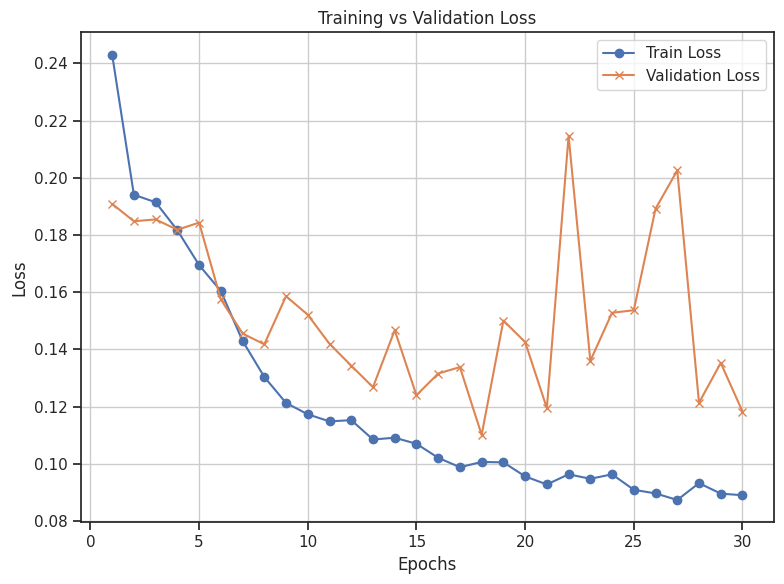

In [190]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [187]:
torch.save(model, '/mnt/nfs/home/liglesias/repos/nnUNet/nnunetv2/training/nnUNetTrainer/autoencoder_model.pth')

In [188]:
torch.save(model.state_dict(), '/mnt/nfs/home/liglesias/repos/nnUNet/nnunetv2/training/nnUNetTrainer/autoencoder_weights.pth')

In [91]:
model_weights = "/mnt/nfs/home/liglesias/cardioTFM/cardioTFM/autoencoder_model.pth"

trained_model = torch.load(model_weights)
trained_model.to("cuda")

model = Autoencoder()
model.load_state_dict(trained_model.state_dict())

model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)

In [ ]:
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 09:57:25,608 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training/patient083_frame08_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 208, 256, 6])
2025-01-25 09:57:26,000 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training/patient098_frame01_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 216, 256, 7])
2025-01-25 09:57:26,284 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training/patient079_frame11_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 216, 256, 9])
2025-01-25 09:57:26,559 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training/patient022_frame01_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 200, 256, 7])
2025-01-25 09:57:26,837 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training/patient030_frame12_gt_reconstructed.nii.gz
Train - Batch 4 - Shape: torch.Size([1, 216, 256, 10])

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.43301284313201904
Input shape: torch.Size([1, 4, 24, 128, 128])
Output shape: torch.Size([1, 4, 24, 128, 128])
Postprocess output shape: torch.Size([1, 1, 24, 128, 128])


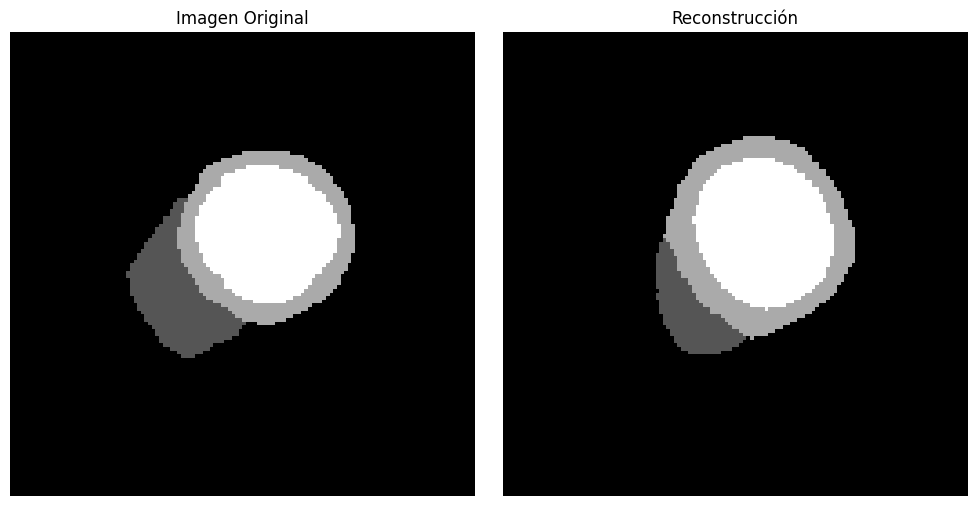

In [ ]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.to(device) 
    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2 
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    
visualize_axial_reconstruction(model, val_loader, device)

In [71]:
training_files = list_nifti_files(training_dir)
training_image =  nib.load(training_files[0]) 
header = training_image.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : 

In [73]:
train_latent_vectors_noise = []
val_latent_vectors_noise = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_noise, desc="Encoding Noisy Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_noise.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_noise, desc="Encoding Noisy Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_noise.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_noise = np.concatenate(val_latent_vectors_noise, axis=0)  

print(f"Train Latent Vectors Shape (Noise): {train_latent_vectors_noise.shape}")
print(f"Validation Latent Vectors Shape (Noise): {val_latent_vectors_noise.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Noisy Validation Images: 100%|██████████| 100/100 [00:06<00:00, 15.73it/s]

Train Latent Vectors Shape (Noise): (200, 64)
Validation Latent Vectors Shape (Noise): (100, 64)


In [77]:
with torch.no_grad():
    for i, batch in enumerate(train_loader_noise):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader_noise):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 10:02:13,837 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_noise/patient090_frame04_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 154, 224, 7])
2025-01-25 10:02:14,326 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_noise/patient036_frame12_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 216, 256, 8])
2025-01-25 10:02:15,056 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_noise/patient043_frame01_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 174, 224, 12])
2025-01-25 10:02:15,431 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_noise/patient072_frame11_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 216, 256, 8])
2025-01-25 10:02:15,905 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_noise/patient078_frame09_gt_reconstructed.nii.gz
Train - Batch 4 - Shape

In [ ]:
train_latent_vectors_sphere = []
val_latent_vectors_sphere = []

model.to(device)

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere, desc="Encoding Sphere Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened) 
        train_latent_vectors_sphere.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere, desc="Encoding Sphere Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened) 
        val_latent_vectors_sphere.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere = np.concatenate(train_latent_vectors_sphere, axis=0)
val_latent_vectors_sphere = np.concatenate(val_latent_vectors_sphere, axis=0)  

print(f"Train Latent Vectors Shape (Sphere): {train_latent_vectors_sphere.shape}")
print(f"Validation Latent Vectors Shape (Sphere): {val_latent_vectors_sphere.shape}")

Encoding Sphere Train Images:   0%|          | 0/200 [00:00<?, ?it/s]

Encoding Sphere Validation Images: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]

Train Latent Vectors Shape (Sphere): (200, 64)
Validation Latent Vectors Shape (Sphere): (100, 64)


In [80]:
with torch.no_grad():
    for i, batch in enumerate(train_loader_sphere):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader_sphere):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 10:08:11,453 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere/patient082_frame07_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 224, 154, 16])
2025-01-25 10:08:11,786 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere/patient086_frame08_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 192, 256, 7])
2025-01-25 10:08:12,089 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere/patient091_frame01_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 180, 224, 8])
2025-01-25 10:08:12,414 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere/patient026_frame01_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 216, 256, 10])
2025-01-25 10:08:12,707 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere/patient072_frame11_gt_reconstructed.nii.gz
Train - Batch 4 -

In [ ]:
train_latent_vectors_sphere_2 = []
val_latent_vectors_sphere_2 = []

model.to(device)

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_2, desc="Encoding Sphere 2 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)
        train_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_2, desc="Encoding Sphere 2 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)
        val_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_2 = np.concatenate(train_latent_vectors_sphere_2, axis=0)
val_latent_vectors_sphere_2 = np.concatenate(val_latent_vectors_sphere_2, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 2): {train_latent_vectors_sphere_2.shape}")
print(f"Validation Latent Vectors Shape (Sphere 2): {val_latent_vectors_sphere_2.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 2 Validation Images: 100%|██████████| 100/100 [00:06<00:00, 16.58it/s]

Train Latent Vectors Shape (Sphere 2): (200, 64)
Validation Latent Vectors Shape (Sphere 2): (100, 64)


In [86]:
with torch.no_grad():
    for i, batch in enumerate(train_loader_sphere_2):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader_sphere_2):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 10:11:46,988 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere_2/patient026_frame12_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 216, 256, 10])
2025-01-25 10:11:47,551 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere_2/patient075_frame06_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 168, 224, 14])
2025-01-25 10:11:47,858 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere_2/patient089_frame01_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 264, 288, 6])
2025-01-25 10:11:48,273 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere_2/patient061_frame01_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 216, 256, 9])
2025-01-25 10:11:48,589 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_sphere_2/patient004_frame15_gt_reconstructed.nii.gz
Train -

In [ ]:
train_latent_vectors_sphere_3 = []
val_latent_vectors_sphere_3 = []

model.to(device)

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_3, desc="Encoding Sphere 3 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened) 
        train_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_3, desc="Encoding Sphere 3 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened) 
        val_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_3 = np.concatenate(train_latent_vectors_sphere_3, axis=0)
val_latent_vectors_sphere_3 = np.concatenate(val_latent_vectors_sphere_3, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 3): {train_latent_vectors_sphere_3.shape}")
print(f"Validation Latent Vectors Shape (Sphere 3): {val_latent_vectors_sphere_3.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 3 Train Images:   0%|          | 0/200 [00:00<?, ?it/s]

Encoding Sphere 3 Validation Images: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]

Train Latent Vectors Shape (Sphere 3): (200, 64)
Validation Latent Vectors Shape (Sphere 3): (100, 64)


In [89]:
with torch.no_grad():
    for i, batch in enumerate(train_loader_sphere_3):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader_sphere_3):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 10:14:11,555 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_dilation/patient085_frame09_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 184, 288, 15])
2025-01-25 10:14:11,872 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_dilation/patient013_frame14_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 216, 256, 10])
2025-01-25 10:14:12,154 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_dilation/patient047_frame09_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 256, 208, 9])
2025-01-25 10:14:12,420 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_dilation/patient091_frame01_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 180, 224, 8])
2025-01-25 10:14:12,708 INFO image_writer.py:197 - writing: reconstructed_masks_testing/masks_training_dilation/patient099_frame09_gt_reconstructed.nii.gz
Train -

In [ ]:
train_latent_vectors_elongated = []
val_latent_vectors_elongated = []

model.to(device) 

with torch.no_grad():
    for batch_data in tqdm(train_loader_elongated, desc="Encoding Elongated Train Images"):
        elongated_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened) 
        train_latent_vectors_elongated.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_elongated, desc="Encoding Elongated Validation Images"):
        elongated_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)
        val_latent_vectors_elongated.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_elongated = np.concatenate(train_latent_vectors_elongated, axis=0)
val_latent_vectors_elongated = np.concatenate(val_latent_vectors_elongated, axis=0)  

print(f"Train Latent Vectors Shape (Elongation): {train_latent_vectors_elongated.shape}")
print(f"Validation Latent Vectors Shape (Elongation): {val_latent_vectors_elongated.shape}")
# print(f"Validation Latent Vectors (Elongation): {val_latent_vectors_noise[0]}")

Encoding Elongated Train Images:   0%|          | 0/200 [00:00<?, ?it/s]

Encoding Elongated Validation Images: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]

Train Latent Vectors Shape (Elongation): (200, 64)
Validation Latent Vectors Shape (Elongation): (100, 64)


In [92]:
with torch.no_grad():
    for i, batch in enumerate(train_loader_elongated):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_training(sample)
            print(f"Train - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

with torch.no_grad():
    for i, batch in enumerate(val_loader_elongated):
        output = model(batch['image'])
        batch['pred'] = output[0]
        embedding = output[1]

        for sample in decollate_batch(batch):
            reconstructed_mask = postprocessing_testing(sample)
            print(f"Validation - Batch {i} - Shape: {reconstructed_mask['pred'].shape}")
        # break

2025-01-25 10:16:30,507 INFO image_writer.py:197 - writing: reconstructed_masks_testing/training_deformation_prueba/patient088_frame12_gt_reconstructed.nii.gz
Train - Batch 0 - Shape: torch.Size([1, 224, 154, 16])
2025-01-25 10:16:30,777 INFO image_writer.py:197 - writing: reconstructed_masks_testing/training_deformation_prueba/patient053_frame01_gt_reconstructed.nii.gz
Train - Batch 1 - Shape: torch.Size([1, 216, 256, 7])
2025-01-25 10:16:31,035 INFO image_writer.py:197 - writing: reconstructed_masks_testing/training_deformation_prueba/patient095_frame12_gt_reconstructed.nii.gz
Train - Batch 2 - Shape: torch.Size([1, 180, 224, 14])
2025-01-25 10:16:31,321 INFO image_writer.py:197 - writing: reconstructed_masks_testing/training_deformation_prueba/patient066_frame11_gt_reconstructed.nii.gz
Train - Batch 3 - Shape: torch.Size([1, 240, 256, 9])
2025-01-25 10:16:31,584 INFO image_writer.py:197 - writing: reconstructed_masks_testing/training_deformation_prueba/patient056_frame01_gt_reconstr

TSV FILES

In [ ]:
train_latent_vectors_array_noise = np.concatenate((last_train_latent_vectors, train_latent_vectors_noise), axis=0)
val_latent_vectors_array_noise = np.concatenate((last_val_latent_vectors, val_latent_vectors_noise), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_noise.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_noise.shape}")

if len(train_latent_vectors_array_noise.shape) == 1:
    train_latent_vectors_array_noise = train_latent_vectors_array_noise.reshape(-1, 1)
if len(val_latent_vectors_array_noise.shape) == 1:
    val_latent_vectors_array_noise = val_latent_vectors_array_noise.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_noise.tsv'), train_latent_vectors_array_noise, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), val_latent_vectors_array_noise, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)
Vectores latentes guardados en /mnt/nfs/home/liglesias


In [ ]:
val_latent_vectors_df_noise = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_noise.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_noise.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_noise.iloc[:100]
val_latent_vectors_noise_df = val_latent_vectors_df_noise.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_noise_df)

metadata_noise = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere'] * num_noise
}
metadata_df_noise = pd.DataFrame(metadata_noise)

metadata_df_noise.to_csv(os.path.join(output_dir, 'metadata_noise.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_noise.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_noise.tsv


In [ ]:
train_latent_vectors_array_sphere = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere), axis=0)
val_latent_vectors_array_sphere = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere.shape}")

if len(train_latent_vectors_array_sphere.shape) == 1:
    train_latent_vectors_array_sphere = train_latent_vectors_array_sphere.reshape(-1, 1)
if len(val_latent_vectors_array_sphere.shape) == 1:
    val_latent_vectors_array_sphere = val_latent_vectors_array_sphere.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere.tsv'), train_latent_vectors_array_sphere, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere.tsv'), val_latent_vectors_array_sphere, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)
Vectores latentes guardados en /mnt/nfs/home/liglesias


In [ ]:
val_latent_vectors_df_sphere = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere.iloc[:100]
val_latent_vectors_sphere_df = val_latent_vectors_df_sphere.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_df)

metadata_sphere = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere'] * num_noise
}
metadata_df_sphere = pd.DataFrame(metadata_sphere)

metadata_df_sphere.to_csv(os.path.join(output_dir, 'metadata_sphere.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere.tsv


In [ ]:
train_latent_vectors_array_sphere_2 = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere_2), axis=0)
val_latent_vectors_array_sphere_2 = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere_2), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere_2.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere_2.shape}")

if len(train_latent_vectors_array_sphere_2.shape) == 1:
    train_latent_vectors_array_sphere_2 = train_latent_vectors_array_sphere_2.reshape(-1, 1)
if len(val_latent_vectors_array_sphere_2.shape) == 1:
    val_latent_vectors_array_sphere_2 = val_latent_vectors_array_sphere_2.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere_2.tsv'), train_latent_vectors_array_sphere_2, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere_2.tsv'), val_latent_vectors_array_sphere_2, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)


Vectores latentes guardados en /mnt/nfs/home/liglesias


In [ ]:
val_latent_vectors_df_sphere_2 = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere_2.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere_2.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere_2.iloc[:100]
val_latent_vectors_sphere_2_df = val_latent_vectors_df_sphere_2.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_2_df)

metadata_sphere_2 = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere_2'] * num_noise
}
metadata_df_sphere_2 = pd.DataFrame(metadata_sphere_2)

metadata_df_sphere_2.to_csv(os.path.join(output_dir, 'metadata_sphere_2.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere_2.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere_2.tsv


In [ ]:
train_latent_vectors_array_sphere_3 = np.concatenate((last_train_latent_vectors, train_latent_vectors_sphere_3), axis=0)
val_latent_vectors_array_sphere_3 = np.concatenate((last_val_latent_vectors, val_latent_vectors_sphere_3), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array_sphere_3.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array_sphere_3.shape}")

if len(train_latent_vectors_array_sphere_3.shape) == 1:
    train_latent_vectors_array_sphere_3 = train_latent_vectors_array_sphere_3.reshape(-1, 1)
if len(val_latent_vectors_array_sphere_3.shape) == 1:
    val_latent_vectors_array_sphere_3 = val_latent_vectors_array_sphere_3.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors_sphere_3.tsv'), train_latent_vectors_array_sphere_3, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors_sphere_3.tsv'), val_latent_vectors_array_sphere_3, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)


Vectores latentes guardados en /mnt/nfs/home/liglesias


In [ ]:
val_latent_vectors_df_sphere_3 = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors_sphere_3.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df_sphere_3.shape}")

val_latent_vectors_original_df = val_latent_vectors_df_sphere_3.iloc[:100]
val_latent_vectors_sphere_3_df = val_latent_vectors_df_sphere_3.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_sphere_3_df)

metadata_sphere_3 = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Sphere_3'] * num_noise
}
metadata_df_sphere_3 = pd.DataFrame(metadata_sphere_3)

metadata_df_sphere_3.to_csv(os.path.join(output_dir, 'metadata_sphere_3.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata_sphere_3.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata_sphere_3.tsv


DIMENSIONALITY REDUCTION

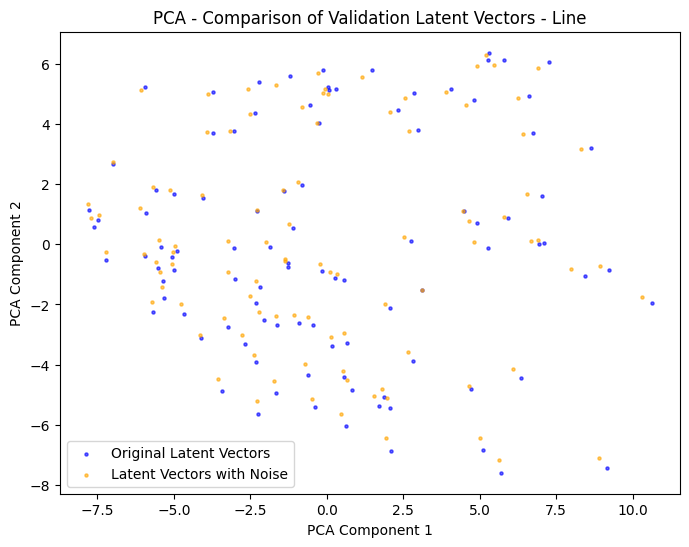

In [93]:
from sklearn.decomposition import PCA
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Line')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

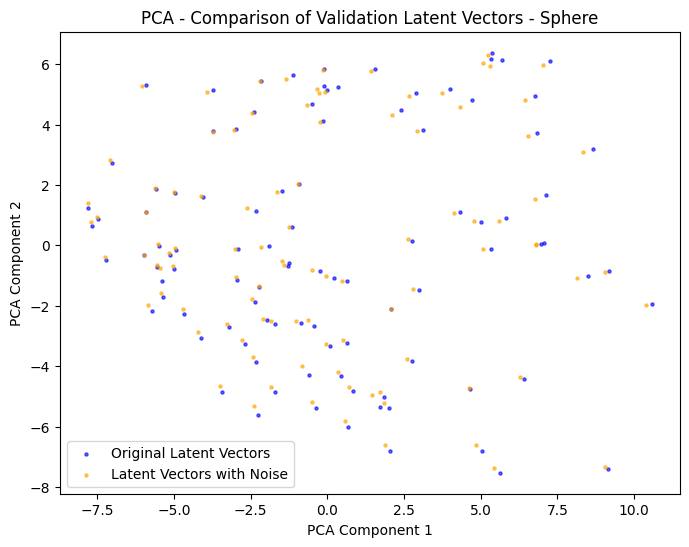

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

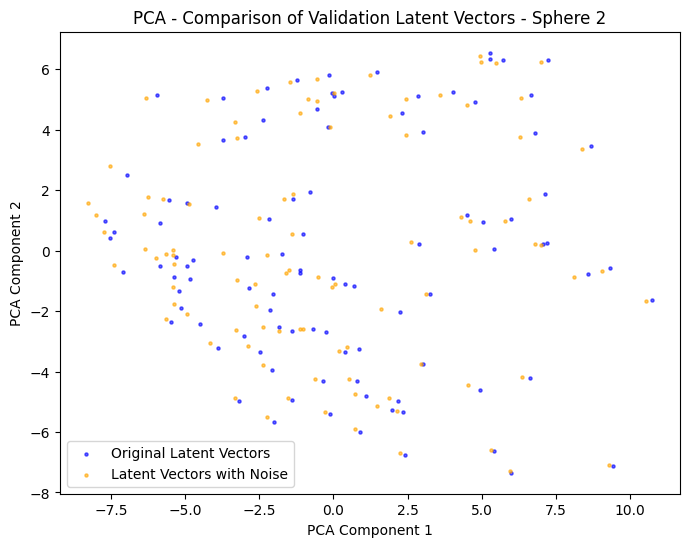

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

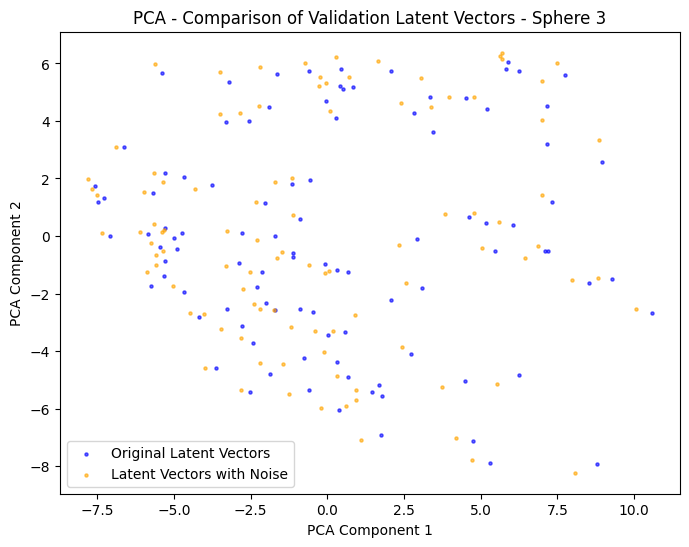

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 3')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

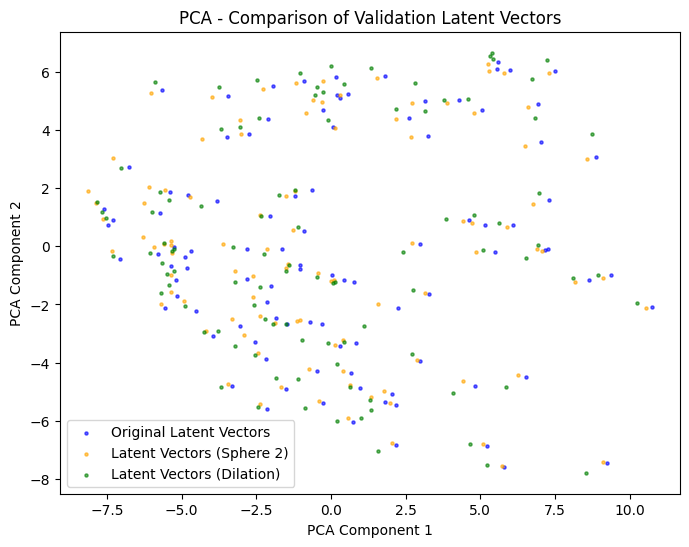

In [ ]:
# PCA with 3 components (original, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

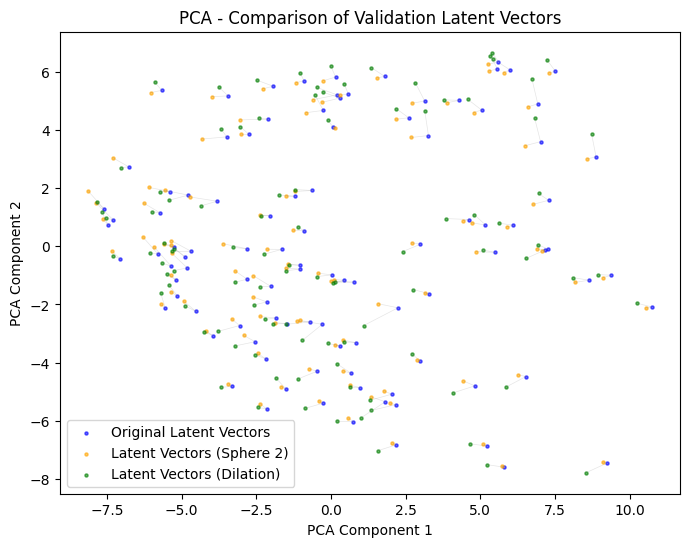

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 100, 0]], 
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 200, 0]],
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

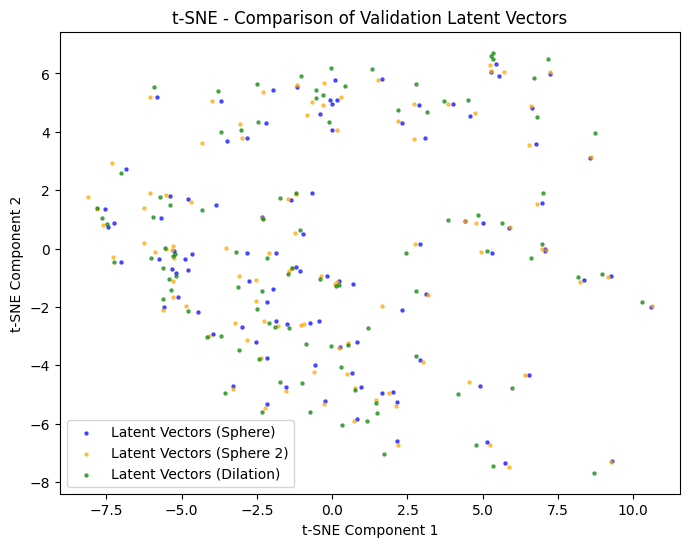

In [ ]:
# t-sne with three components (sphere, sphere_2 y sphere_3)

from sklearn.manifold import TSNE

all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

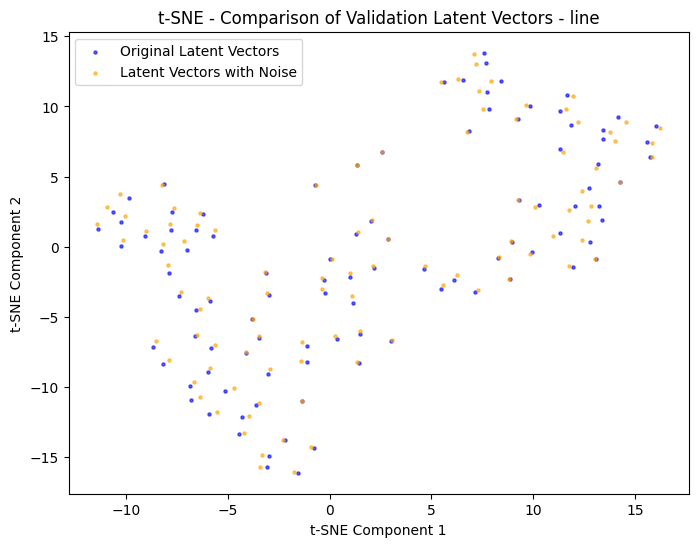

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors - line')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

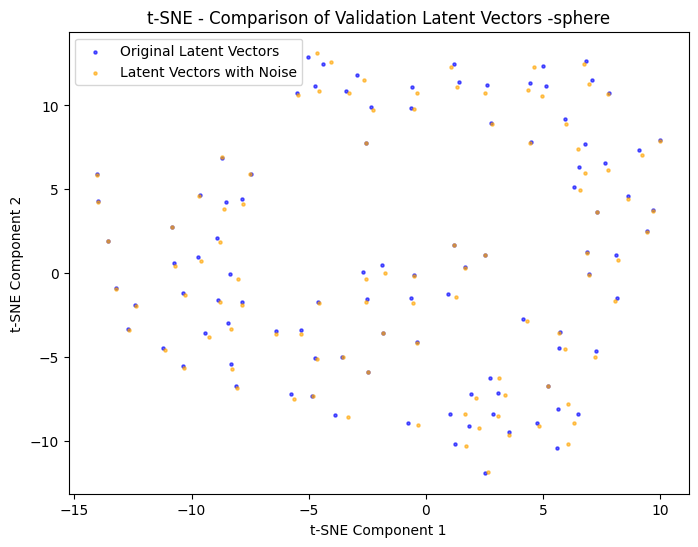

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

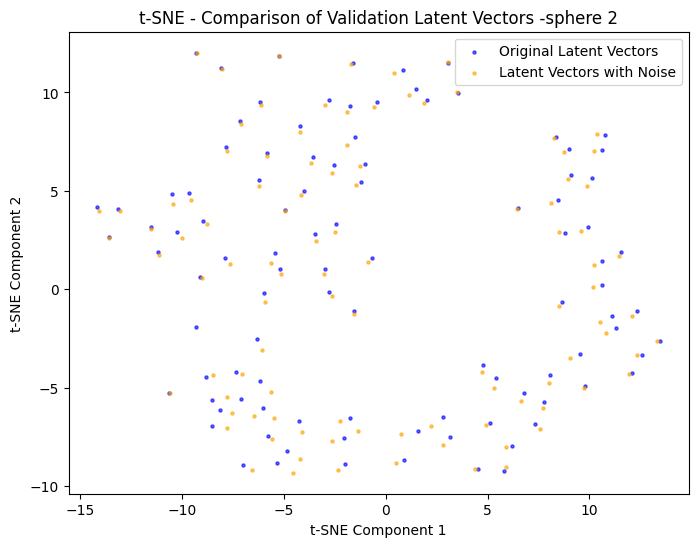

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

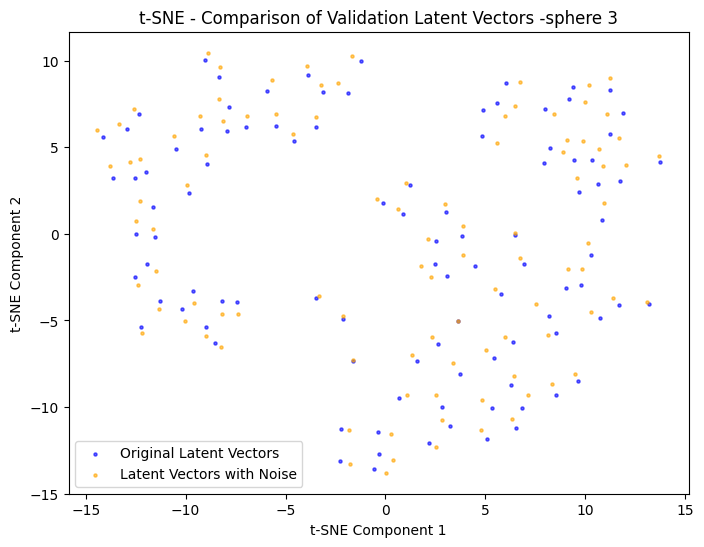

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

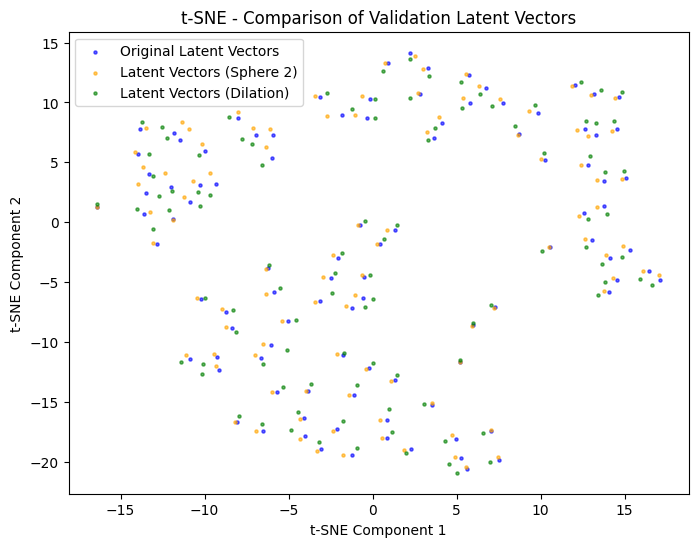

In [ ]:
# t-sne with 3 components (original, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

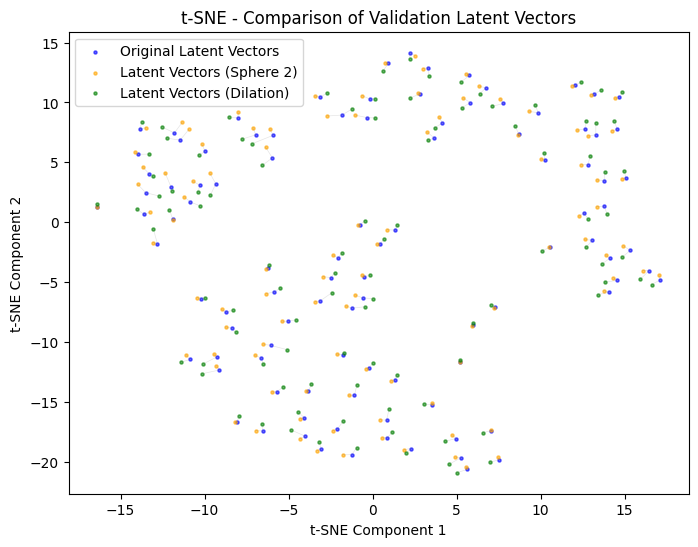

In [105]:
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_tsne[i, 0], all_val_latent_vectors_tsne[i + 100, 0]], 
             [all_val_latent_vectors_tsne[i, 1], all_val_latent_vectors_tsne[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_tsne[i, 0], all_val_latent_vectors_tsne[i + 200, 0]],
             [all_val_latent_vectors_tsne[i, 1], all_val_latent_vectors_tsne[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

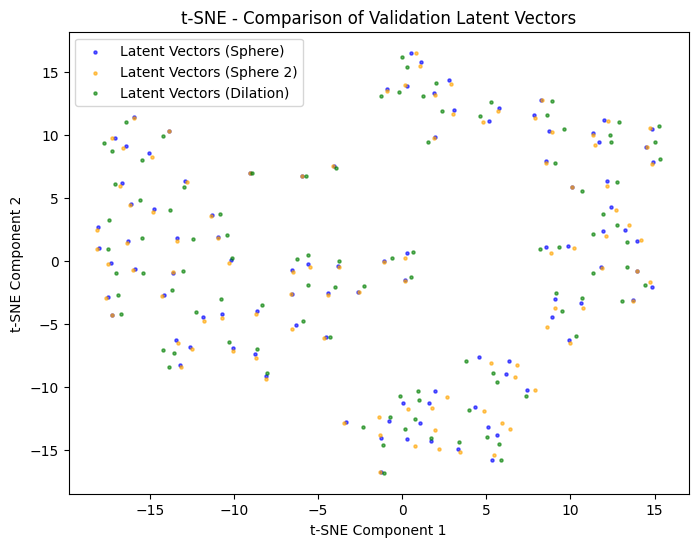

In [ ]:
# t-sne with 3 components (sphere, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


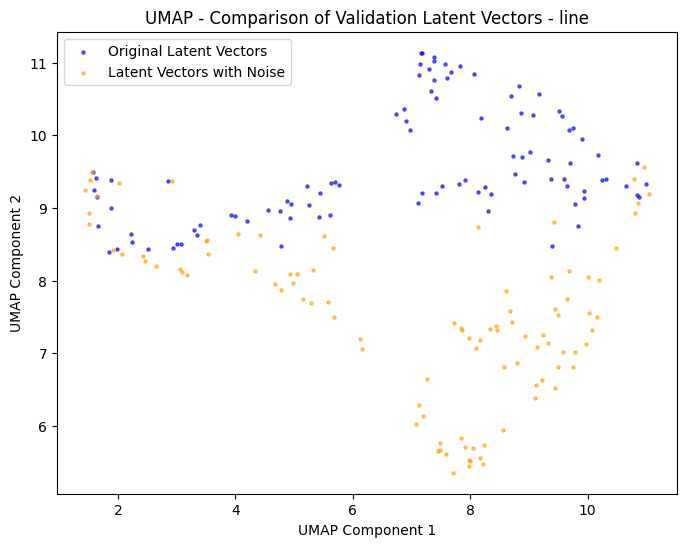

In [107]:
# UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - line')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


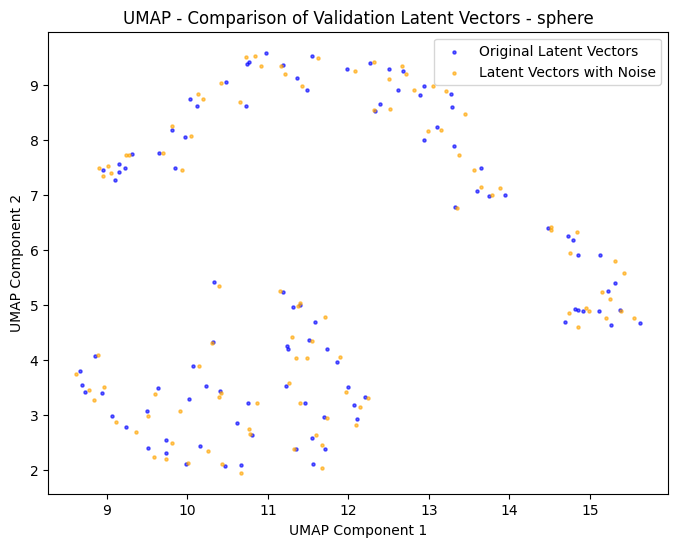

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


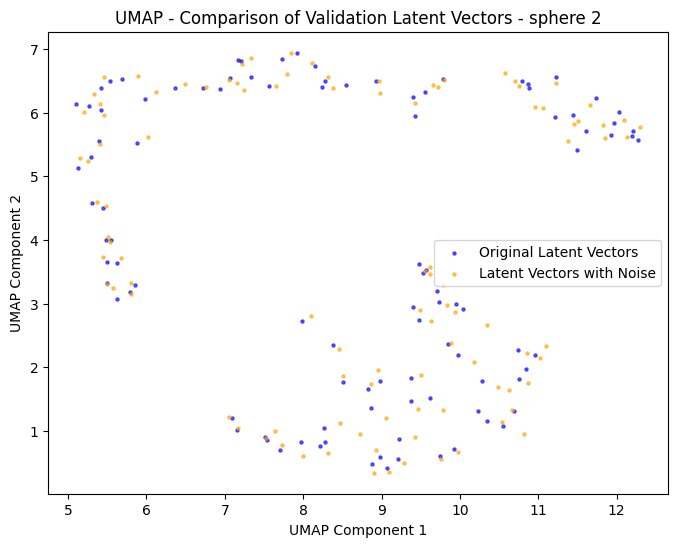

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 2')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


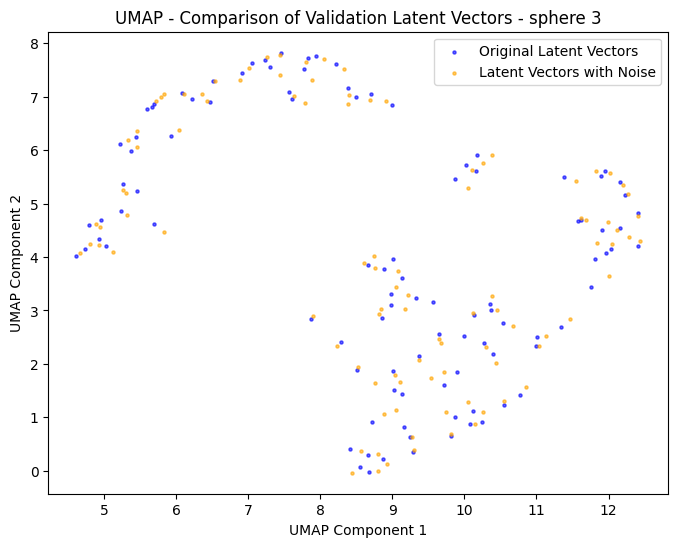

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 3')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


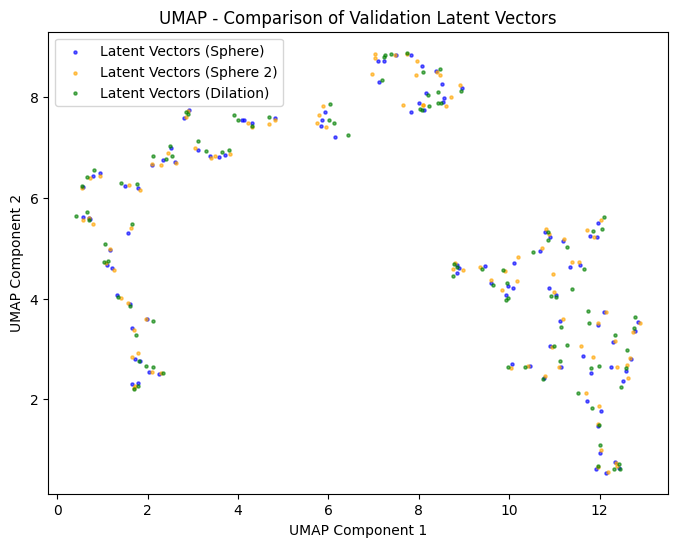

In [ ]:
# umap with 3 components (sphere, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([val_latent_vectors_sphere, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Latent Vectors (Sphere)')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

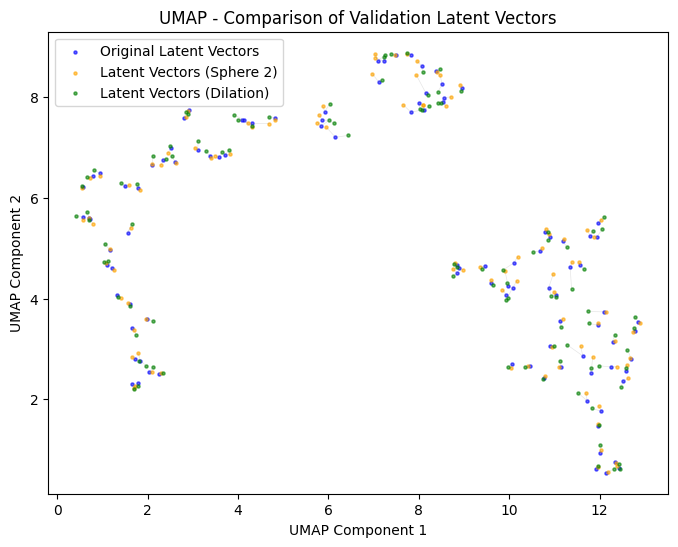

In [112]:
plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_umap[i, 0], all_val_latent_vectors_umap[i + 100, 0]], 
             [all_val_latent_vectors_umap[i, 1], all_val_latent_vectors_umap[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_umap[i, 0], all_val_latent_vectors_umap[i + 200, 0]],
             [all_val_latent_vectors_umap[i, 1], all_val_latent_vectors_umap[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


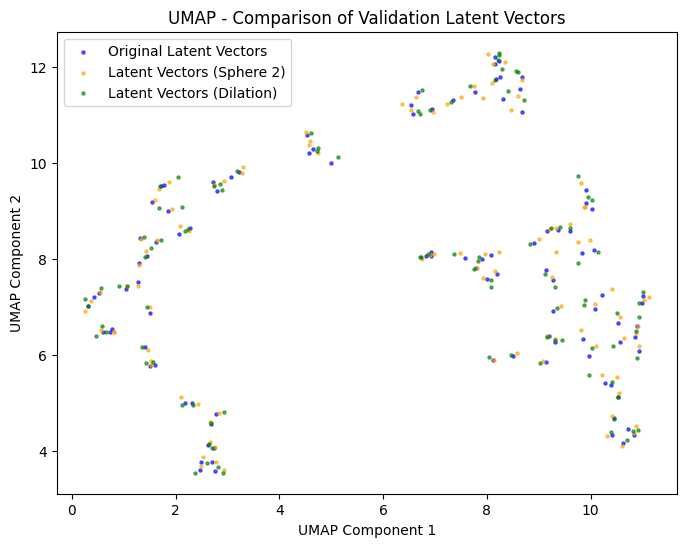

In [ ]:
# umap with three components (original, sphere_2 y sphere_3)

all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Sphere 2)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Dilation)')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

EUCLIDEAN DISTANCE

In [114]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with noise

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.8222122  0.80188406 0.63879013 0.49008602 0.91246426 0.90201193
 0.8593501  0.5544293  0.71522427 0.5627775  0.78302276 0.7843206
 0.7079169  0.4244384  0.6108539  0.49137777 0.5666951  0.3967295
 0.5921223  0.5199652  0.6484019  0.57927287 0.8904802  0.8123972
 0.89741904 0.92018795 0.1982313  0.58942604 0.56551594 0.7299235
 0.7606517  0.6500725  0.9769563  0.92185646 0.7706818  0.73036283
 0.56548613 0.47017387 0.25785586 0.48041862 0.62398505 0.22062667
 0.8405716  1.0930803  0.5312505  0.43095544 0.74262434 0.8298233
 1.3215605  0.5005072  0.57913035 0.4693522  0.6732019  0.68302906
 0.82897687 0.66451675 0.806431   0.5707425  0.27596703 0.41490617
 0.8275745  0.89465666 0.77000713 0.7186216  0.9209316  0.8870292
 0.6308391  0.4526283  1.5007516  1.4966435  0.9538559  0.97391474
 0.81210476 0.742076   0.70708114 0.54920983 0.7849059  0.6562854
 0.0242804

In [115]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.3771385  0.27357543 0.8130284  0.4644431  0.2353352  0.15569559
 0.44801363 0.02118179 0.39874783 0.09937051 0.57598907 0.5363723
 0.6011304  0.29394674 0.3542902  0.21544643 0.68775564 0.3879361
 0.44449168 0.19004709 0.3134444  0.         0.3432699  0.18089731
 0.5142371  0.4311184  0.10711195 0.         0.38593835 0.21020903
 0.32454625 0.11468947 0.28689507 0.2676311  0.37490755 0.2208166
 0.26827922 0.14378467 0.13430297 0.13621362 0.6755792  0.34257847
 0.73665583 0.56830114 0.31808615 0.15982012 0.16305749 0.04262392
 0.3341372  0.19993144 0.3159948  0.23488371 0.33564    0.23917562
 0.5099704  0.36387318 0.33420953 0.16344371 0.219154   0.06344244
 0.40699017 0.39861432 0.3960693  0.38912305 0.3451767  0.26417723
 0.2529676  0.14799334 0.569952   0.41254157 0.48840493 0.29187205
 0.47062925 0.63408107 0.3070074  0.06588037 0.33991143 0.21495302
 0.38

In [116]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.6566166  0.9294569  0.49432257 1.479845   1.1456957  1.257062
 0.6773769  1.1681668  0.54907256 1.0775853  0.42913392 0.5701308
 0.4424195  0.94088167 0.7128974  1.0949812  0.5827513  1.0366008
 0.7133406  1.3055996  0.9922403  1.3150696  0.38757992 0.7439307
 0.67575634 0.9905838  1.1069455  1.1469684  0.3080146  0.6282416
 0.73866254 1.2381917  0.5516327  0.7341625  0.66714907 0.94118845
 0.4059089  0.6197156  0.81335735 0.5558119  0.6209677  1.4172654
 1.0351046  1.1531396  0.66470903 1.369682   0.42021284 0.7113543
 0.39925745 0.53208035 0.30809134 0.50820565 0.3711631  0.5776271
 0.4459555  0.89304256 0.23116253 0.61006886 0.6326423  0.88178796
 0.4465906  0.49628606 0.41017112 0.43635824 0.6199317  0.7819913
 0.72233814 1.4292328  0.8753796  1.0510669  0.58466154 0.9323708
 0.5279942  0.6140547  0.698937   1.2048825  0.27752605 0.60579497
 0.28502065

In [117]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.4354211  1.4628935  1.1703315  1.2617937  1.7677828  1.4584852
 2.1017416  1.4747595  1.4679033  1.4056419  1.4267648  1.5340092
 0.8996052  1.0456512  1.989611   1.5240647  1.259152   1.3940119
 1.2888663  1.5562356  1.3013465  0.97439384 1.4884975  1.2696335
 1.402847   1.4752871  1.412936   1.7654244  1.4348737  1.5430964
 1.9699227  1.6408248  1.787178   1.9108611  1.4132587  1.4756927
 1.0003039  1.147028   1.3386029  1.7424592  1.2782148  1.5198123
 1.7088631  1.625097   1.0392306  1.110257   1.1615922  1.4534755
 0.9348646  1.1908991  0.9034161  0.8766487  1.155561   1.1382409
 1.0788485  1.5174538  1.3797686  1.3532976  1.2643769  1.3482679
 1.1625416  1.3536688  1.5322669  1.4224397  1.8939893  1.8552467
 1.5252532  1.7588156  2.112571   1.8902241  1.5961063  1.4980645
 1.3044133  1.3213642  1.3945204  1.3108172  1.1557645  1.3110733
 1.2486558  1

In [118]:
# Euclidean distance between the latent vectors of the last epoch and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.7521992  1.5131706  1.2724177  1.336741   1.100887   1.2252113
 1.31716    1.9210556  1.395288   1.174452   0.7737814  1.6616479
 1.1708302  1.6759105  1.6156713  1.6185396  1.9969682  1.8655641
 1.1371415  1.1983699  1.6046472  1.2182758  1.2840605  0.59437424
 1.2389624  1.9681951  1.6354548  1.0225109  0.6741111  0.98972225
 2.2948678  1.6236715  2.600088   1.7390317  2.2584414  0.53147775
 2.0720754  1.100667   0.7504156  0.9818724  3.065901   1.0497719
 2.415453   1.0068072  0.5802293  1.5340364  2.326356   1.1008456
 1.6311163  1.1789235  1.669496   0.7958735  2.0859504  1.3054339
 2.0449603  1.601857   1.128175   1.2143822  2.6619198  1.7286131
 1.5349077  0.912637   1.1422915  2.489156   4.2174196  2.6375215
 1.6707258  1.1566731  2.358131   2.0783727  2.388266   3.2622166
 1.3348192  1.135572   1.9831287  0.9799837  1.6731815  0.93156075
 2.50095



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



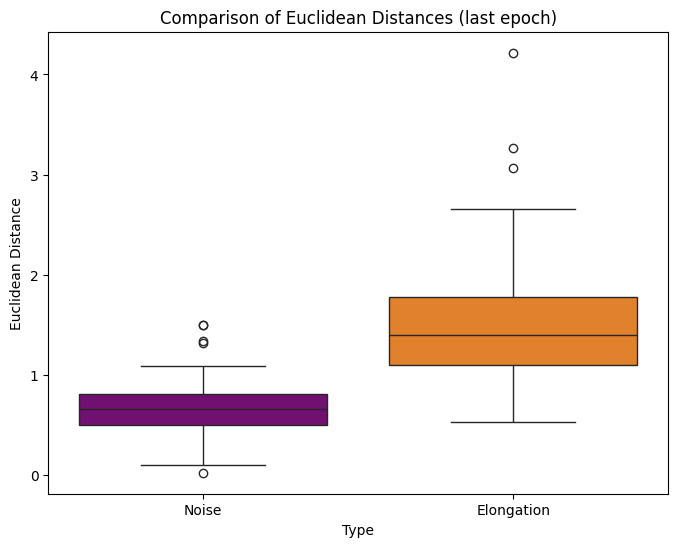

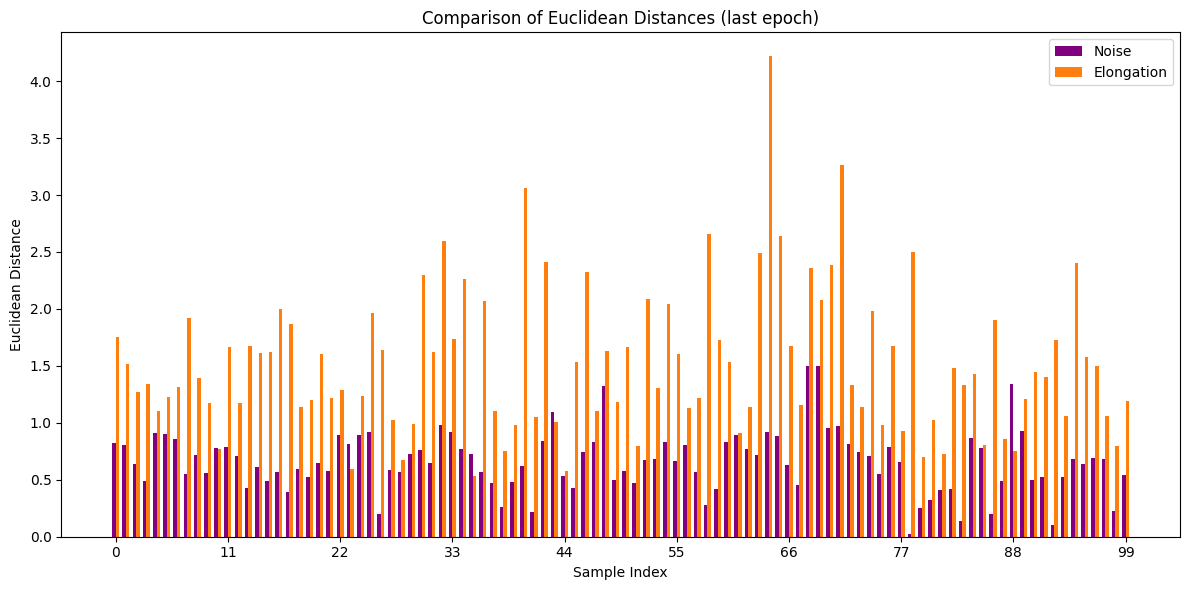

In [120]:
euclidean_distances_noise = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise) + list(euclidean_distances_elongated),
    'Type': ['Noise'] * len(euclidean_distances_noise) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

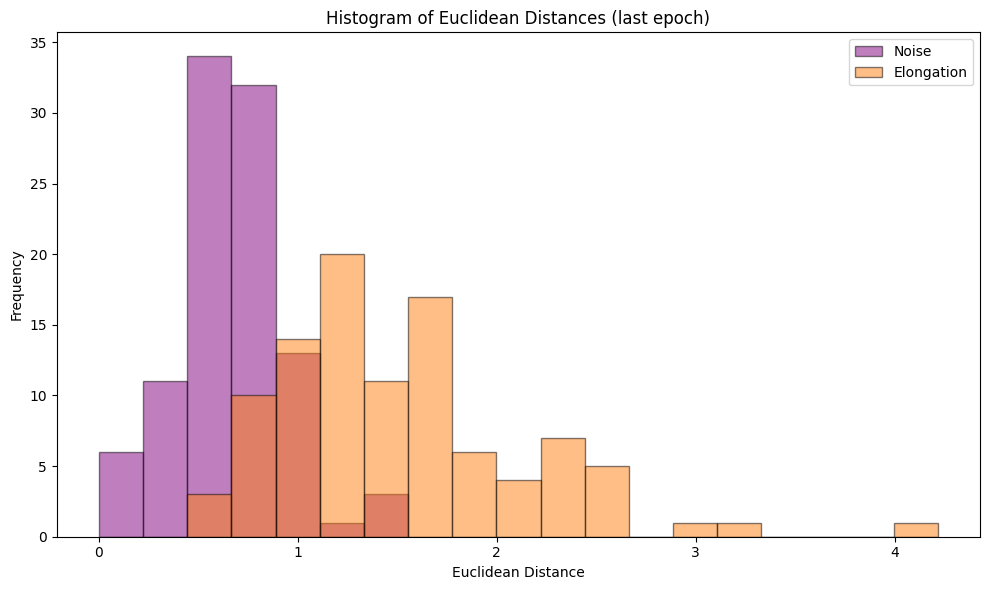

In [121]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

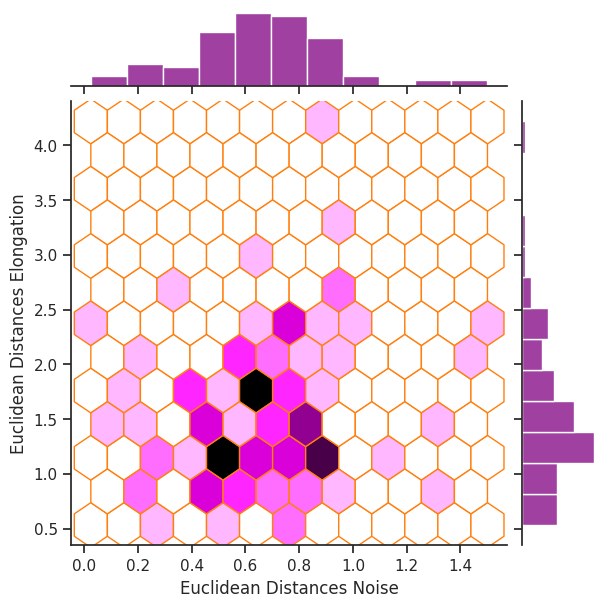

In [122]:
x = euclidean_distances_noise
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



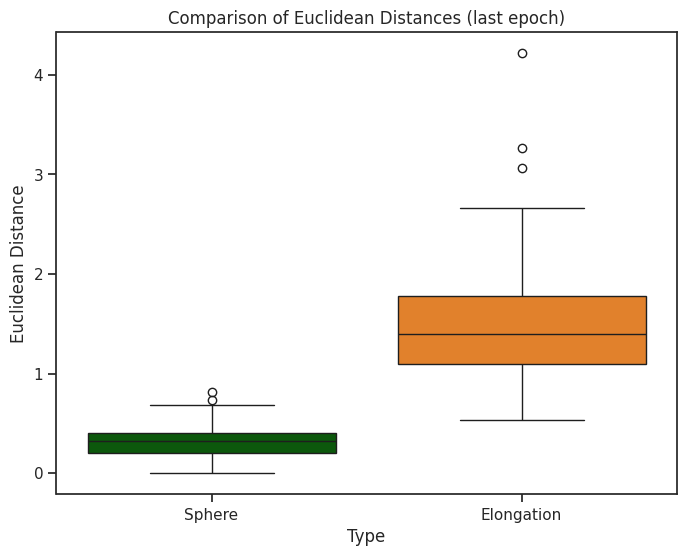

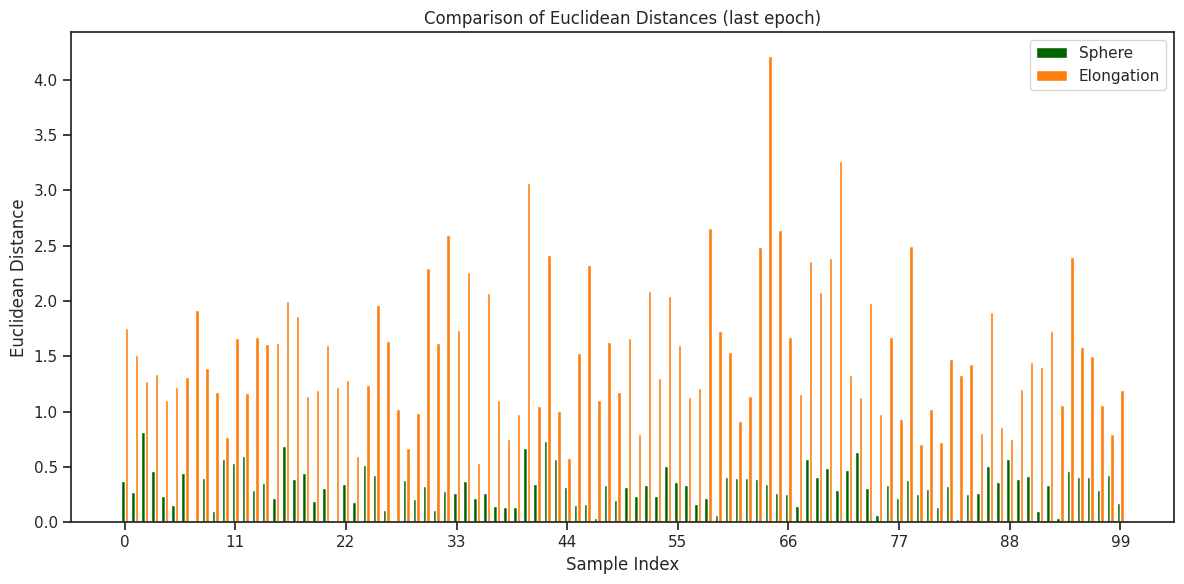

In [123]:
euclidean_distances_sphere = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere) + list(euclidean_distances_elongated),
    'Type': ['Sphere'] * len(euclidean_distances_sphere) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

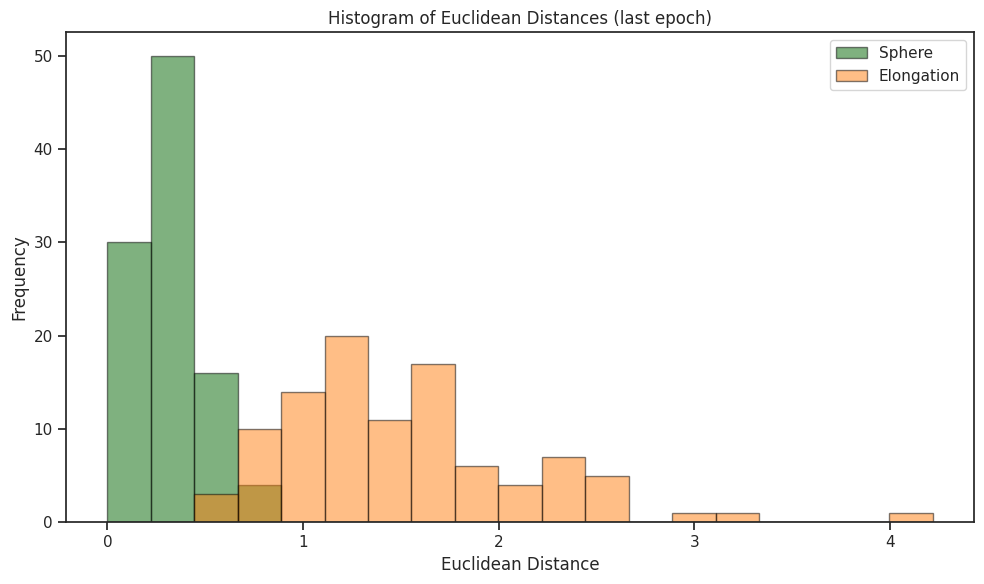

In [124]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

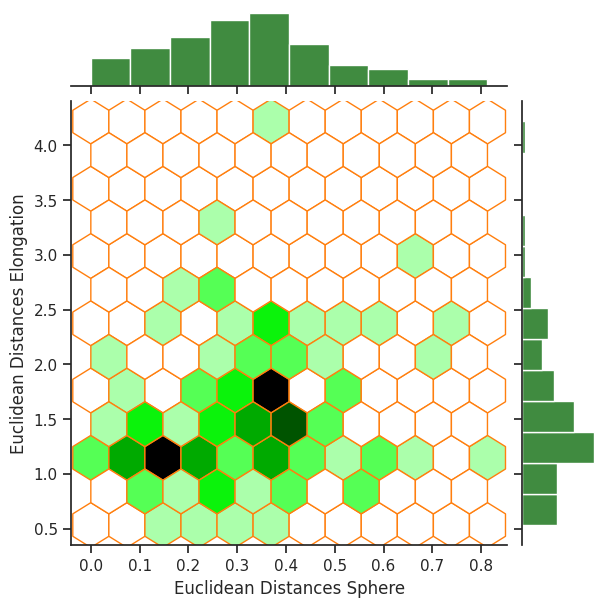

In [ ]:
x = euclidean_distances_sphere
y = euclidean_distances_elongated

sns.set_theme(style="ticks")

g = sns.jointplot(x=x, y=y, kind="hex", color="#006400") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Sphere')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



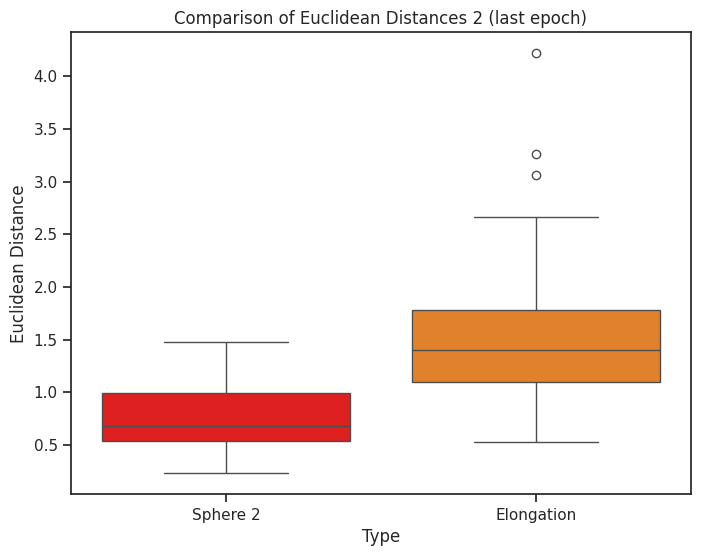

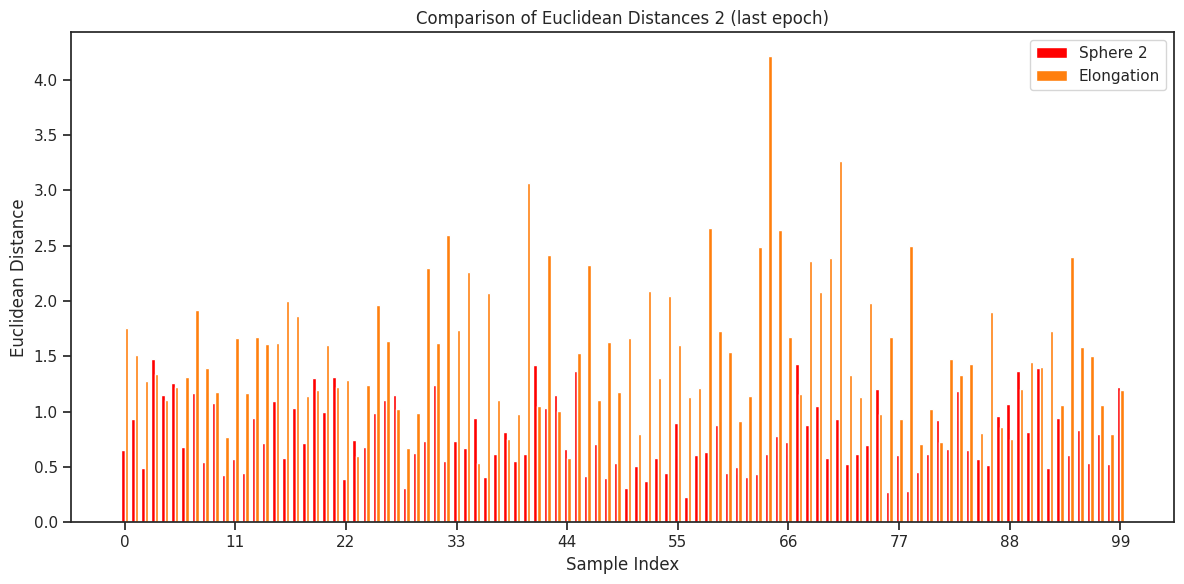

In [126]:
euclidean_distances_sphere_2 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2) + list(euclidean_distances_elongated),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 2 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 2 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

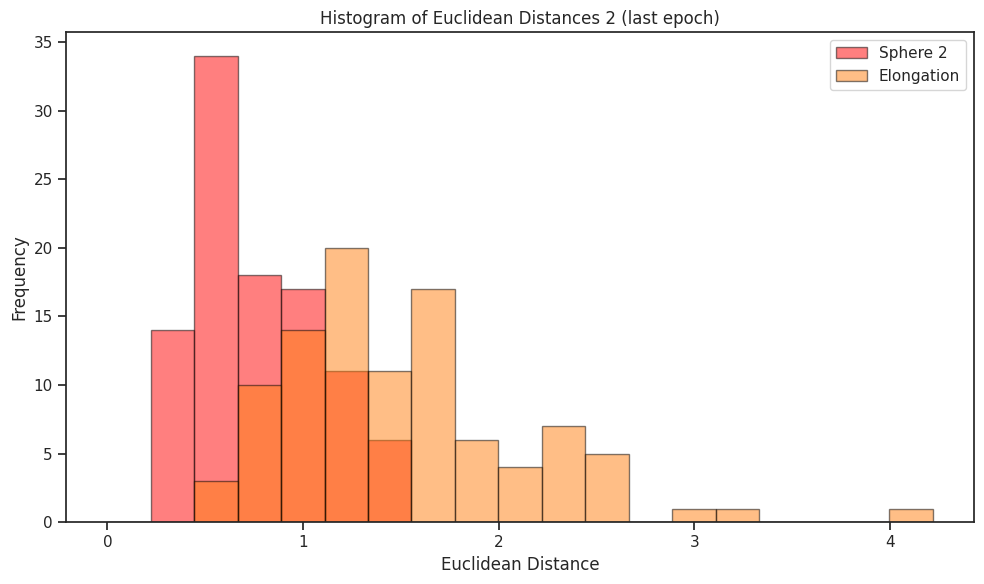

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_2), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 2 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

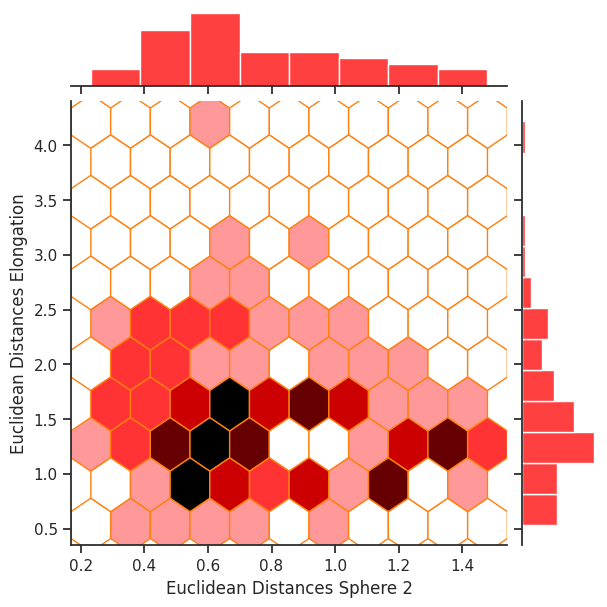

In [128]:
x = euclidean_distances_sphere_2
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#FF0000") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



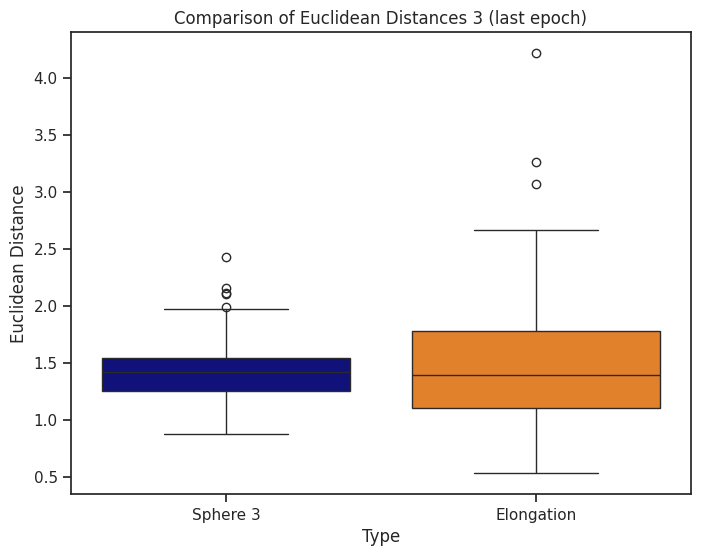

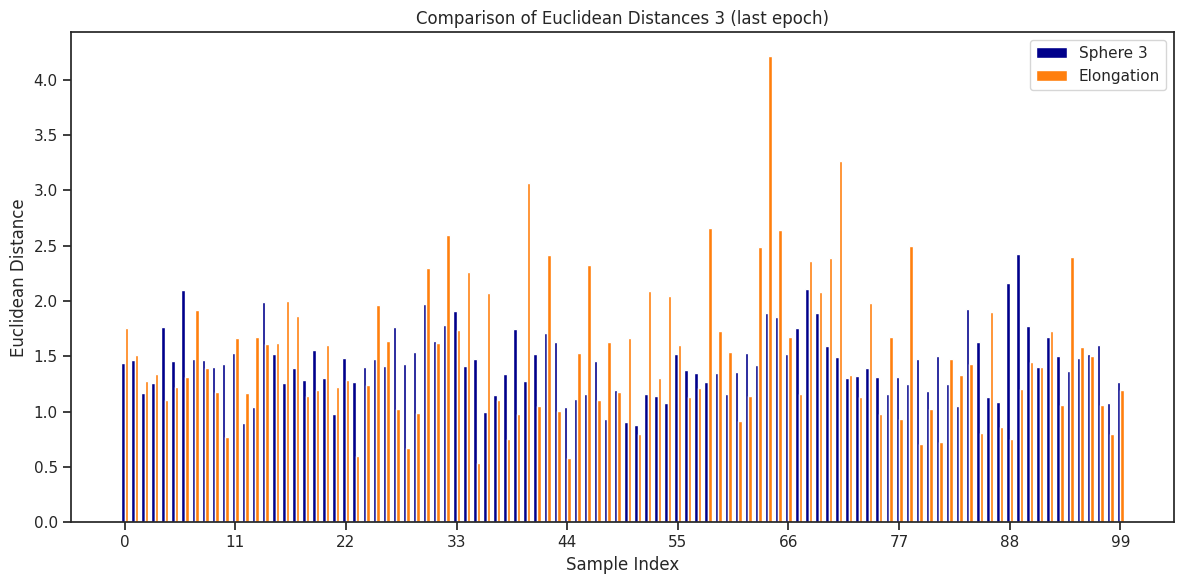

In [129]:
euclidean_distances_sphere_3 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3) + list(euclidean_distances_elongated),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 3 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 3 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

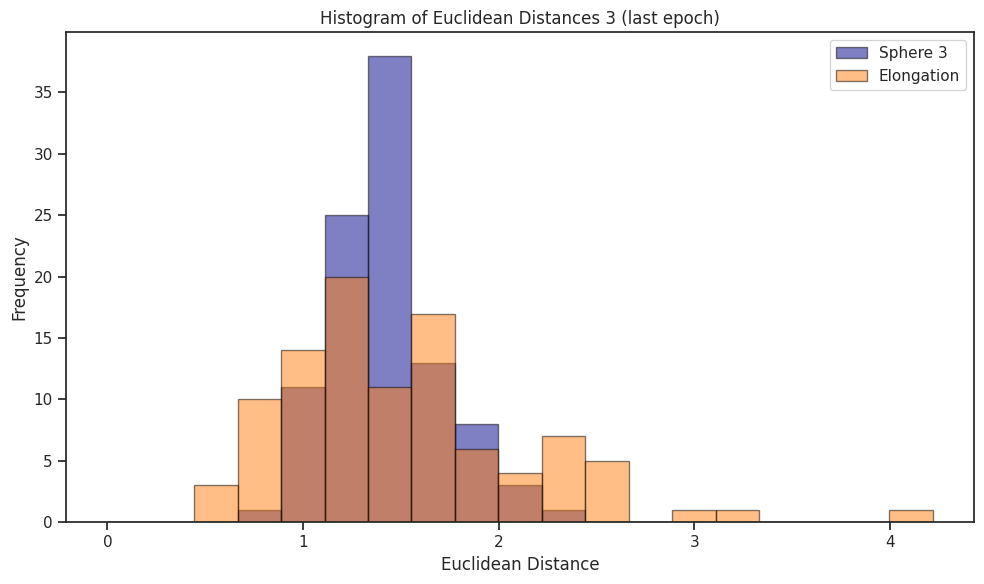

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_3), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 3 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

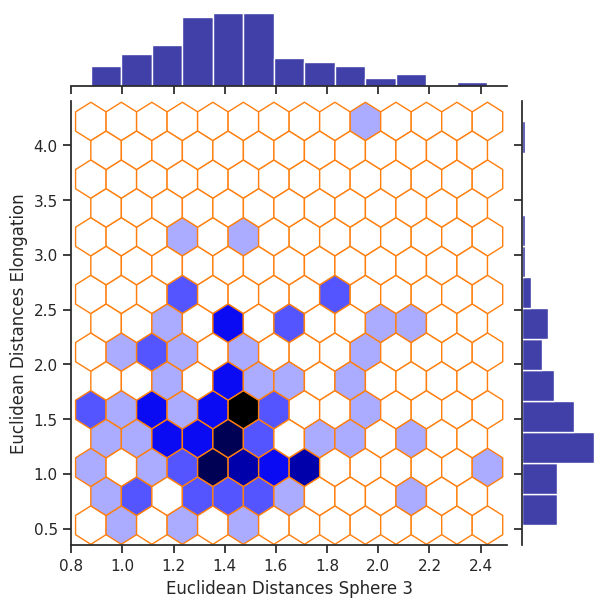

In [131]:
x = euclidean_distances_sphere_3
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3')
plt.ylabel('Euclidean Distances Elongation')
plt.show()

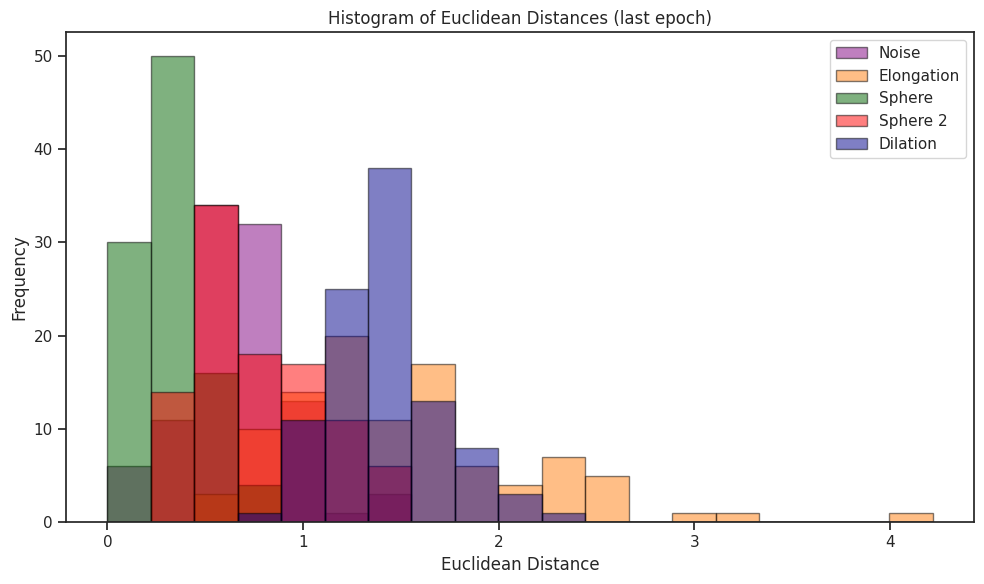

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), 
                          np.max(euclidean_distances_elongated), 
                          np.max(euclidean_distances_sphere), 
                          np.max(euclidean_distances_sphere_2), 
                          np.max(euclidean_distances_sphere_3)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



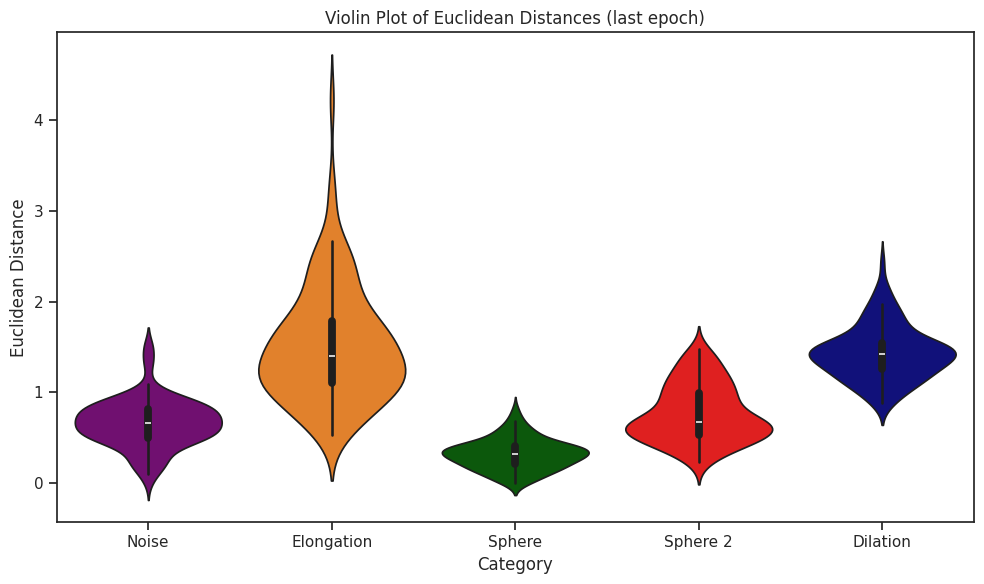

In [133]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})
plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

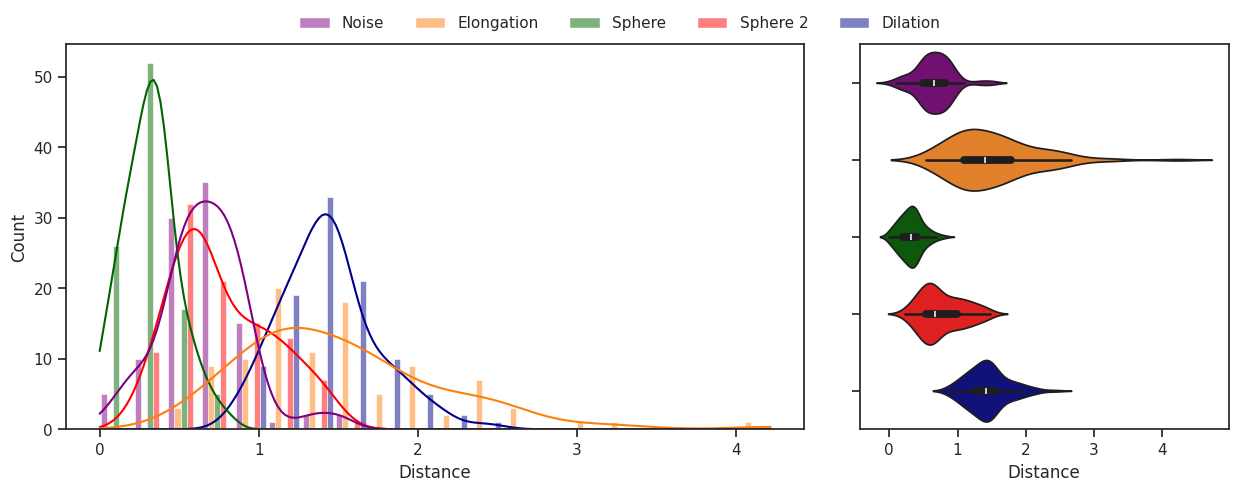

In [ ]:
data = {
    'Distance': np.concatenate([
        euclidean_distances_noise, 
        euclidean_distances_elongated, 
        euclidean_distances_sphere, 
        euclidean_distances_sphere_2, 
        euclidean_distances_sphere_3
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Sphere': '#006400',      
    'Sphere 2': '#FF0000',    
    'Dilation': '#00008B'     
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



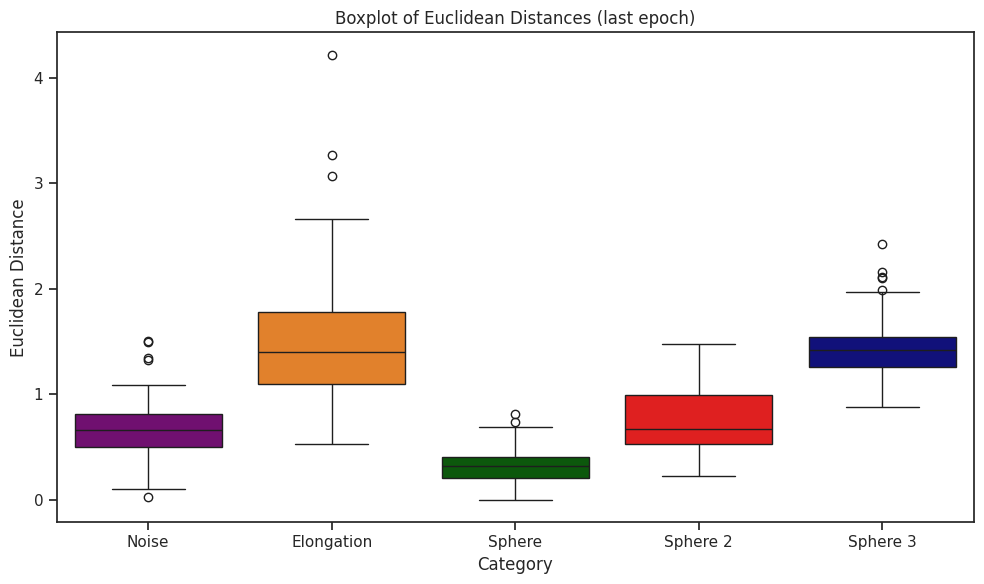

In [135]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Sphere 3'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Sphere 3': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Boxplot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

EUCLICEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCH WITH BEST DICE

In [136]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.307338  3.275154  4.207526  4.6165876 3.595809  3.5307622 3.486764
 4.007172  3.820977  4.43676   3.3568864 3.2300298 3.9496984 4.1889696
 3.3286662 4.4132824 3.487687  4.0302906 4.067065  4.192974  3.9374874
 4.150694  3.715604  3.6217682 3.682167  3.3532481 2.5304816 2.916386
 3.8672397 3.8668053 3.6552851 3.7777905 3.010631  2.3946075 3.852363
 3.5798678 4.702489  4.4926853 3.1528475 3.3491478 4.22137   4.4684124
 4.185456  4.1726832 4.2656507 4.3624377 3.949494  4.037689  4.003547
 4.6379113 5.254818  5.1865206 4.536194  4.7108765 4.5921736 4.314299
 4.670002  4.312815  3.8955681 4.078088  3.8314652 3.8700557 3.7055933
 3.8716402 3.1313777 2.91926   3.6886098 4.2260447 3.4889634 3.3965347
 3.5694742 3.3106792 3.3558347 3.568002  3.8981793 3.9049237 4.4169965
 4.8991804 4.2021675 4.395805  4.5392566 4.861989  4.057681  4.522484
 2.6380398 2.926745  4.00124

In [137]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.343115  3.2227027 4.159272  4.5788217 3.6029983 3.5206122 3.3770313
 3.8030837 3.693129  4.295316  3.2685182 3.1621003 3.8684824 4.118945
 3.2780533 4.3100214 3.3355699 3.8957615 3.8590052 4.0821133 3.7201753
 3.8752313 3.769     3.4673648 3.9614584 3.5619435 2.5249267 2.8007324
 3.8889184 3.7257519 3.5348687 3.6686692 3.2660139 2.6743135 3.8183675
 3.4594665 4.5086384 4.296251  3.207101  3.3100395 4.0441165 4.3495574
 4.1931634 4.0820227 4.077021  4.2523127 3.973745  3.944477  3.9415886
 4.5817947 5.2304635 5.0600863 4.3971043 4.5341573 4.592588  4.218979
 4.5293183 4.0712566 3.9851727 4.018531  3.995708  3.9816856 3.6558208
 3.762542  3.2536614 3.044672  3.4219916 4.0232143 3.5524895 3.3580394
 3.9375863 3.3841267 3.3009062 3.480073  3.6863546 3.684774  4.3883166
 4.839072  4.182908  4.285743  4.4611893 4.807354  3.9961748 4.488399
 2.6817067 2.928106  4.01

In [138]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.6212199 3.6356988 4.2461977 5.259382  4.018503  4.1251225 3.6301327
 4.2606826 3.8548312 4.7366977 3.3294265 3.3023374 3.9765806 4.2922306
 3.6376252 4.7494054 3.43997   4.1214213 4.068399  4.501221  4.13385
 4.42549   3.9284503 3.7747705 4.037963  3.7483726 2.7108629 3.158297
 3.963362  3.9515224 3.797322  4.300099  3.2870488 2.8443289 3.980436
 3.7184446 4.6460867 4.4146404 3.2634592 3.4820032 4.074491  4.428865
 4.68057   4.5807405 4.289335  4.7551875 4.063868  4.140481  4.034015
 4.6896634 5.247959  5.1628923 4.489358  4.712498  4.715894  4.549938
 4.5815587 4.2501607 4.1554685 4.378244  4.123804  4.1195626 3.7882967
 3.8704531 3.3027294 3.0472794 3.545941  4.244204  3.8499434 3.9006476
 4.014183  3.692213  3.4814873 3.7568464 3.9763377 4.147046  4.435961
 5.1063137 4.297359  4.4179006 4.663221  5.004044  4.1465387 5.0103183
 2.9284887 3.1784842 4.139209 

In [139]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.725345  3.5929766 4.585022  5.037987  3.9183106 3.6264884 3.8948538
 4.2561874 4.1984525 4.825227  3.9216313 3.8056154 4.0765967 4.513825
 4.278522  4.925623  3.8318796 4.6126275 4.509819  4.826523  4.3274684
 4.177483  3.9663515 3.836885  4.0440316 3.80195   2.7537038 3.1978986
 4.317557  4.4408603 4.421172  4.338147  3.4230888 2.6674109 4.1970677
 3.9865298 5.0071583 4.9363656 3.4166918 3.7851565 4.576947  5.2254133
 4.599136  4.493508  4.623768  4.7826867 4.1348147 4.3297973 3.9614217
 4.8265634 5.5004287 5.4327416 4.9146137 5.013974  4.836244  4.7777214
 5.0211415 4.7026663 4.160211  4.4254575 4.1212955 4.2292533 3.8591821
 3.9749372 3.3352509 3.0700989 4.289032  5.101027  3.897312  3.7058492
 4.248424  3.8286052 3.773517  3.9411945 4.2896523 4.262032  4.7371964
 5.253151  4.517255  4.9811206 4.90742   5.425742  4.5468    5.00753
 3.1867137 3.1208985 4.42

In [140]:
# Euclidean distance between the latent vectors of the best epoch (dice) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.980449  3.0117335 4.4029856 5.0465817 3.7485745 3.2997968 3.7382214
 5.0200653 4.2752542 4.6982636 3.241808  3.206594  4.087405  4.6172695
 3.2844045 4.905668  3.9698932 4.816683  3.8613856 4.0747237 3.5976274
 3.6170895 3.7270496 3.4380152 4.1177545 3.9416513 3.0650284 3.0726247
 3.8851974 4.1975603 4.4259124 4.639834  3.6606574 2.9417746 4.5430336
 3.600334  5.0200205 4.2783394 3.0796344 2.929811  4.5683403 4.768965
 3.8355002 3.8440225 4.0822296 4.94882   4.425822  4.0473413 4.3686395
 5.050969  5.74663   5.2543993 4.9597845 4.902854  5.1390276 4.6654415
 4.6435537 3.9157622 4.415202  4.6892843 4.267578  3.8896618 3.7073712
 4.3491483 4.5006194 3.7822692 4.110652  3.7682693 3.9675188 3.8797412
 4.2985377 4.8781424 3.171194  3.4180448 4.588622  3.5304232 4.40853
 4.474991  4.4158273 4.367309  4.735067  4.9905653 3.783249  4.50542
 2.7716444 3.0083768 3.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



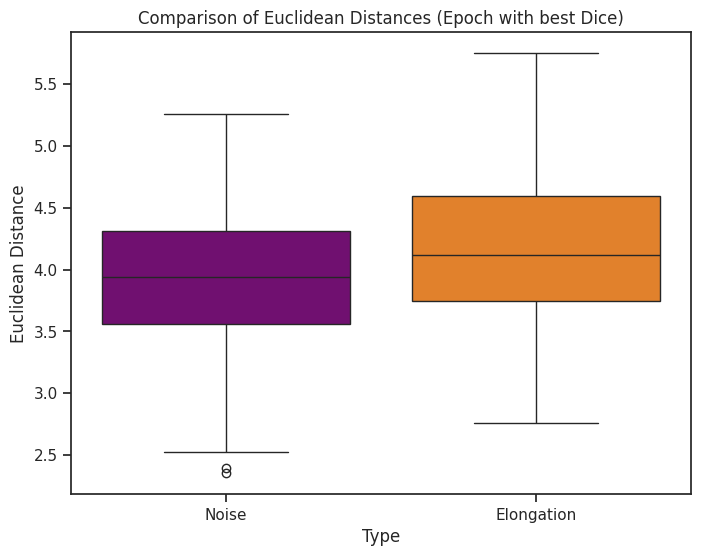

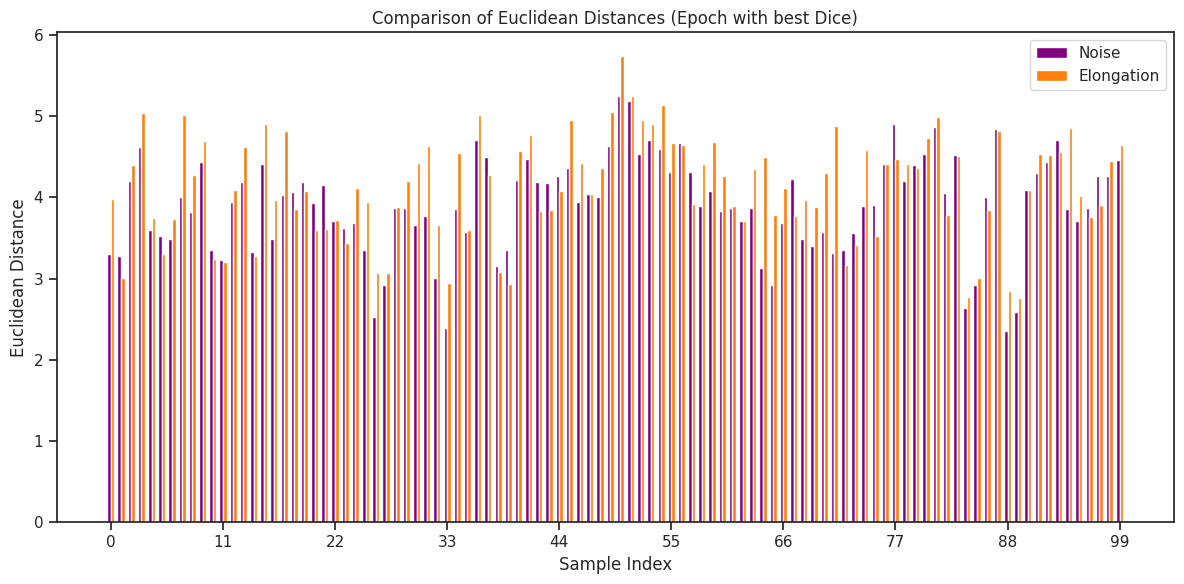

In [141]:
euclidean_distances_noise_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Noise'] * len(euclidean_distances_noise_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

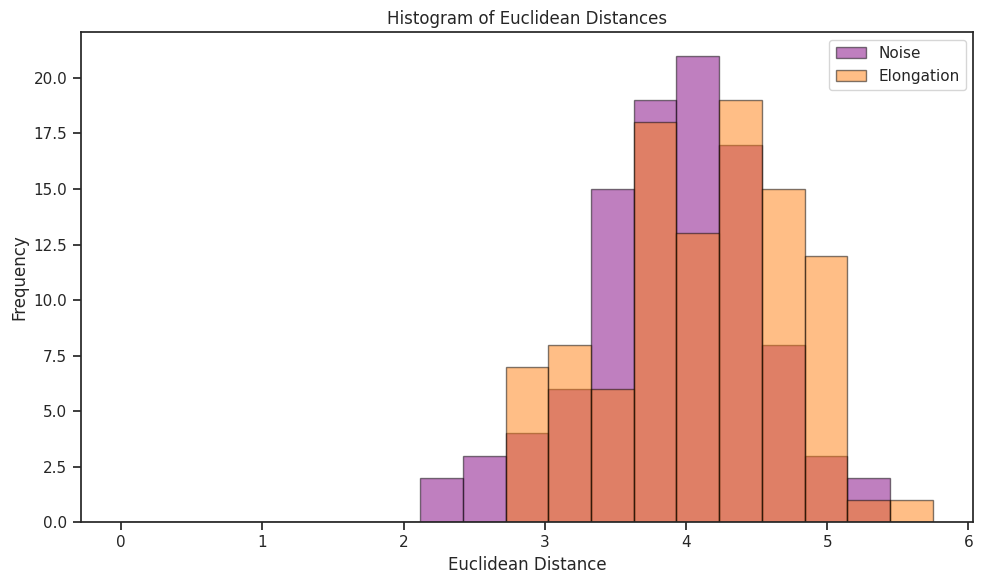

In [142]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_noise_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins_dice, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

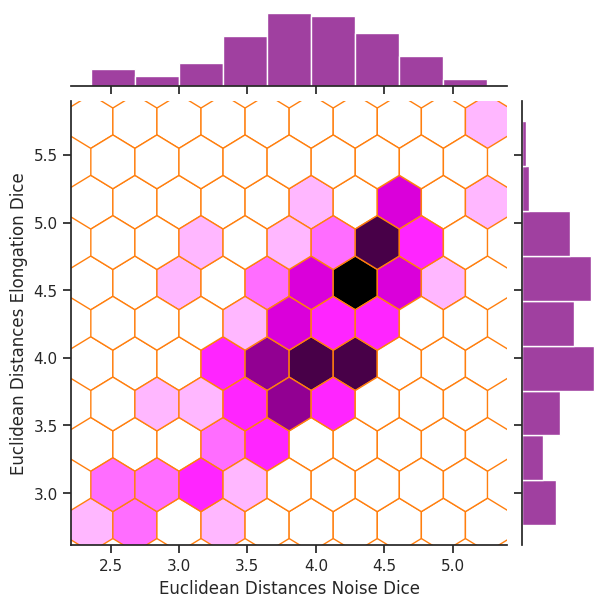

In [143]:
x_dice = euclidean_distances_noise_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#800080")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Noise Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



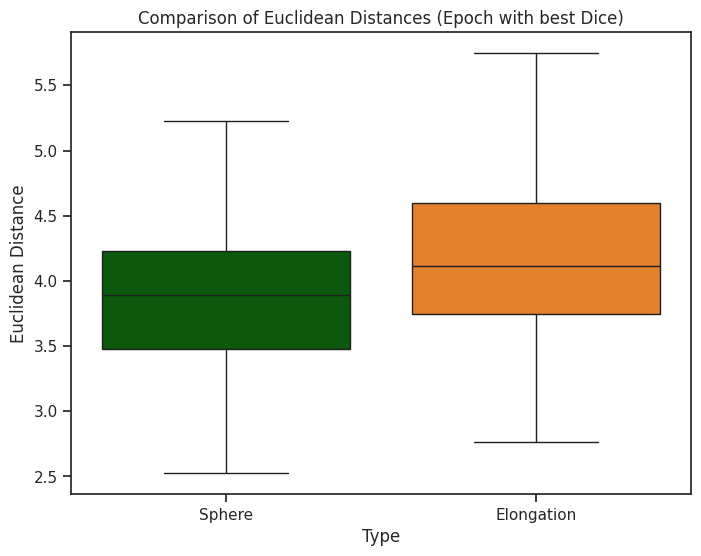

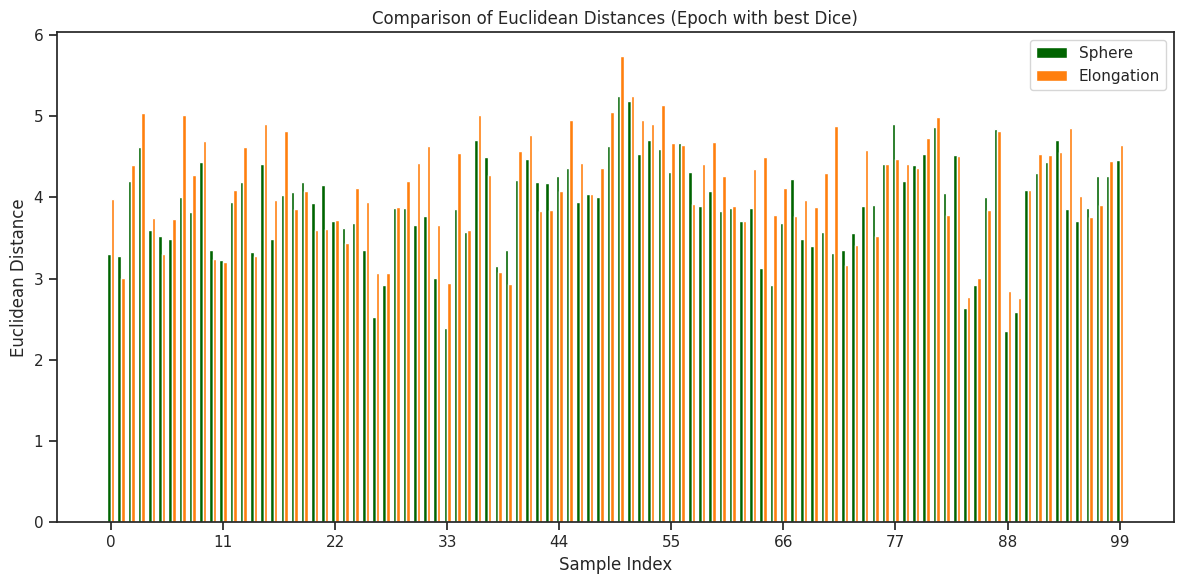

In [144]:
euclidean_distances_sphere_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

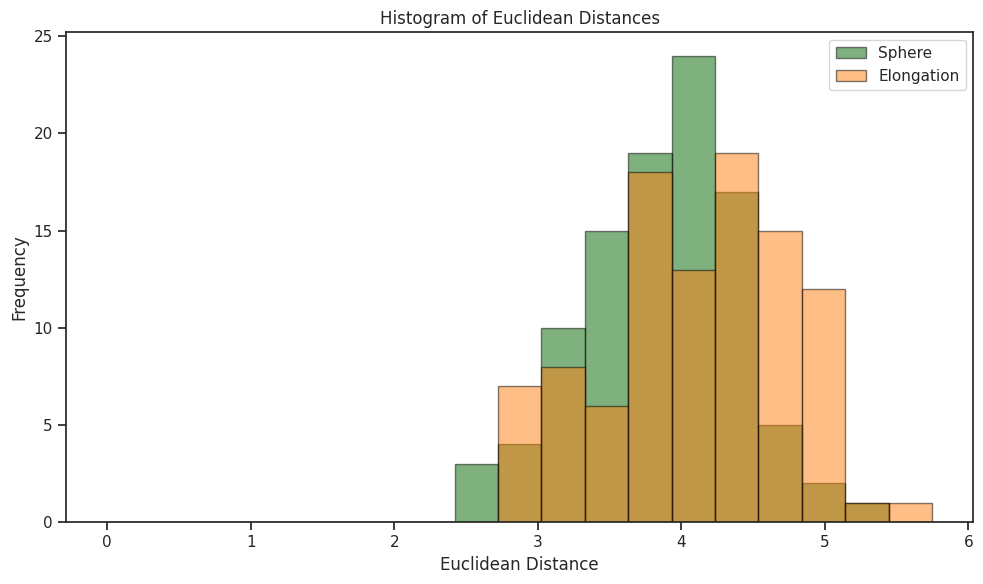

In [145]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_dice, bins=bins_dice, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

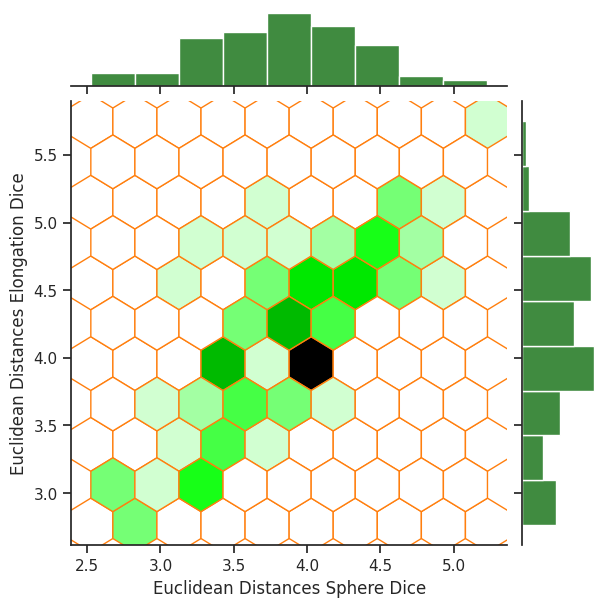

In [146]:
x_dice = euclidean_distances_sphere_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



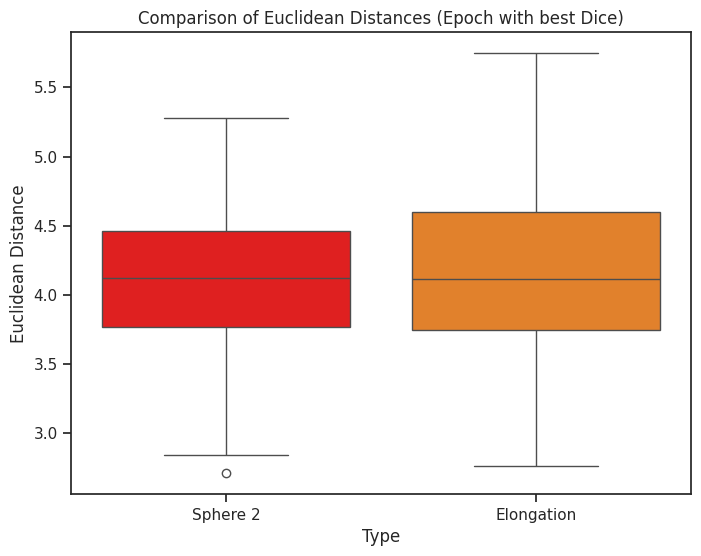

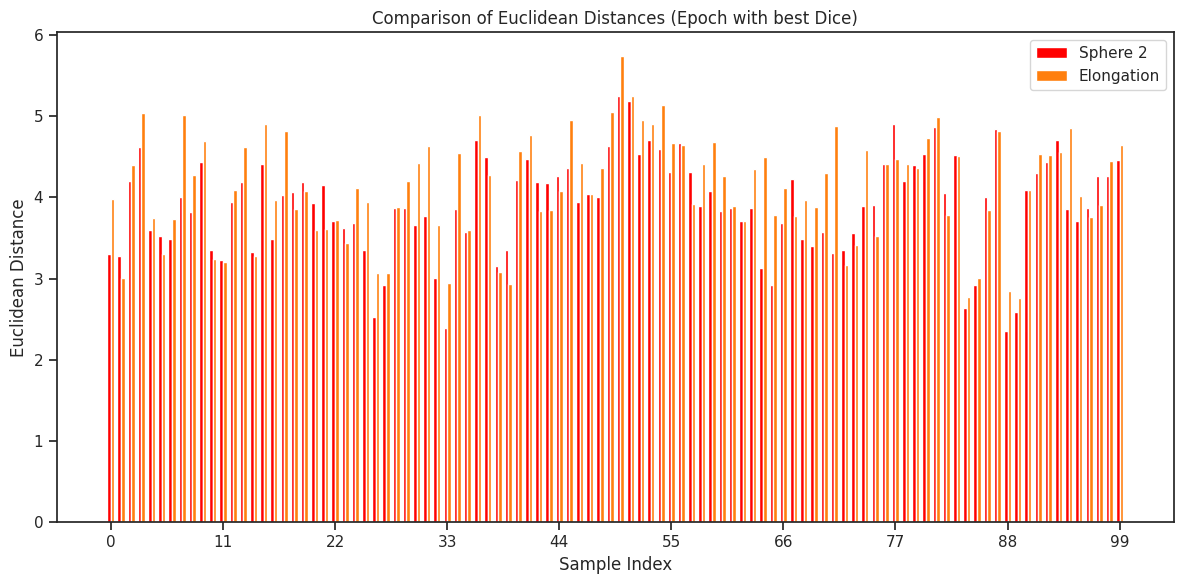

In [147]:
euclidean_distances_sphere_2_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

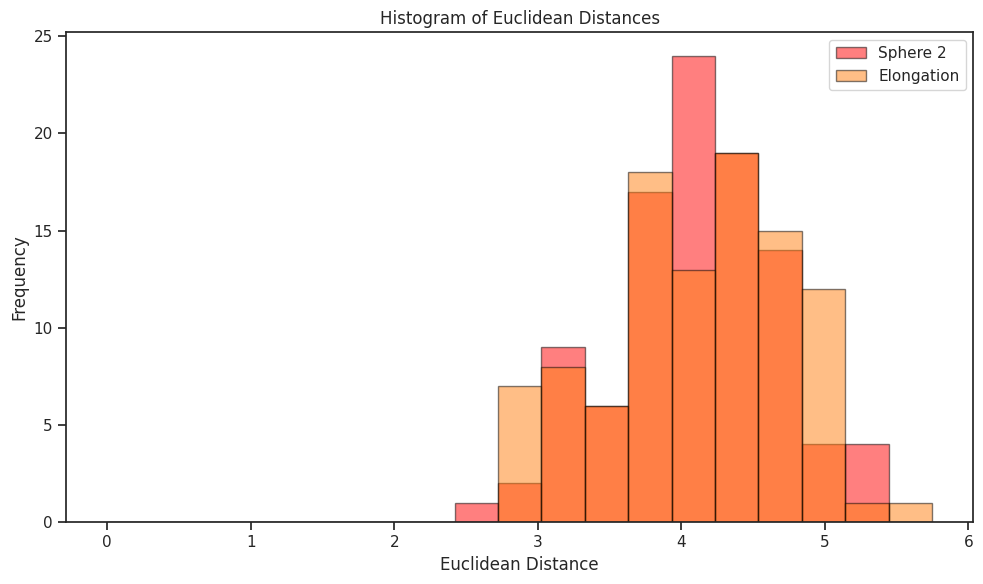

In [148]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_2_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_dice, bins=bins_dice, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

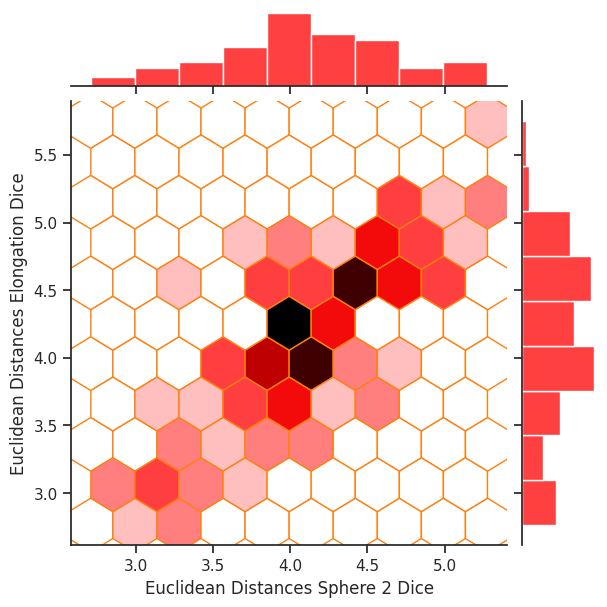

In [149]:
x_dice = euclidean_distances_sphere_2_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#FF0000")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



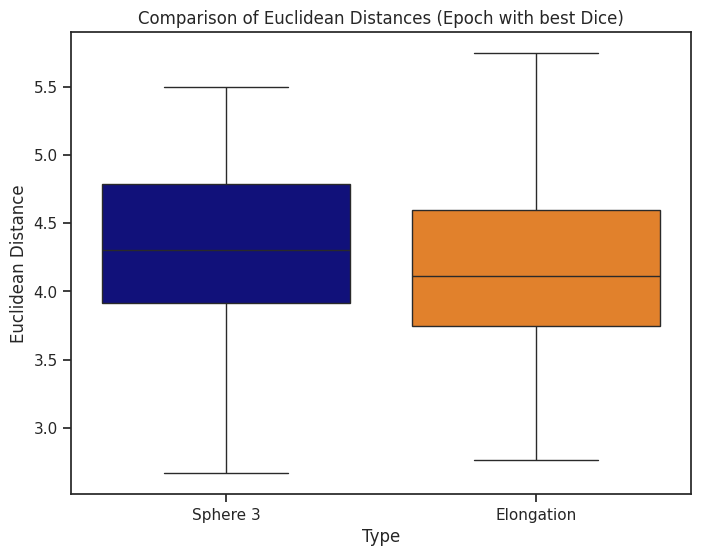

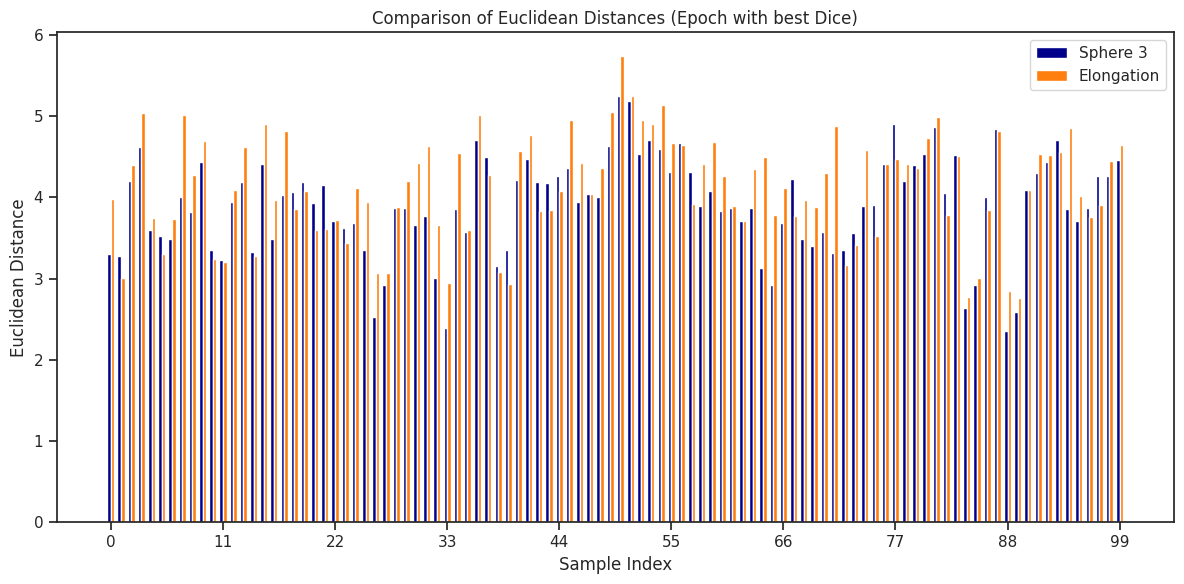

In [150]:
euclidean_distances_sphere_3_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

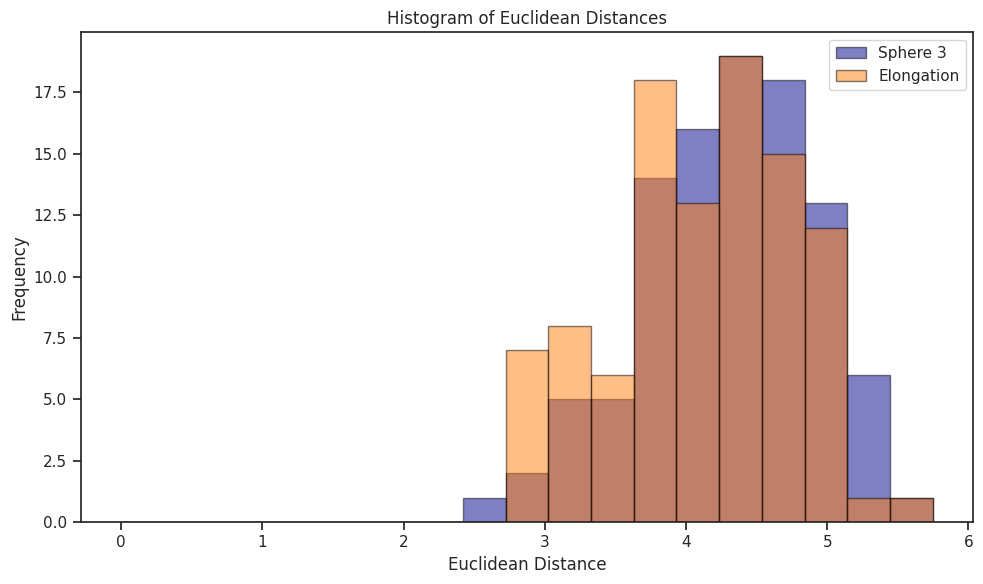

In [151]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_3_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_dice, bins=bins_dice, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
x_dice = euclidean_distances_sphere_3_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#00008B")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()

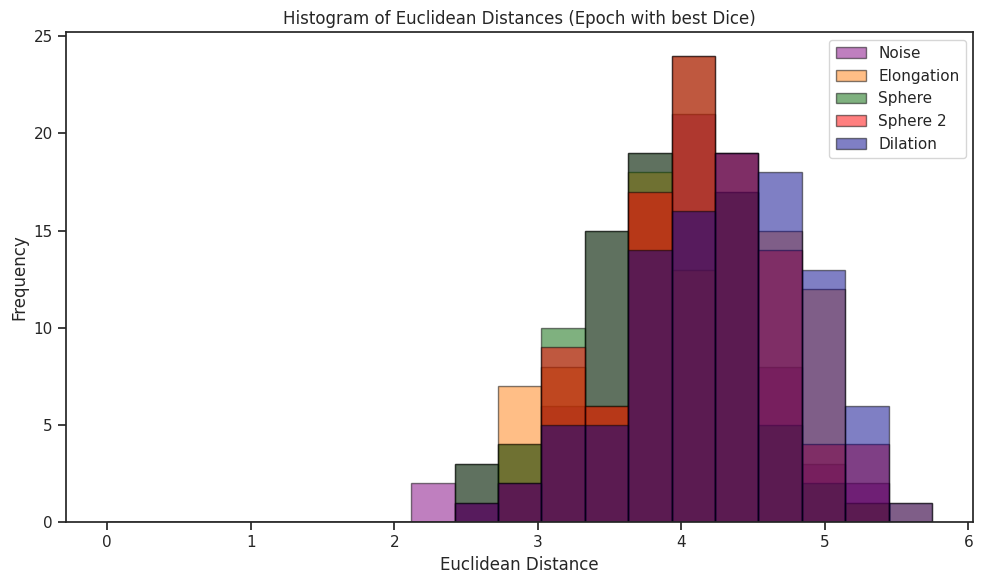

In [153]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_dice), 
                          np.max(euclidean_distances_elongated_dice), 
                          np.max(euclidean_distances_sphere_dice), 
                          np.max(euclidean_distances_sphere_2_dice), 
                          np.max(euclidean_distances_sphere_3_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere_dice, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2_dice, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3_dice, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best Dice)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



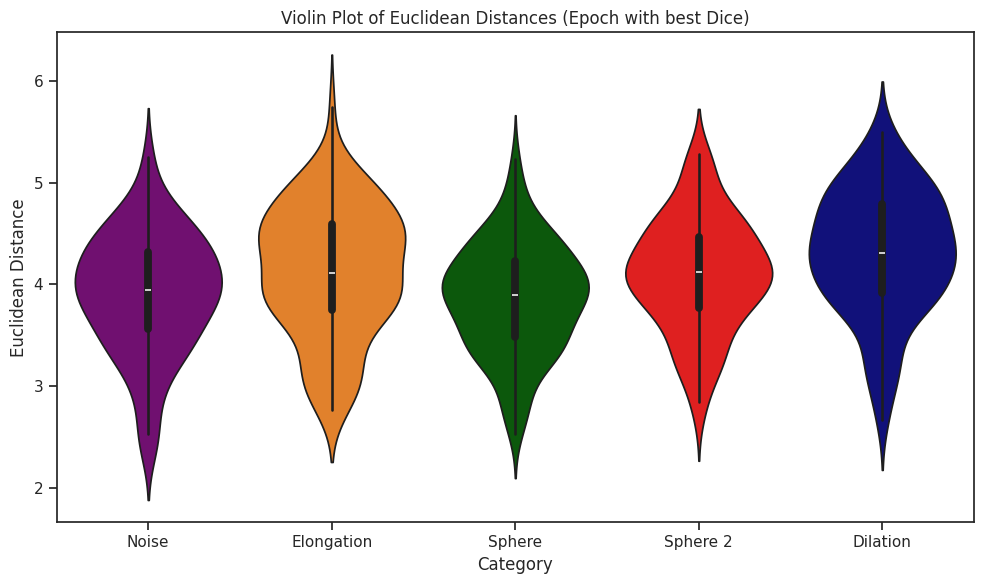

In [154]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_dice, 
                                euclidean_distances_elongated_dice, 
                                euclidean_distances_sphere_dice, 
                                euclidean_distances_sphere_2_dice, 
                                euclidean_distances_sphere_3_dice]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Sphere'] * len(euclidean_distances_sphere_dice) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best Dice)')
plt.tight_layout()
plt.show()

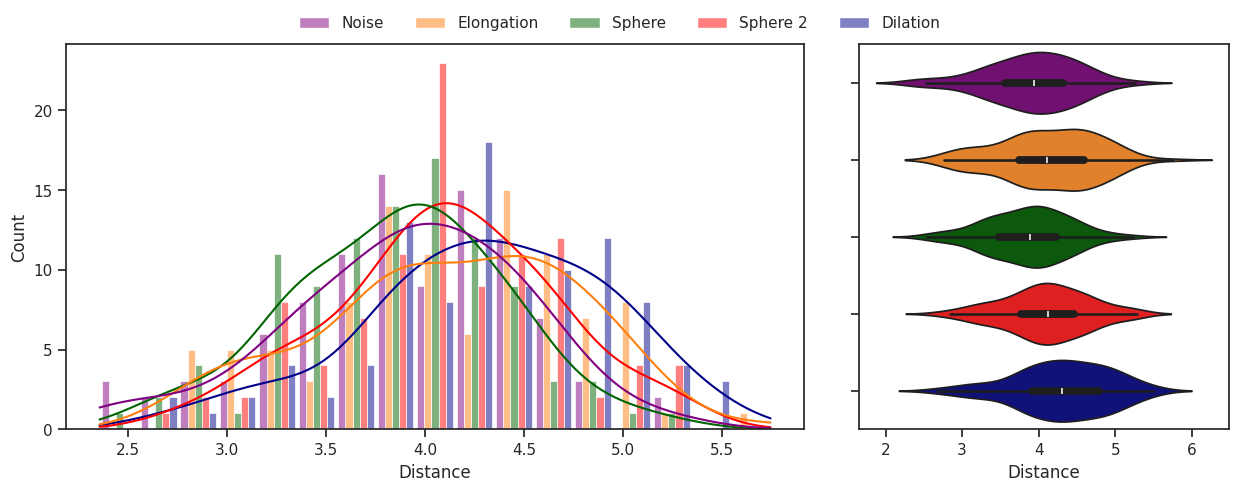

In [ ]:
data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_dice, 
        euclidean_distances_elongated_dice, 
        euclidean_distances_sphere_dice, 
        euclidean_distances_sphere_2_dice, 
        euclidean_distances_sphere_3_dice
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Sphere'] * len(euclidean_distances_sphere_3_dice) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',       
    'Elongation': '#ff7f0e',  
    'Sphere': '#006400',      
    'Sphere 2': '#FF0000',    
    'Dilation': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

EUCLIDEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCHS WITH THE BEST HAUSDORFF DISTANCE

In [156]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.307338  3.275154  4.207526  4.6165876 3.595809  3.5307622 3.486764
 4.007172  3.820977  4.43676   3.3568864 3.2300298 3.9496984 4.1889696
 3.3286662 4.4132824 3.487687  4.0302906 4.067065  4.192974  3.9374874
 4.150694  3.715604  3.6217682 3.682167  3.3532481 2.5304816 2.916386
 3.8672397 3.8668053 3.6552851 3.7777905 3.010631  2.3946075 3.852363
 3.5798678 4.702489  4.4926853 3.1528475 3.3491478 4.22137   4.4684124
 4.185456  4.1726832 4.2656507 4.3624377 3.949494  4.037689  4.003547
 4.6379113 5.254818  5.1865206 4.536194  4.7108765 4.5921736 4.314299
 4.670002  4.312815  3.8955681 4.078088  3.8314652 3.8700557 3.7055933
 3.8716402 3.1313777 2.91926   3.6886098 4.2260447 3.4889634 3.3965347
 3.5694742 3.3106792 3.3558347 3.568002  3.8981793 3.9049237 4.4169965
 4.8991804 4.2021675 4.395805  4.5392566 4.861989  4.057681  4.522484
 2.6380398 2.926745  4.00124

In [157]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.343115  3.2227027 4.159272  4.5788217 3.6029983 3.5206122 3.3770313
 3.8030837 3.693129  4.295316  3.2685182 3.1621003 3.8684824 4.118945
 3.2780533 4.3100214 3.3355699 3.8957615 3.8590052 4.0821133 3.7201753
 3.8752313 3.769     3.4673648 3.9614584 3.5619435 2.5249267 2.8007324
 3.8889184 3.7257519 3.5348687 3.6686692 3.2660139 2.6743135 3.8183675
 3.4594665 4.5086384 4.296251  3.207101  3.3100395 4.0441165 4.3495574
 4.1931634 4.0820227 4.077021  4.2523127 3.973745  3.944477  3.9415886
 4.5817947 5.2304635 5.0600863 4.3971043 4.5341573 4.592588  4.218979
 4.5293183 4.0712566 3.9851727 4.018531  3.995708  3.9816856 3.6558208
 3.762542  3.2536614 3.044672  3.4219916 4.0232143 3.5524895 3.3580394
 3.9375863 3.3841267 3.3009062 3.480073  3.6863546 3.684774  4.3883166
 4.839072  4.182908  4.285743  4.4611893 4.807354  3.9961748 4.488399
 2.6817067 2.928106  4.0

In [158]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.6212199 3.6356988 4.2461977 5.259382  4.018503  4.1251225 3.6301327
 4.2606826 3.8548312 4.7366977 3.3294265 3.3023374 3.9765806 4.2922306
 3.6376252 4.7494054 3.43997   4.1214213 4.068399  4.501221  4.13385
 4.42549   3.9284503 3.7747705 4.037963  3.7483726 2.7108629 3.158297
 3.963362  3.9515224 3.797322  4.300099  3.2870488 2.8443289 3.980436
 3.7184446 4.6460867 4.4146404 3.2634592 3.4820032 4.074491  4.428865
 4.68057   4.5807405 4.289335  4.7551875 4.063868  4.140481  4.034015
 4.6896634 5.247959  5.1628923 4.489358  4.712498  4.715894  4.549938
 4.5815587 4.2501607 4.1554685 4.378244  4.123804  4.1195626 3.7882967
 3.8704531 3.3027294 3.0472794 3.545941  4.244204  3.8499434 3.9006476
 4.014183  3.692213  3.4814873 3.7568464 3.9763377 4.147046  4.435961
 5.1063137 4.297359  4.4179006 4.663221  5.004044  4.1465387 5.0103183
 2.9284887 3.1784842 4.1392

In [159]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.725345  3.5929766 4.585022  5.037987  3.9183106 3.6264884 3.8948538
 4.2561874 4.1984525 4.825227  3.9216313 3.8056154 4.0765967 4.513825
 4.278522  4.925623  3.8318796 4.6126275 4.509819  4.826523  4.3274684
 4.177483  3.9663515 3.836885  4.0440316 3.80195   2.7537038 3.1978986
 4.317557  4.4408603 4.421172  4.338147  3.4230888 2.6674109 4.1970677
 3.9865298 5.0071583 4.9363656 3.4166918 3.7851565 4.576947  5.2254133
 4.599136  4.493508  4.623768  4.7826867 4.1348147 4.3297973 3.9614217
 4.8265634 5.5004287 5.4327416 4.9146137 5.013974  4.836244  4.7777214
 5.0211415 4.7026663 4.160211  4.4254575 4.1212955 4.2292533 3.8591821
 3.9749372 3.3352509 3.0700989 4.289032  5.101027  3.897312  3.7058492
 4.248424  3.8286052 3.773517  3.9411945 4.2896523 4.262032  4.7371964
 5.253151  4.517255  4.9811206 4.90742   5.425742  4.5468    5.00753
 3.1867137 3.1208985 4

In [160]:
# Euclidean distance between the latent vectors of the best epoch (Hausdorff Distance) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_hausdorff.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_hausdorff[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_hausdorff.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

print(len(distancias_euclidianas))
print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
100
Distancias Euclidianas: [3.980449  3.0117335 4.4029856 5.0465817 3.7485745 3.2997968 3.7382214
 5.0200653 4.2752542 4.6982636 3.241808  3.206594  4.087405  4.6172695
 3.2844045 4.905668  3.9698932 4.816683  3.8613856 4.0747237 3.5976274
 3.6170895 3.7270496 3.4380152 4.1177545 3.9416513 3.0650284 3.0726247
 3.8851974 4.1975603 4.4259124 4.639834  3.6606574 2.9417746 4.5430336
 3.600334  5.0200205 4.2783394 3.0796344 2.929811  4.5683403 4.768965
 3.8355002 3.8440225 4.0822296 4.94882   4.425822  4.0473413 4.3686395
 5.050969  5.74663   5.2543993 4.9597845 4.902854  5.1390276 4.6654415
 4.6435537 3.9157622 4.415202  4.6892843 4.267578  3.8896618 3.7073712
 4.3491483 4.5006194 3.7822692 4.110652  3.7682693 3.9675188 3.8797412
 4.2985377 4.8781424 3.171194  3.4180448 4.588622  3.5304232 4.40853
 4.474991  4.4158273 4.367309  4.735067  4.9905653 3.783249  4.50542
 2.7716444 3.0083768 3.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



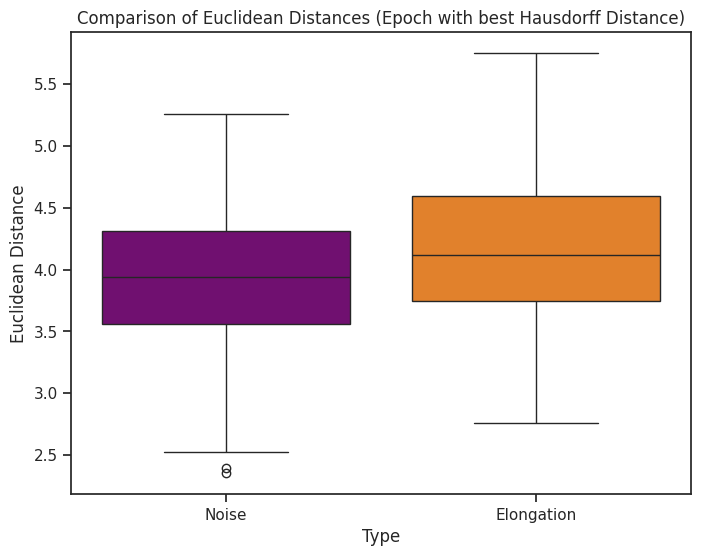

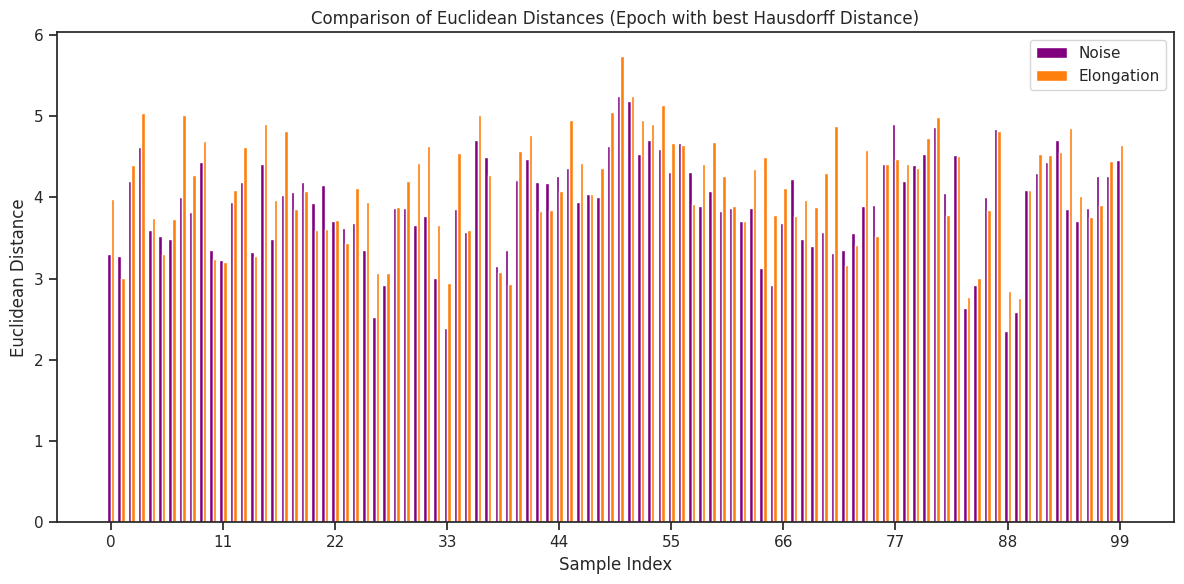

In [161]:
euclidean_distances_noise_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_Hausdorff, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

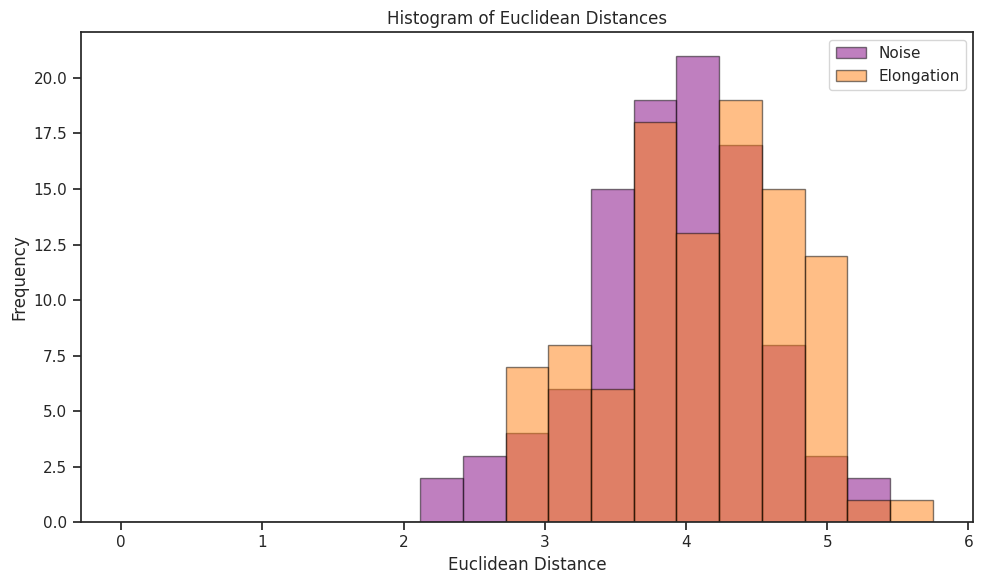

In [162]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_noise_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Noise', color='#800080', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

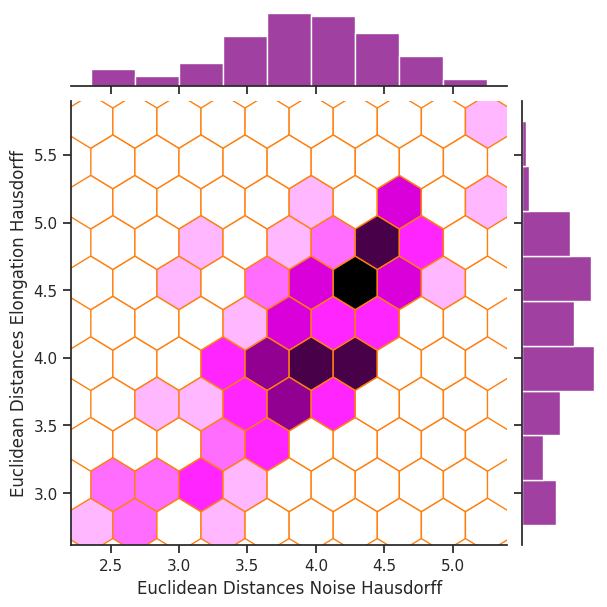

In [163]:
x_Hausdorff = euclidean_distances_noise_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



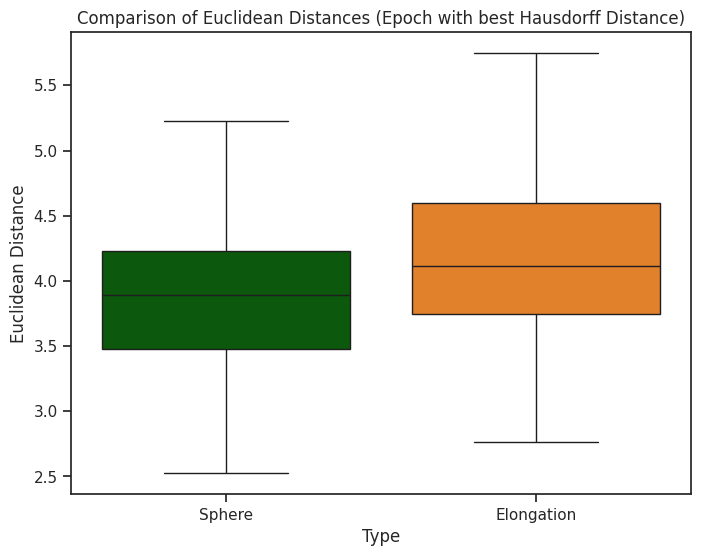

In [164]:
euclidean_distances_sphere_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_Hausdorff, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

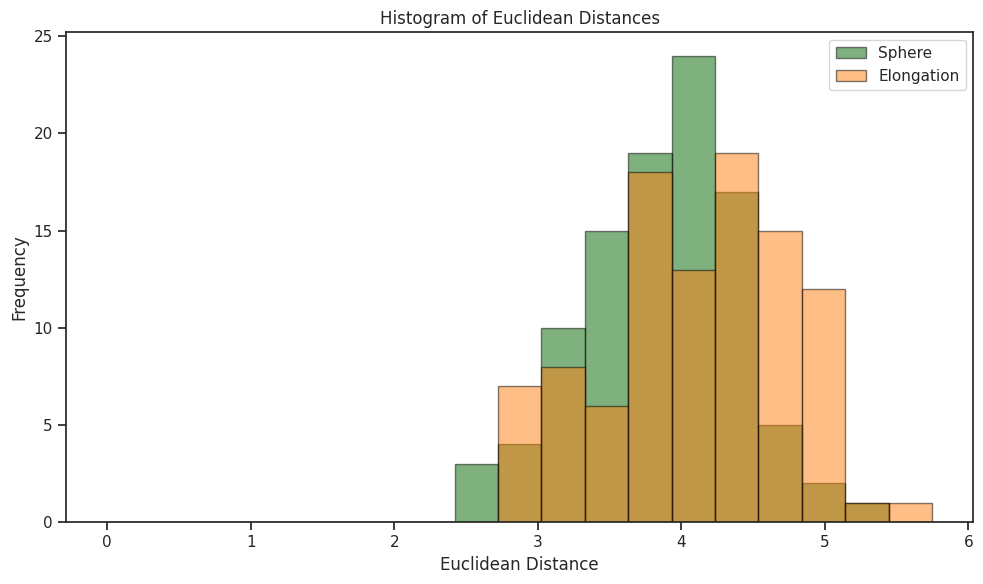

In [165]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_sphere_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

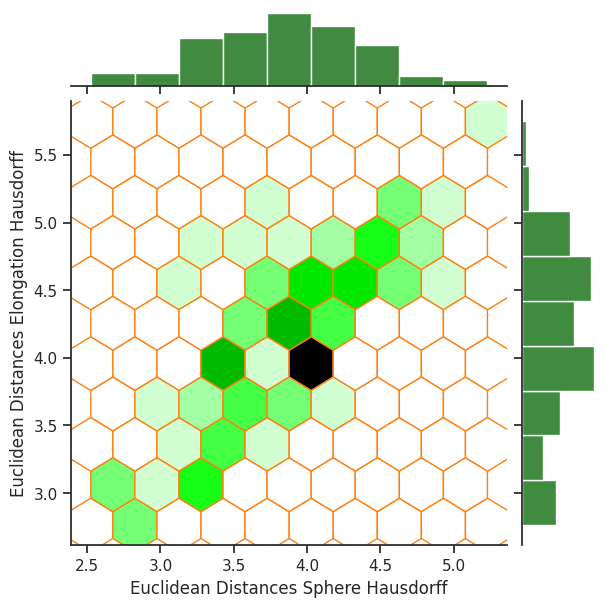

In [166]:
x_Hausdorff = euclidean_distances_sphere_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e") 
plt.xlabel('Euclidean Distances Sphere Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



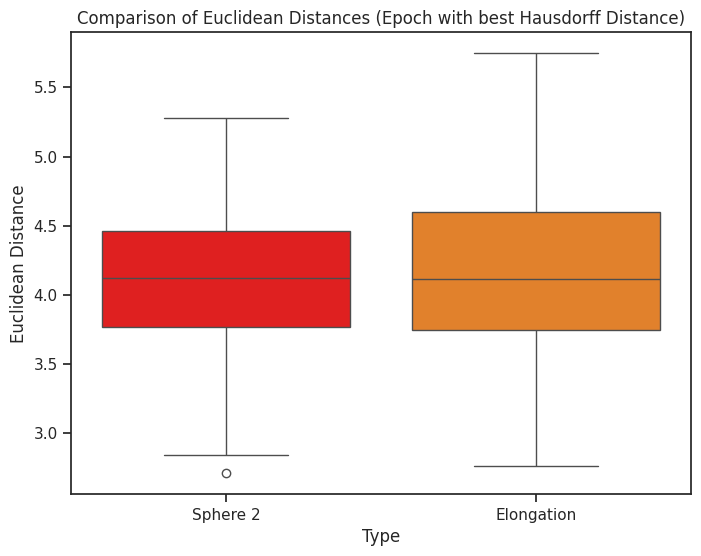

In [167]:
euclidean_distances_sphere_2_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere 2": "#FF0000", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2_Hausdorff, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

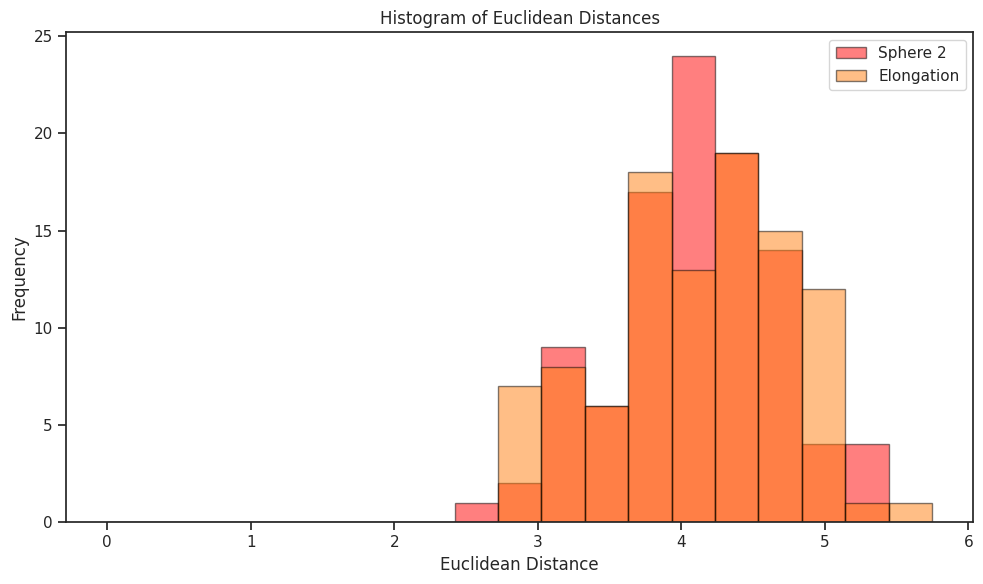

In [168]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_sphere_2_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

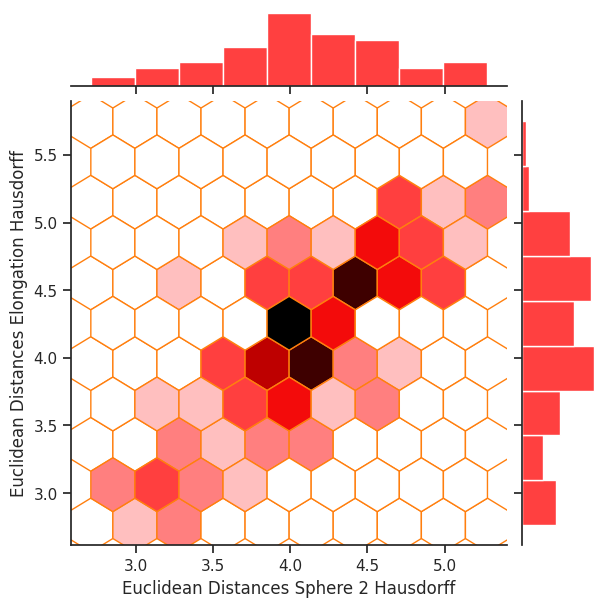

In [169]:
x_Hausdorff = euclidean_distances_sphere_2_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#FF0000") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e") 

plt.xlabel('Euclidean Distances Sphere 2 Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



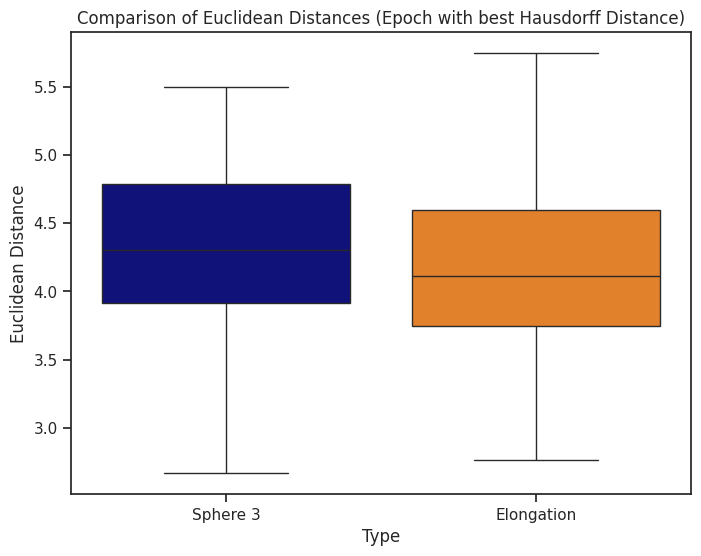

In [170]:
euclidean_distances_sphere_3_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_Hausdorff) + list(euclidean_distances_elongated_Hausdorff),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_Hausdorff) + ['Elongation'] * len(euclidean_distances_elongated_Hausdorff)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3_Hausdorff, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Hausdorff Distance)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

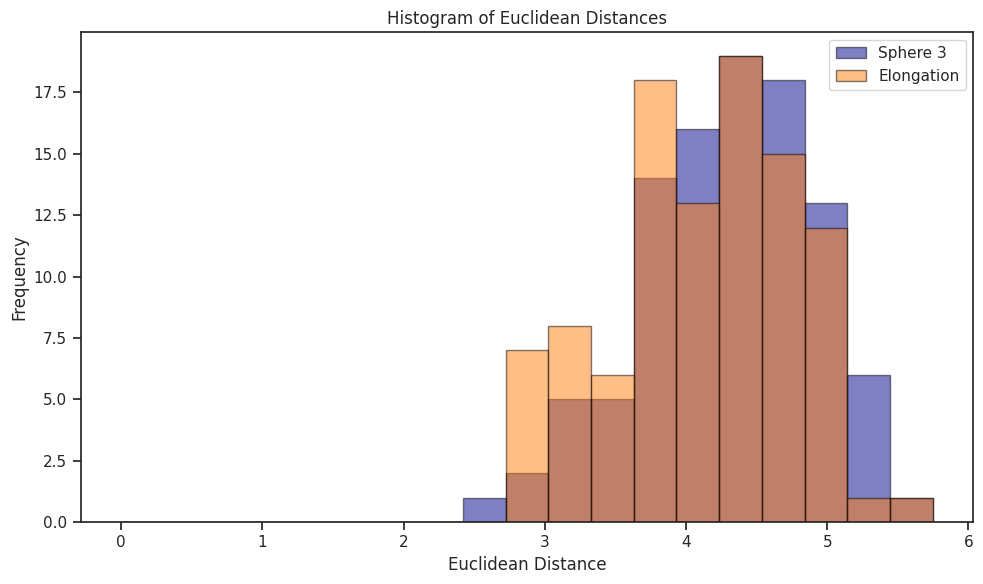

In [171]:
bins_Hausdorff = np.linspace(0, max(np.max(euclidean_distances_sphere_3_Hausdorff), np.max(euclidean_distances_elongated_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins_Hausdorff, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()

plt.tight_layout()
plt.show()

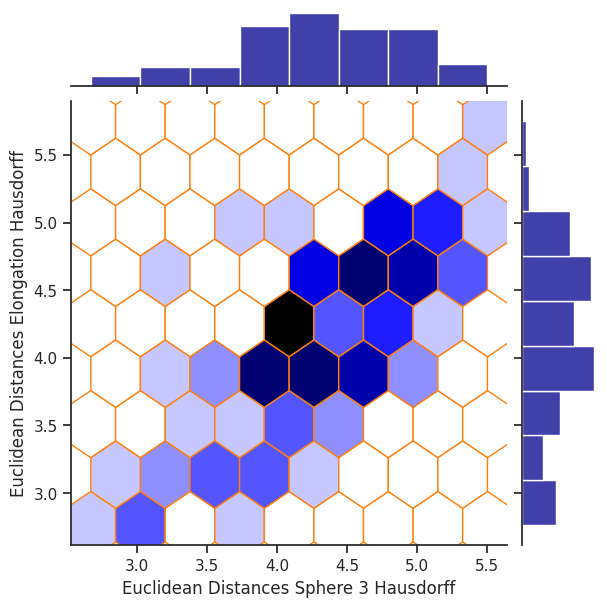

In [172]:
x_Hausdorff = euclidean_distances_sphere_3_Hausdorff
y_Hausdorff = euclidean_distances_elongated_Hausdorff

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_Hausdorff, y=y_Hausdorff, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 Hausdorff')
plt.ylabel('Euclidean Distances Elongation Hausdorff')
plt.show()

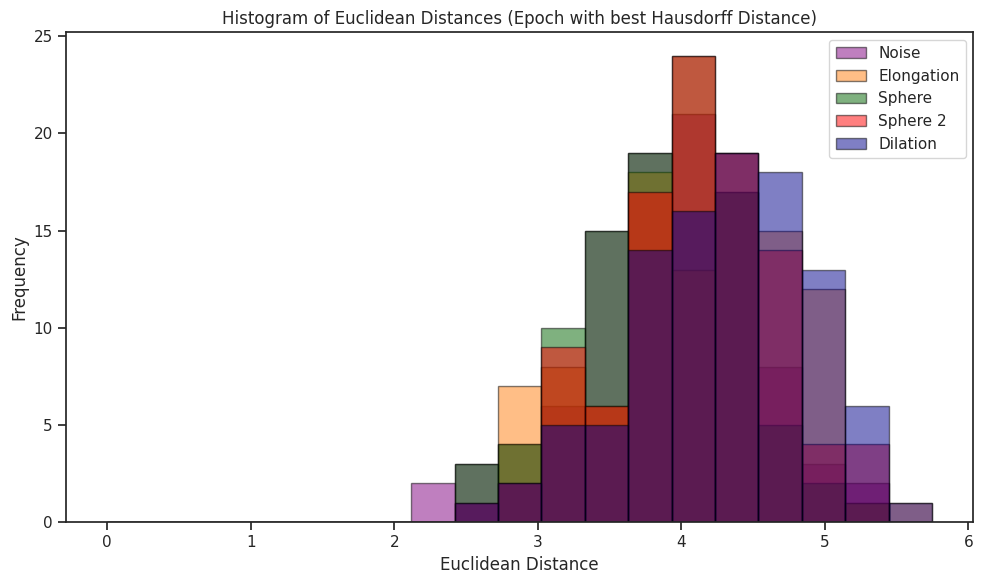

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_Hausdorff), 
                          np.max(euclidean_distances_elongated_Hausdorff), 
                          np.max(euclidean_distances_sphere_Hausdorff), 
                          np.max(euclidean_distances_sphere_2_Hausdorff), 
                          np.max(euclidean_distances_sphere_3_Hausdorff)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_Hausdorff, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black') 
plt.hist(euclidean_distances_elongated_Hausdorff, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  
plt.hist(euclidean_distances_sphere_Hausdorff, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_sphere_2_Hausdorff, bins=bins, alpha=0.5, label='Sphere 2', color='#FF0000', edgecolor='black')  
plt.hist(euclidean_distances_sphere_3_Hausdorff, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best Hausdorff Distance)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



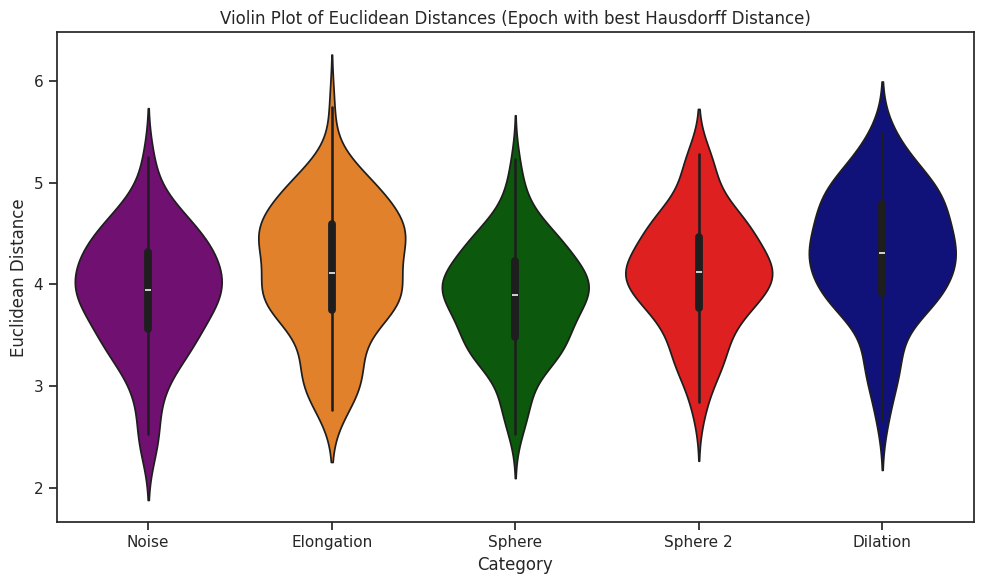

In [174]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_Hausdorff, 
                                euclidean_distances_elongated_Hausdorff, 
                                euclidean_distances_sphere_Hausdorff, 
                                euclidean_distances_sphere_2_Hausdorff, 
                                euclidean_distances_sphere_3_Hausdorff]),
    'Category': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + 
                ['Elongation'] * len(euclidean_distances_elongated_Hausdorff) + 
                ['Sphere'] * len(euclidean_distances_sphere_Hausdorff) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_Hausdorff) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_Hausdorff)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FF0000', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best Hausdorff Distance)')
plt.tight_layout()
plt.show()

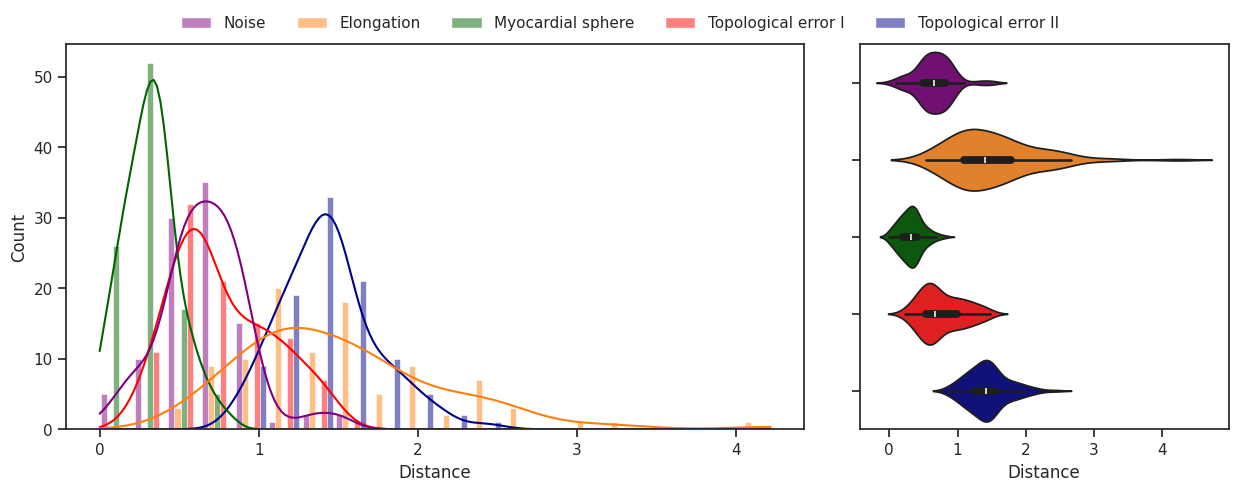

In [175]:
# COMPARISON LAST EPOCH

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise, 
        euclidean_distances_elongated, 
        euclidean_distances_sphere, 
        euclidean_distances_sphere_2, 
        euclidean_distances_sphere_3
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}


fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

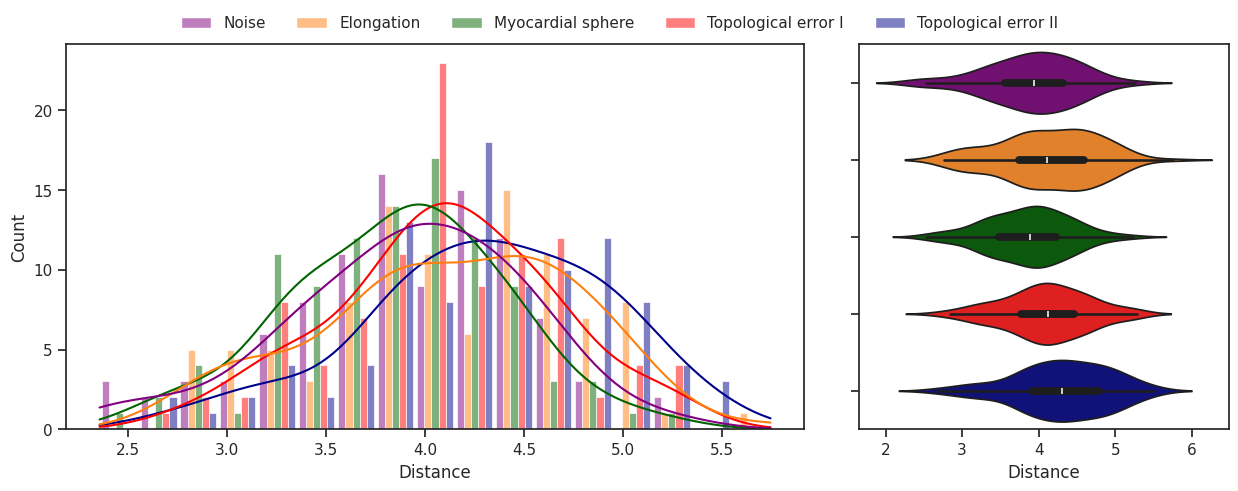

In [176]:
# COMPARISON EPOCH WITH BEST DICE

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_dice, 
        euclidean_distances_elongated_dice, 
        euclidean_distances_sphere_dice, 
        euclidean_distances_sphere_2_dice, 
        euclidean_distances_sphere_3_dice
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere_3_dice) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2_dice) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)
palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

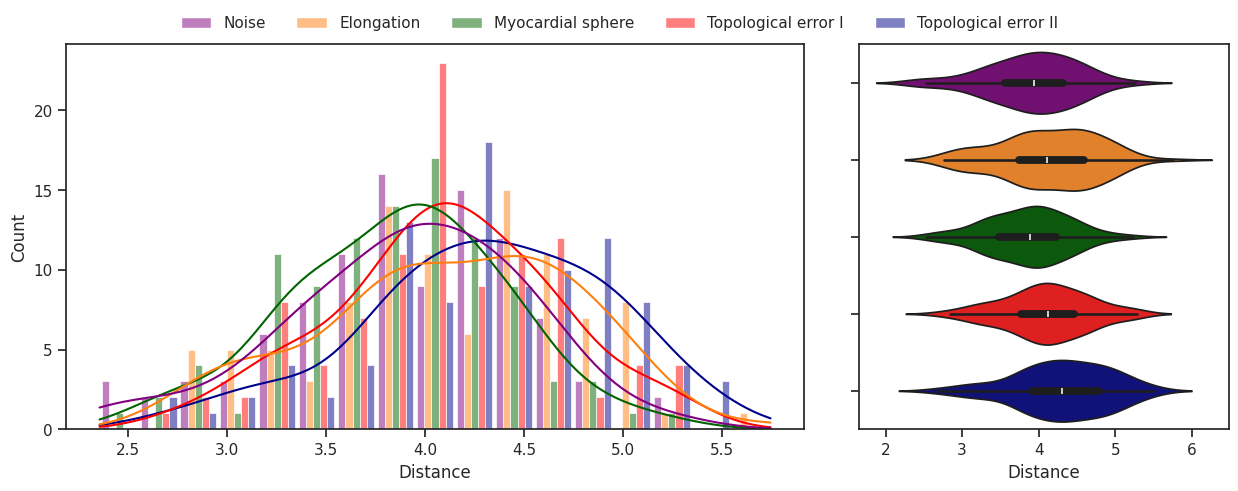

In [191]:
# COMPARISON EPOCH WITH BEST HAUSDORFF DISTANCE

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise_Hausdorff, 
        euclidean_distances_elongated_Hausdorff, 
        euclidean_distances_sphere_Hausdorff, 
        euclidean_distances_sphere_2_Hausdorff, 
        euclidean_distances_sphere_3_Hausdorff
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise_Hausdorff) + 
                ['Elongation'] * len(euclidean_distances_elongated_Hausdorff) + 
                ['Myocardial sphere'] * len(euclidean_distances_sphere_Hausdorff) + 
                ['Topological error I'] * len(euclidean_distances_sphere_2_Hausdorff) + 
                ['Topological error II'] * len(euclidean_distances_sphere_3_Hausdorff)
}

df = pd.DataFrame(data)

palette = {
    'Noise': '#800080',      
    'Elongation': '#ff7f0e',  
    'Myocardial sphere': '#006400',      
    'Topological error I': '#FF0000',  
    'Topological error II': '#00008B'   
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=5, title=None, frameon=False,
)

sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()

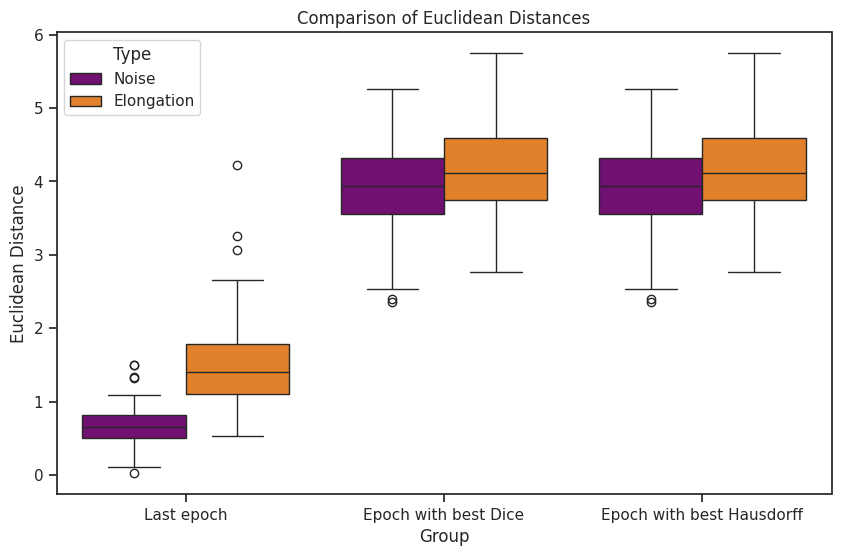

In [178]:
distances_noise_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
distances_elongation_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

distances_noise_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
distances_elongation_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

distances_noise_3 = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
distances_elongation_3 = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': (
        list(distances_noise_1) + list(distances_elongation_1) +
        list(distances_noise_2) + list(distances_elongation_2) +
        list(distances_noise_3) + list(distances_elongation_3)
    ),
    'Type': (
        ['Noise'] * len(distances_noise_1) + ['Elongation'] * len(distances_elongation_1) +
        ['Noise'] * len(distances_noise_2) + ['Elongation'] * len(distances_elongation_2) +
        ['Noise'] * len(distances_noise_3) + ['Elongation'] * len(distances_elongation_3)
    ),
    'Group': (
        ['Last epoch'] * (len(distances_noise_1) + len(distances_elongation_1)) +
        ['Epoch with best Dice'] * (len(distances_noise_2) + len(distances_elongation_2)) +
        ['Epoch with best Hausdorff'] * (len(distances_noise_3) + len(distances_elongation_3))
    )
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Distance', hue='Type', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances")
plt.ylabel("Euclidean Distance")
plt.show()

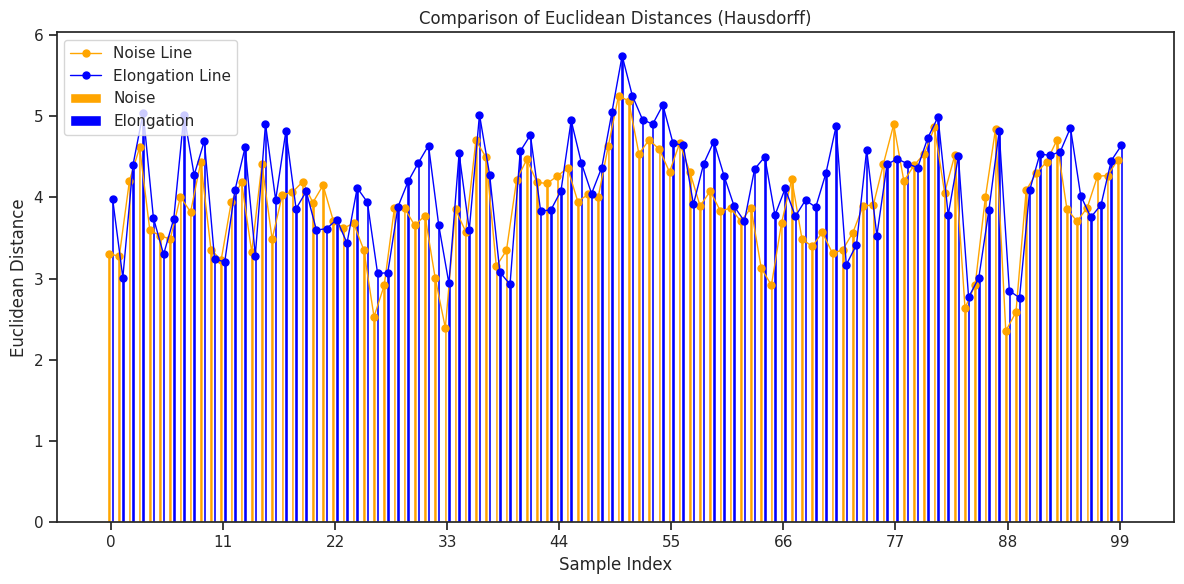

In [179]:
euclidean_distances_noise_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_Hausdorff = np.linalg.norm(best_val_latent_vectors_hausdorff - val_latent_vectors_elongated, axis=1)

x = np.arange(len(euclidean_distances_noise_Hausdorff))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, euclidean_distances_noise_Hausdorff, width, label='Noise', color='orange')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_Hausdorff, width, label='Elongation', color='blue')

ax.plot(x - width/2, euclidean_distances_noise_Hausdorff, color='orange', linewidth=1, marker='o', markersize=5, label='Noise Line')
ax.plot(x + width/2, euclidean_distances_elongated_Hausdorff, color='blue', linewidth=1, marker='o', markersize=5, label='Elongation Line')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Hausdorff)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

Files TSV

In [180]:
# train_latent_vectors_array = np.concatenate((best_train_latent_vectors, train_latent_vectors_noise), axis=0)
# val_latent_vectors_array = np.concatenate((best_val_latent_vectors, val_latent_vectors_noise), axis=0)

# print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array.shape}")
# print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array.shape}")

# if len(train_latent_vectors_array.shape) == 1:
#     train_latent_vectors_array = train_latent_vectors_array.reshape(-1, 1)
# if len(val_latent_vectors_array.shape) == 1:
#     val_latent_vectors_array = val_latent_vectors_array.reshape(-1, 1)

# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')

# print(f"Vectores latentes guardados en {output_dir}")

In [181]:
# import os
# import pandas as pd

# output_dir = '/mnt/nfs/home/liglesias'
# val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
# print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df.shape}")

# val_latent_vectors_original_df = val_latent_vectors_df.iloc[:100]
# val_latent_vectors_noise_df = val_latent_vectors_df.iloc[-100:]

# num_original = len(val_latent_vectors_original_df)
# num_noise = len(val_latent_vectors_noise_df)

# metadata = {
#     'ID': list(range(1, num_original + num_noise + 1)),
#     'Type': ['Original'] * num_original + ['Noise'] * num_noise
# }
# metadata_df = pd.DataFrame(metadata)

# metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

# print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")

In [225]:
import pickle

variables = {'last_train_latent_vectors': last_train_latent_vectors,
             'last_val_latent_vectors': last_val_latent_vectors,
             'best_train_latent_vectors_dice': best_train_latent_vectors_dice,
             'best_val_latent_vectors_dice': best_val_latent_vectors_dice,
             'best_train_latent_vectors_hausdorff': best_train_latent_vectors_hausdorff,
             'best_val_latent_vectors_hausdorff': best_val_latent_vectors_hausdorff,
             'train_latent_vectors_noise': train_latent_vectors_noise,
             'val_latent_vectors_noise': val_latent_vectors_noise,
             'train_latent_vectors_elongated': train_latent_vectors_elongated,
             'val_latent_vectors_elongated': val_latent_vectors_elongated,
             'train_latent_vectors_sphere': train_latent_vectors_sphere,
             'val_latent_vectors_sphere': val_latent_vectors_sphere,
             'train_latent_vectors_sphere_2': train_latent_vectors_sphere_2,
             'val_latent_vectors_sphere_2': val_latent_vectors_sphere_2,
             'train_latent_vectors_sphere_3': train_latent_vectors_sphere_3,
             'val_latent_vectors_sphere_3': val_latent_vectors_sphere_3,
             'euclidean_distances_noise': euclidean_distances_noise,
             'euclidean_distances_elongated': euclidean_distances_elongated,
             'euclidean_distances_sphere': euclidean_distances_sphere,
             'euclidean_distances_sphere_2': euclidean_distances_sphere_2,
             'euclidean_distances_sphere_3': euclidean_distances_sphere_3,
             'euclidean_distances_noise_dice': euclidean_distances_noise_dice,
             'euclidean_distances_elongated_dice': euclidean_distances_elongated_dice,
             'euclidean_distances_sphere_dice': euclidean_distances_sphere_dice,
             'euclidean_distances_sphere_dice': euclidean_distances_sphere_2_dice,
             'euclidean_distances_sphere_dice': euclidean_distances_sphere_3_dice,
             'euclidean_distances_noise_Hausdorff': euclidean_distances_noise_Hausdorff,
             'euclidean_distances_elongated_Hausdorff': euclidean_distances_elongated_Hausdorff,
             'euclidean_distances_sphere_Hausdorff': euclidean_distances_sphere_Hausdorff,
             'euclidean_distances_sphere_2_Hausdorff': euclidean_distances_sphere_2_Hausdorff,
             'euclidean_distances_sphere_3_Hausdorff': euclidean_distances_sphere_3_Hausdorff}

with open('variables.pkl', 'wb') as f:
    pickle.dump(variables, f)

In [2]:
import pickle

with open('variables.pkl', 'rb') as f:
    variables = pickle.load(f)

for key, value in variables.items():
    print(f"{key}: {type(value)} - {value.shape if hasattr(value, 'shape') else 'No tiene shape'}")
    print(value, "\n")

last_train_latent_vectors: <class 'numpy.ndarray'> - (200, 64)
[[-0.29413393  1.7322596   2.2000463  ... -0.2474454   1.7590147
  -3.4939346 ]
 [ 0.48903638 -0.1461686   2.943853   ...  1.490288   -0.15590358
  -0.78105855]
 [-0.09887561  0.6933333   3.7654228  ...  3.0439205  -0.97328246
  -0.45074898]
 ...
 [-0.52893907  0.5505239   2.5730324  ... -1.1952491   1.9020175
  -4.375531  ]
 [ 0.35054824 -0.44603303  1.4735345  ...  1.0092868  -0.08751475
   0.08444018]
 [ 0.12033069  0.38600332  0.07968064 ...  0.5461157   1.1410186
  -1.2267636 ]] 

last_val_latent_vectors: <class 'numpy.ndarray'> - (100, 64)
[[ 0.20778236  2.6444483   3.6690738  ... -0.2292133   2.1429727
  -3.4337955 ]
 [-0.11904207  2.7246418   3.5445147  ...  0.180874    1.5904249
  -3.029782  ]
 [-0.16487953  2.2663565   2.317051   ...  0.03324441  1.7888362
  -2.8168786 ]
 ...
 [ 0.3760521   2.8303714   2.820285   ...  0.25513512  2.0934448
  -3.3444824 ]
 [-0.01438448  2.835953    2.7143483  ...  0.18339774  1.890

In [3]:
globals().update(variables)

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

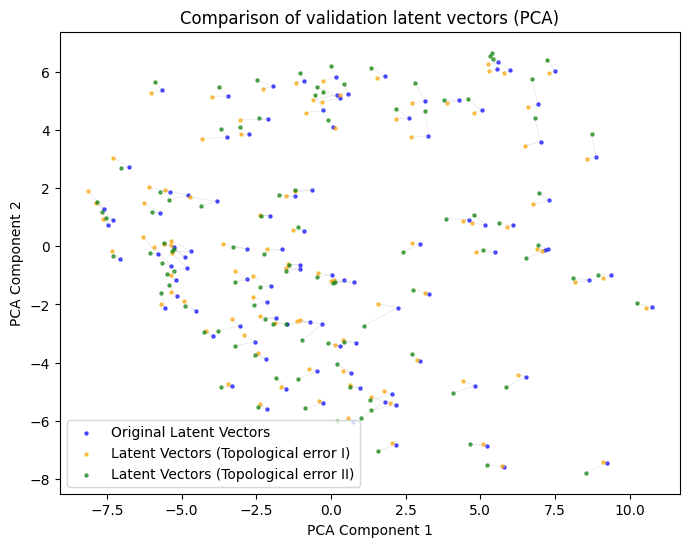

In [ ]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Topological error I)')
plt.scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Topological error II)')
plt.title('Comparison of validation latent vectors (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 100, 0]], 
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_pca[i, 0], all_val_latent_vectors_pca[i + 200, 0]],
             [all_val_latent_vectors_pca[i, 1], all_val_latent_vectors_pca[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

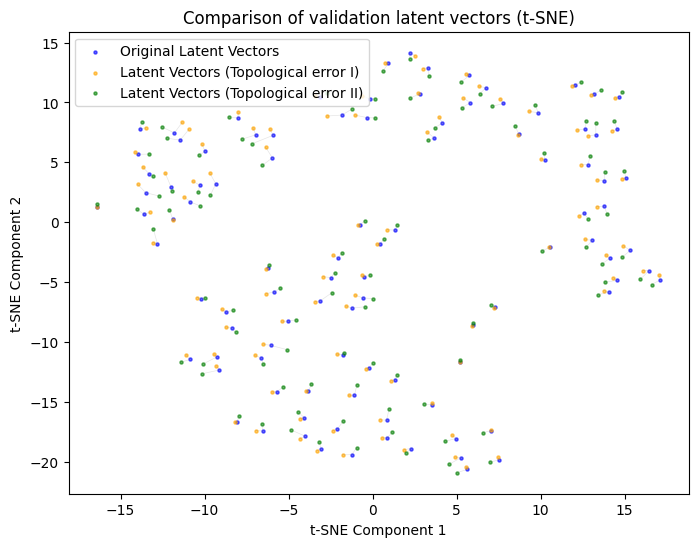

In [9]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_hausdorff, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Topological error I)')
plt.scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Topological error II)')
plt.title('Comparison of validation latent vectors (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_tsne[i, 0], all_val_latent_vectors_tsne[i + 100, 0]], 
             [all_val_latent_vectors_tsne[i, 1], all_val_latent_vectors_tsne[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_tsne[i, 0], all_val_latent_vectors_tsne[i + 200, 0]],
             [all_val_latent_vectors_tsne[i, 1], all_val_latent_vectors_tsne[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.


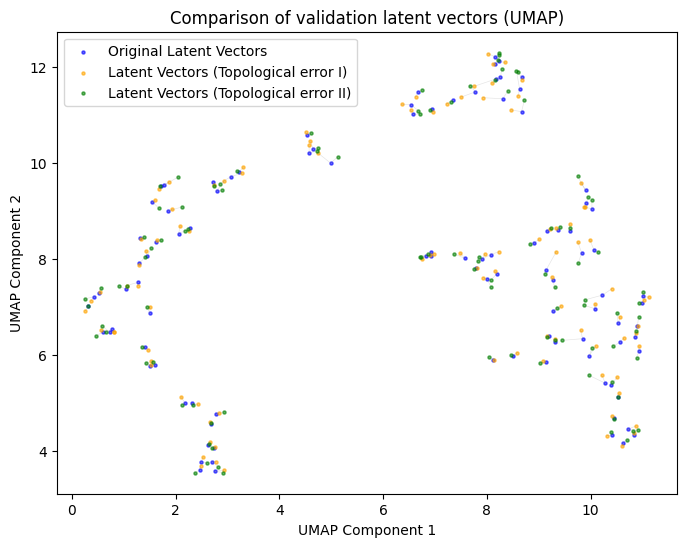

In [10]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors (Topological error I)')
plt.scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='green', alpha=0.6, label='Latent Vectors (Topological error II)')
plt.title('Comparison of validation latent vectors (UMAP)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

for i in range(100):
    plt.plot([all_val_latent_vectors_umap[i, 0], all_val_latent_vectors_umap[i + 100, 0]], 
             [all_val_latent_vectors_umap[i, 1], all_val_latent_vectors_umap[i + 100, 1]], 
             c='gray', alpha=0.2, linewidth=0.5)
    plt.plot([all_val_latent_vectors_umap[i, 0], all_val_latent_vectors_umap[i + 200, 0]],
             [all_val_latent_vectors_umap[i, 1], all_val_latent_vectors_umap[i + 200, 1]],
              c='gray', alpha=0.2, linewidth=0.5)

plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


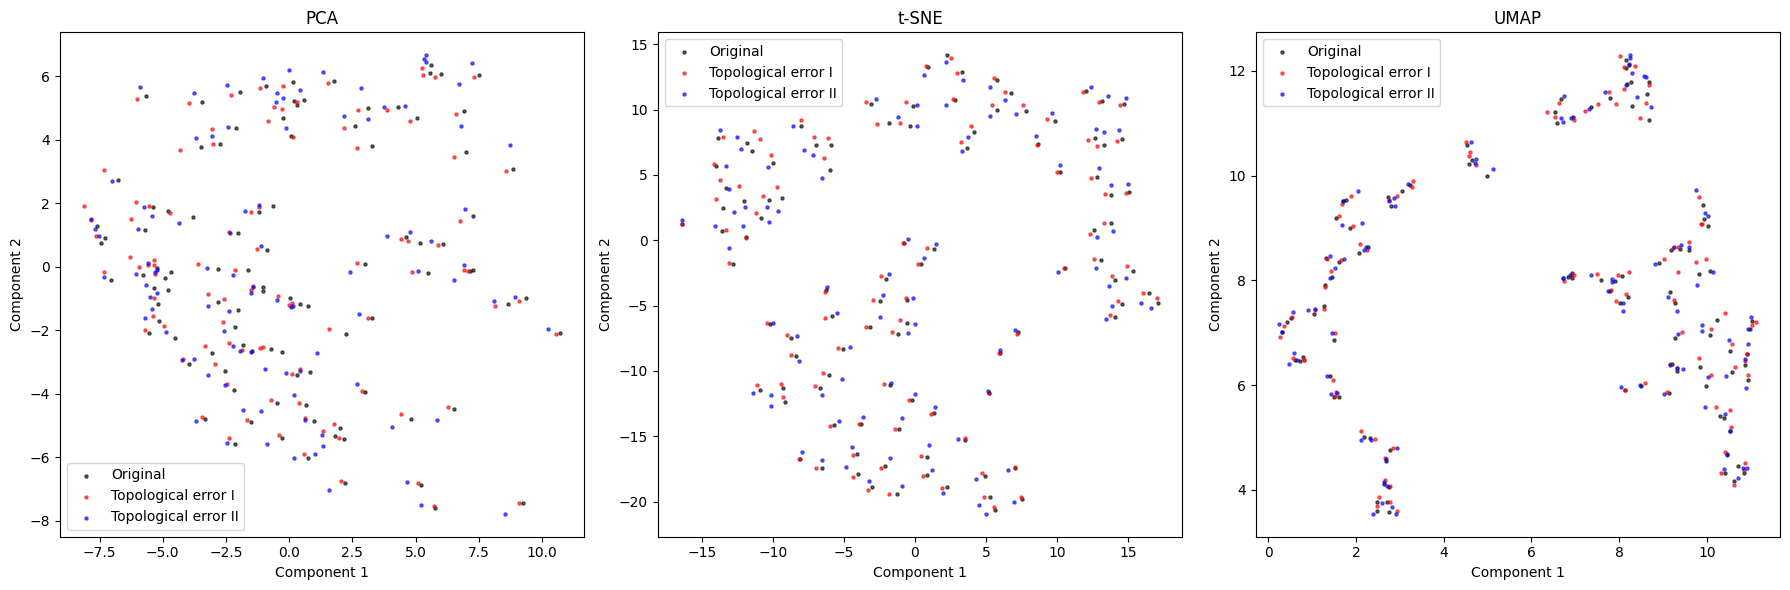

In [11]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

axes[0].scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='black', alpha=0.6, label='Original')
axes[0].scatter(all_val_latent_vectors_pca[100:200, 0], all_val_latent_vectors_pca[100:200, 1], s=5, c='red', alpha=0.6, label='Topological error I')
axes[0].scatter(all_val_latent_vectors_pca[200:300, 0], all_val_latent_vectors_pca[200:300, 1], s=5, c='blue', alpha=0.6, label='Topological error II')
axes[0].set_title('PCA')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

axes[1].scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='black', alpha=0.6, label='Original')
axes[1].scatter(all_val_latent_vectors_tsne[100:200, 0], all_val_latent_vectors_tsne[100:200, 1], s=5, c='red', alpha=0.6, label='Topological error I')
axes[1].scatter(all_val_latent_vectors_tsne[200:300, 0], all_val_latent_vectors_tsne[200:300, 1], s=5, c='blue', alpha=0.6, label='Topological error II')
axes[1].set_title('t-SNE')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

axes[2].scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='black', alpha=0.6, label='Original')
axes[2].scatter(all_val_latent_vectors_umap[100:200, 0], all_val_latent_vectors_umap[100:200, 1], s=5, c='red', alpha=0.6, label='Topological error I')
axes[2].scatter(all_val_latent_vectors_umap[200:300, 0], all_val_latent_vectors_umap[200:300, 1], s=5, c='blue', alpha=0.6, label='Topological error II')
axes[2].set_title('UMAP')
axes[2].set_xlabel('Component 1')
axes[2].set_ylabel('Component 2')

for ax in axes:
    ax.legend()
    
plt.tight_layout()
plt.show()


'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


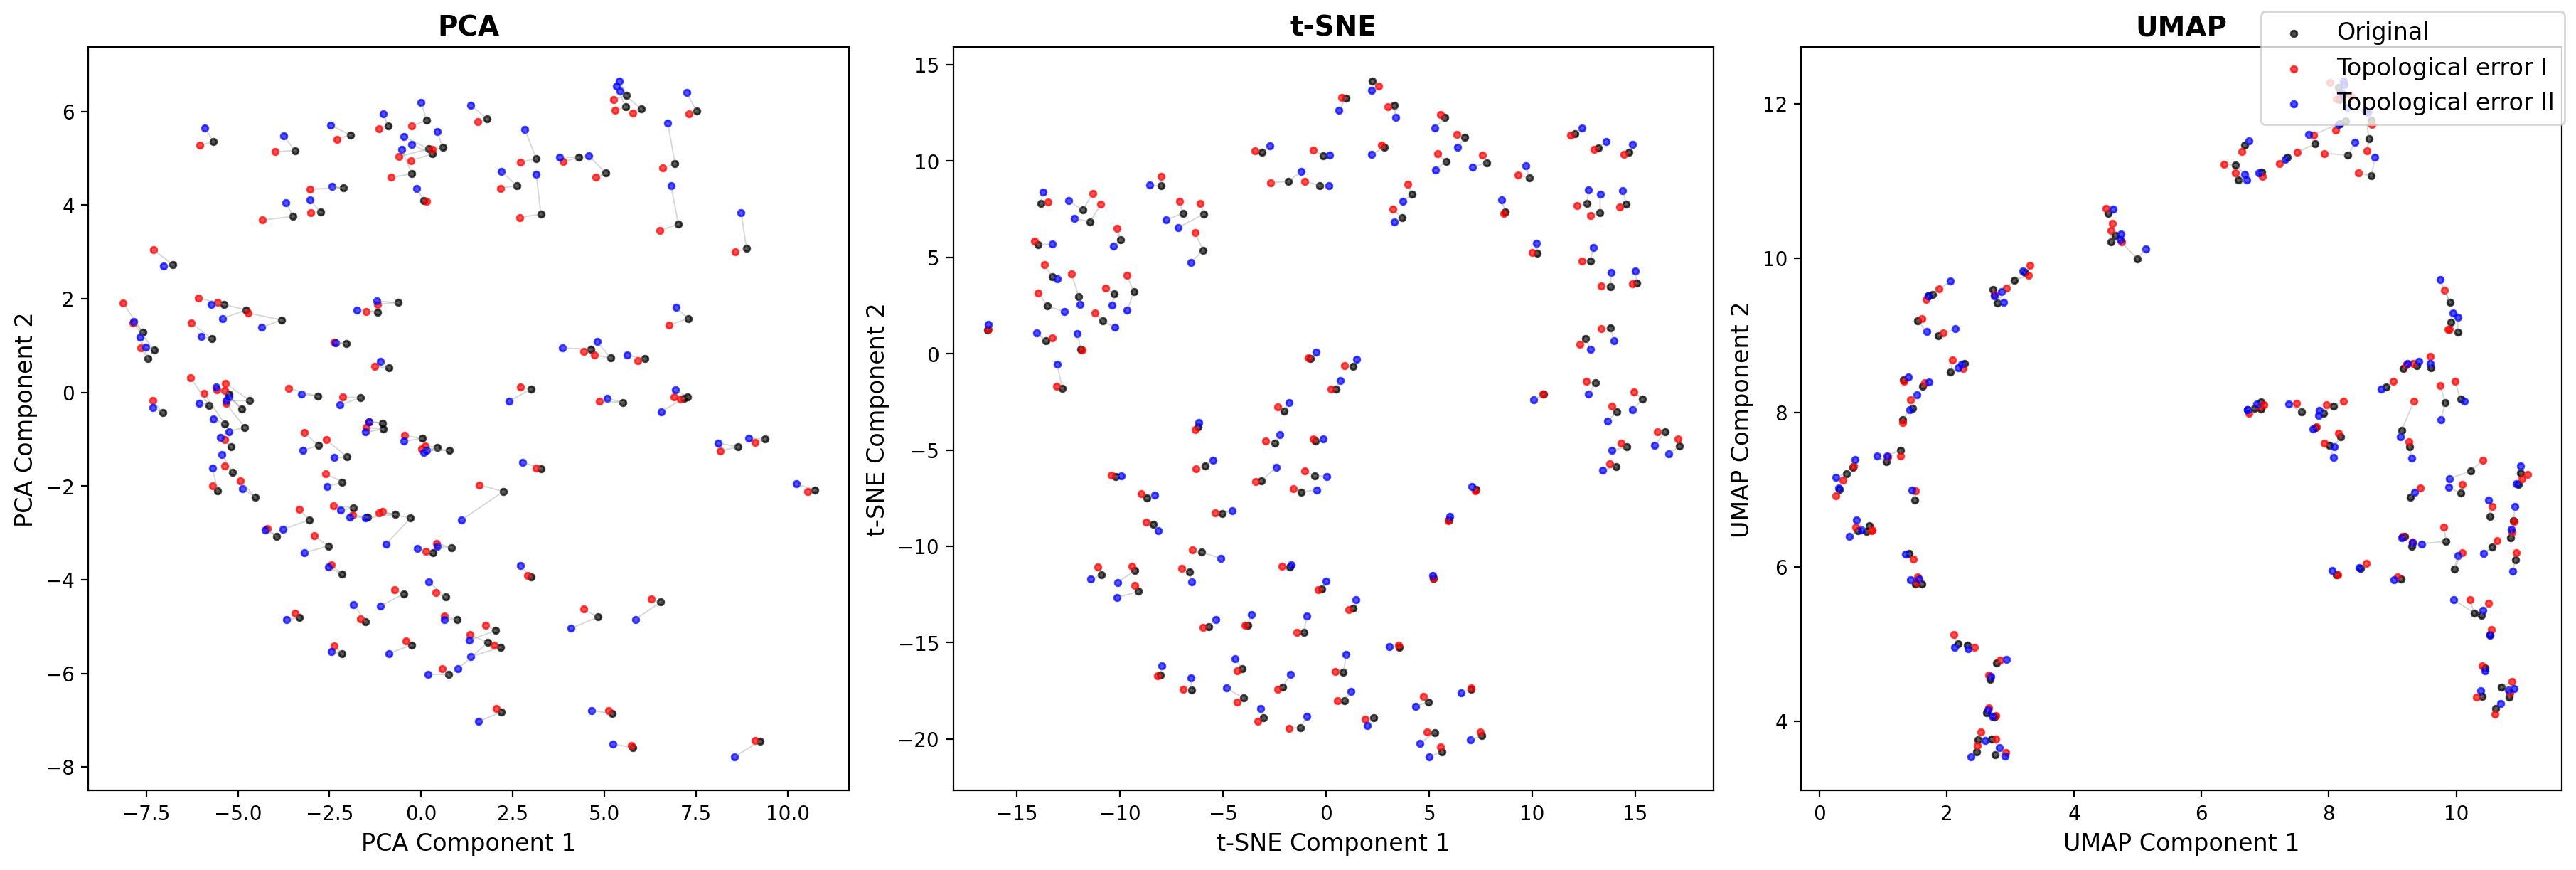

In [12]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200, constrained_layout=True)

def plot_scatter(ax, data, title, xlabel, ylabel):
    ax.scatter(data[:100, 0], data[:100, 1], s=10, c='black', alpha=0.7, label='Original')
    ax.scatter(data[100:200, 0], data[100:200, 1], s=10, c='red', alpha=0.7, label='Topological error I')
    ax.scatter(data[200:300, 0], data[200:300, 1], s=10, c='blue', alpha=0.7, label='Topological error II')
    
    for i in range(100):
        ax.plot([data[i, 0], data[i + 100, 0]], [data[i, 1], data[i + 100, 1]], c='gray', alpha=0.3, linewidth=0.7)
        ax.plot([data[i, 0], data[i + 200, 0]], [data[i, 1], data[i + 200, 1]], c='gray', alpha=0.3, linewidth=0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

plot_scatter(axes[0], all_val_latent_vectors_pca, 'PCA', 'PCA Component 1', 'PCA Component 2')
plot_scatter(axes[1], all_val_latent_vectors_tsne, 't-SNE', 't-SNE Component 1', 't-SNE Component 2')
plot_scatter(axes[2], all_val_latent_vectors_umap, 'UMAP', 'UMAP Component 1', 'UMAP Component 2')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.show()

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


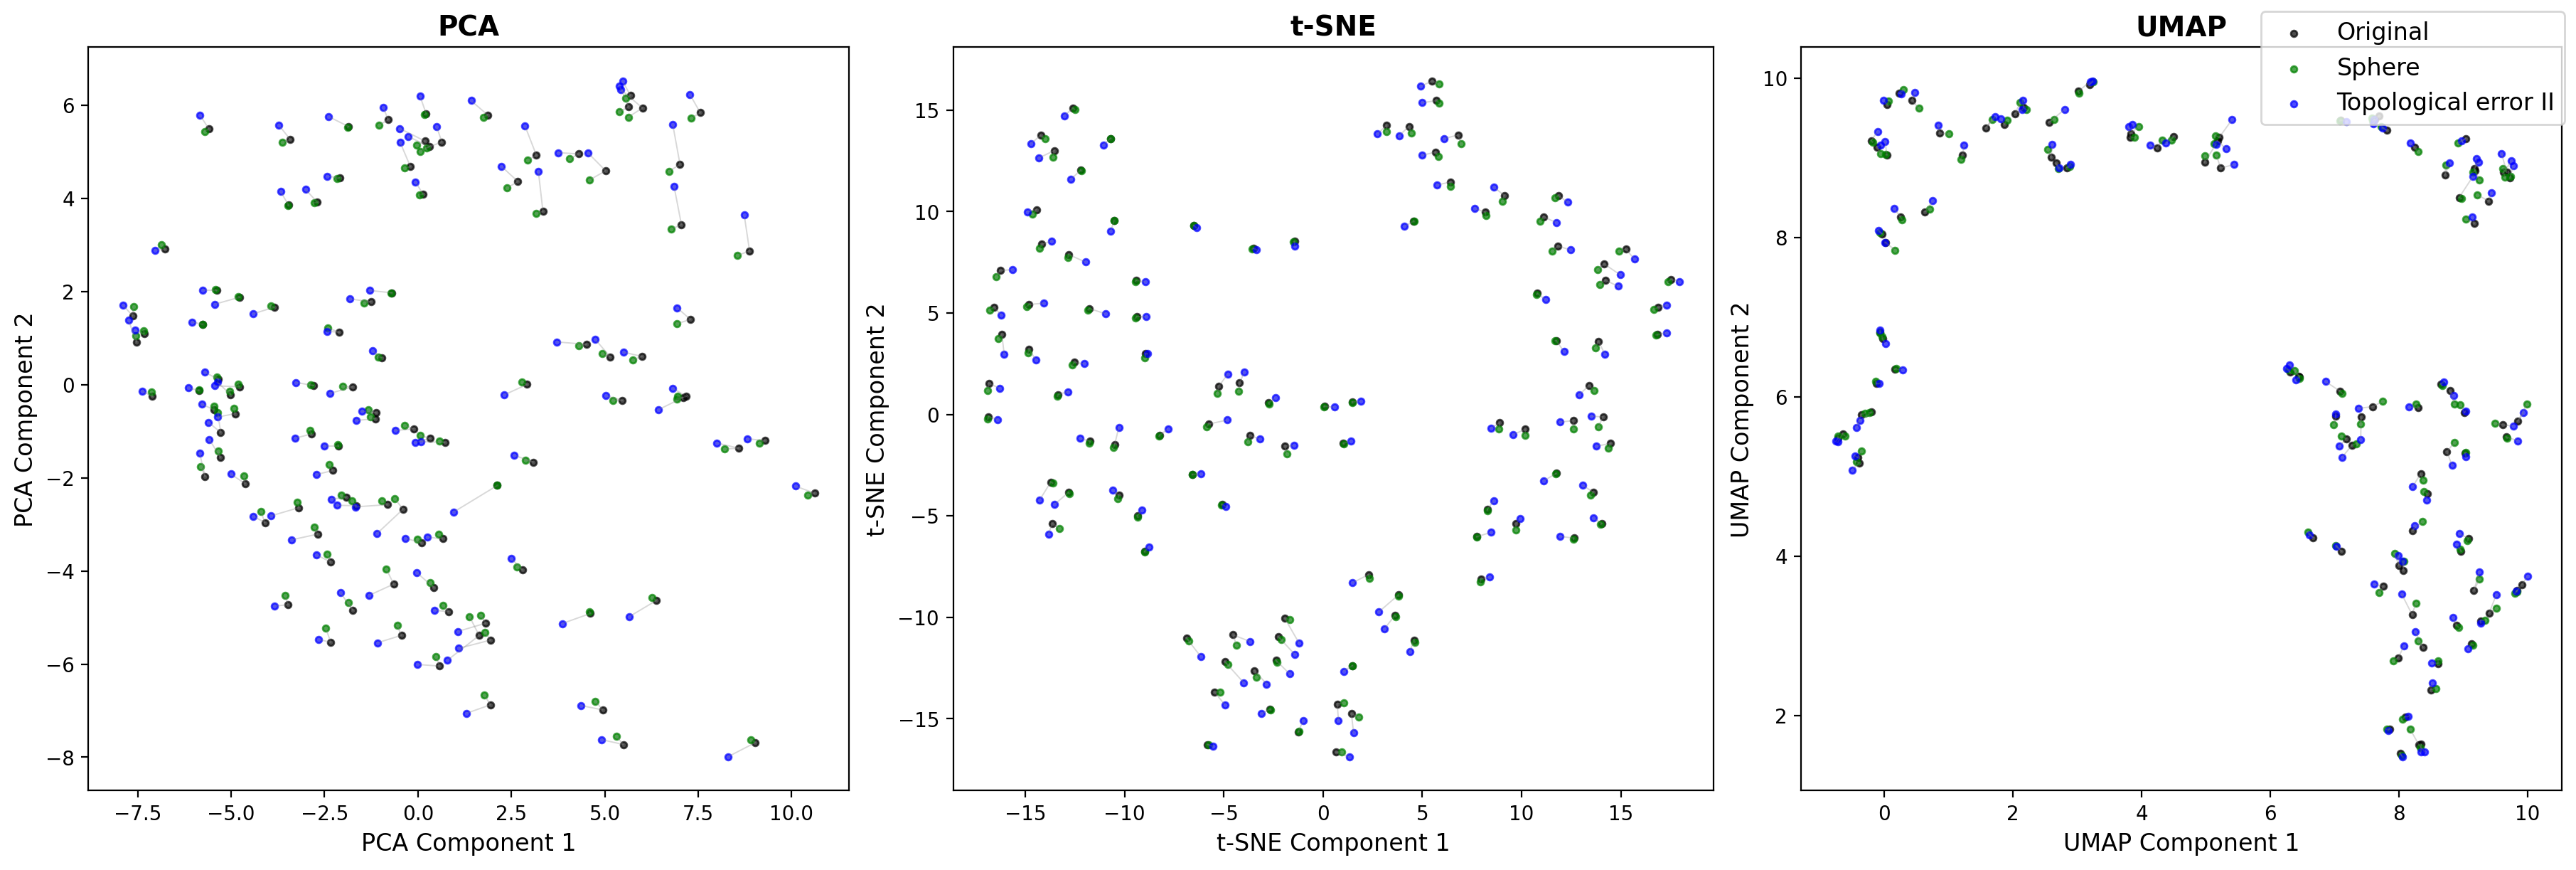

In [13]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200, constrained_layout=True)

def plot_scatter(ax, data, title, xlabel, ylabel):
    ax.scatter(data[:100, 0], data[:100, 1], s=10, c='black', alpha=0.7, label='Original')
    ax.scatter(data[100:200, 0], data[100:200, 1], s=10, c='green', alpha=0.7, label='Sphere')
    ax.scatter(data[200:300, 0], data[200:300, 1], s=10, c='blue', alpha=0.7, label='Topological error II')
    
    for i in range(100):
        ax.plot([data[i, 0], data[i + 100, 0]], [data[i, 1], data[i + 100, 1]], c='gray', alpha=0.3, linewidth=0.7)
        ax.plot([data[i, 0], data[i + 200, 0]], [data[i, 1], data[i + 200, 1]], c='gray', alpha=0.3, linewidth=0.7)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

plot_scatter(axes[0], all_val_latent_vectors_pca, 'PCA', 'PCA Component 1', 'PCA Component 2')
plot_scatter(axes[1], all_val_latent_vectors_tsne, 't-SNE', 't-SNE Component 1', 't-SNE Component 2')
plot_scatter(axes[2], all_val_latent_vectors_umap, 'UMAP', 'UMAP Component 1', 'UMAP Component 2')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.show()

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


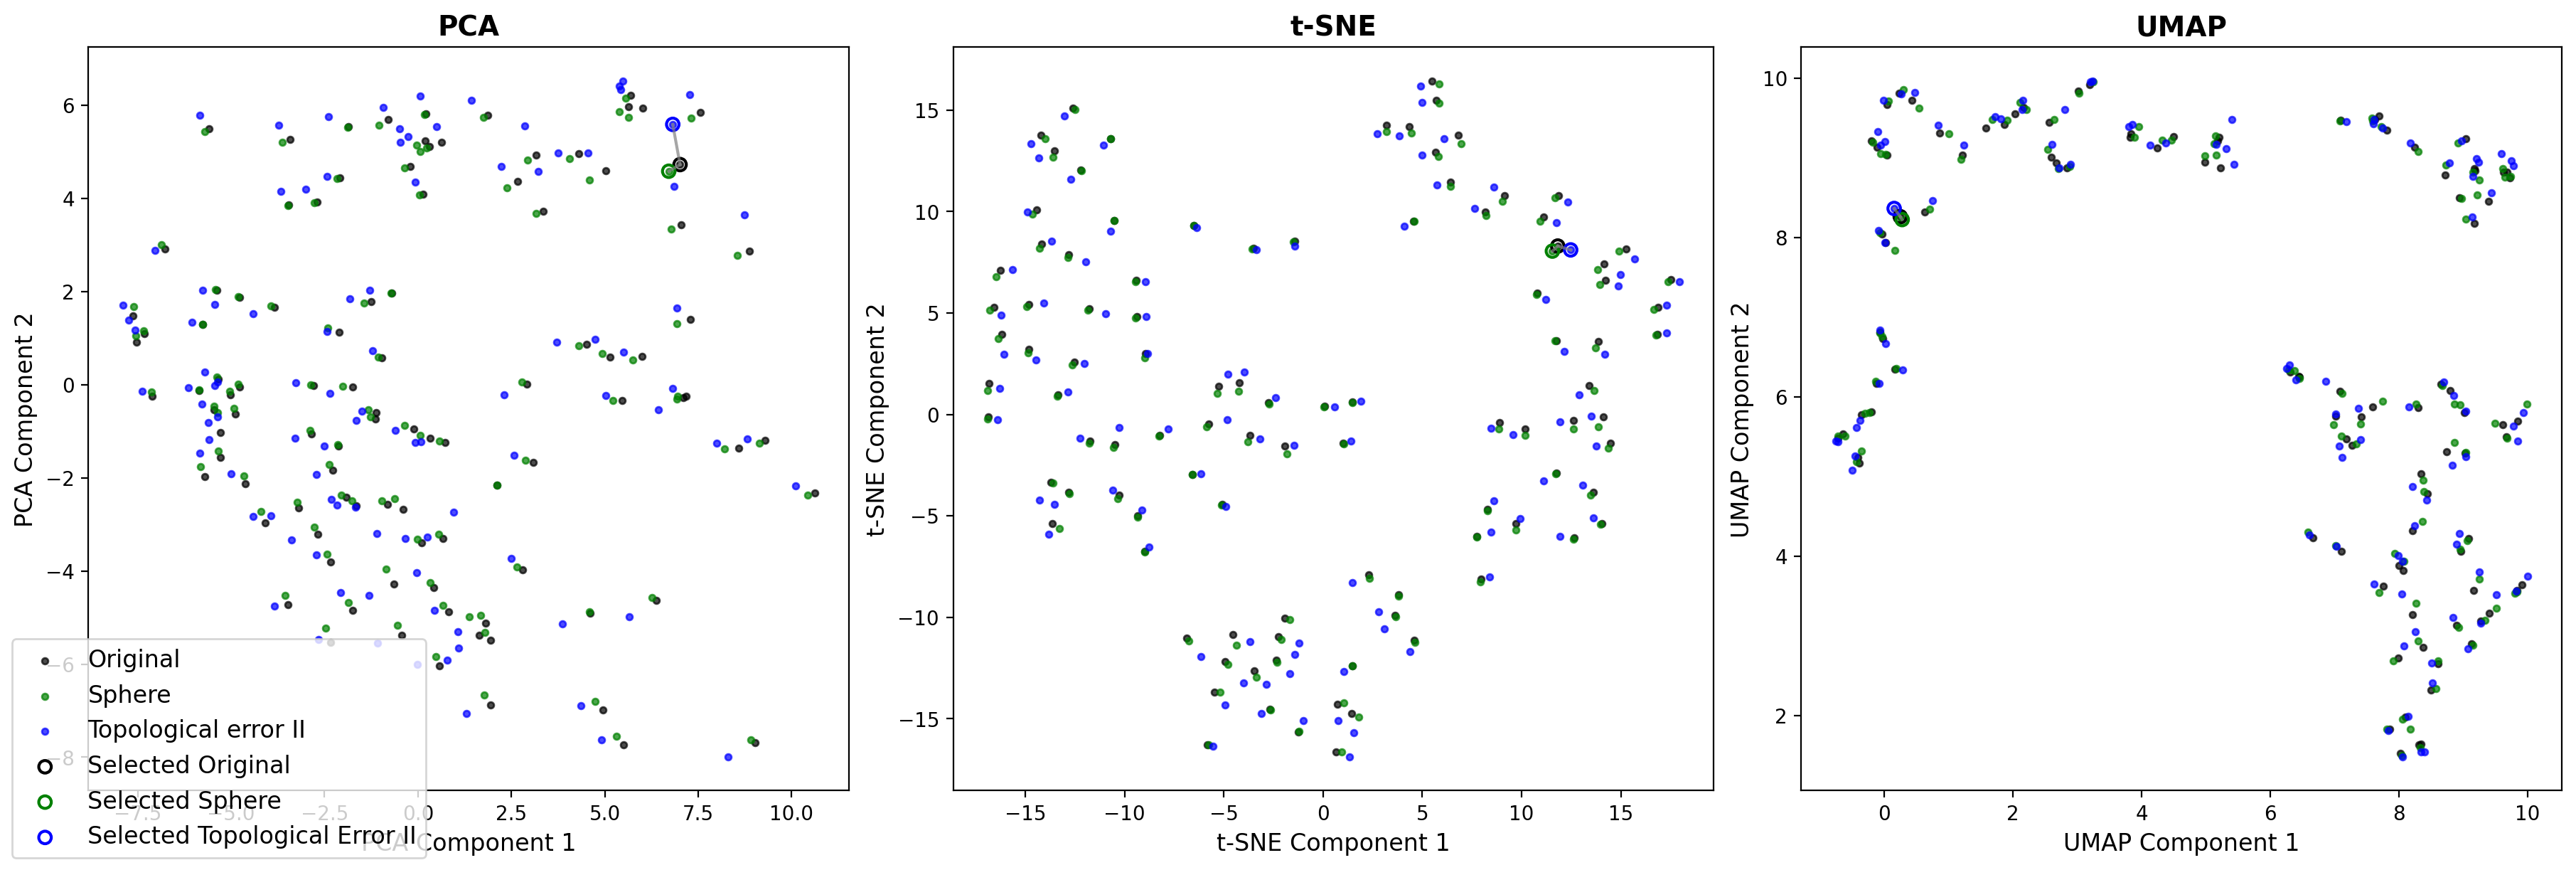

In [14]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

np.random.seed(40)
random_index = np.random.randint(0, 100) 

def plot_scatter(ax, data, title, xlabel, ylabel):
    ax.scatter(data[:100, 0], data[:100, 1], s=10, c='black', alpha=0.7, label='Original')
    ax.scatter(data[100:200, 0], data[100:200, 1], s=10, c='green', alpha=0.7, label='Sphere')
    ax.scatter(data[200:300, 0], data[200:300, 1], s=10, c='blue', alpha=0.7, label='Topological error II')

    ax.plot([data[random_index, 0], data[random_index + 100, 0]], 
            [data[random_index, 1], data[random_index + 100, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)
    
    ax.plot([data[random_index, 0], data[random_index + 200, 0]], 
            [data[random_index, 1], data[random_index + 200, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)

    ax.scatter(data[random_index, 0], data[random_index, 1], s=40, facecolors='none', edgecolors='black', linewidth=1.5, label='Selected Original')
    ax.scatter(data[random_index + 100, 0], data[random_index + 100, 1], s=40, facecolors='none', edgecolors='green', linewidth=1.5, label='Selected Sphere')
    ax.scatter(data[random_index + 200, 0], data[random_index + 200, 1], s=40, facecolors='none', edgecolors='blue', linewidth=1.5, label='Selected Topological Error II')

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=200, constrained_layout=True)

plot_scatter(axes[0], all_val_latent_vectors_pca, 'PCA', 'PCA Component 1', 'PCA Component 2')
plot_scatter(axes[1], all_val_latent_vectors_tsne, 't-SNE', 't-SNE Component 1', 't-SNE Component 2')
plot_scatter(axes[2], all_val_latent_vectors_umap, 'UMAP', 'UMAP Component 1', 'UMAP Component 2')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left', fontsize=12) 

plt.show()

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


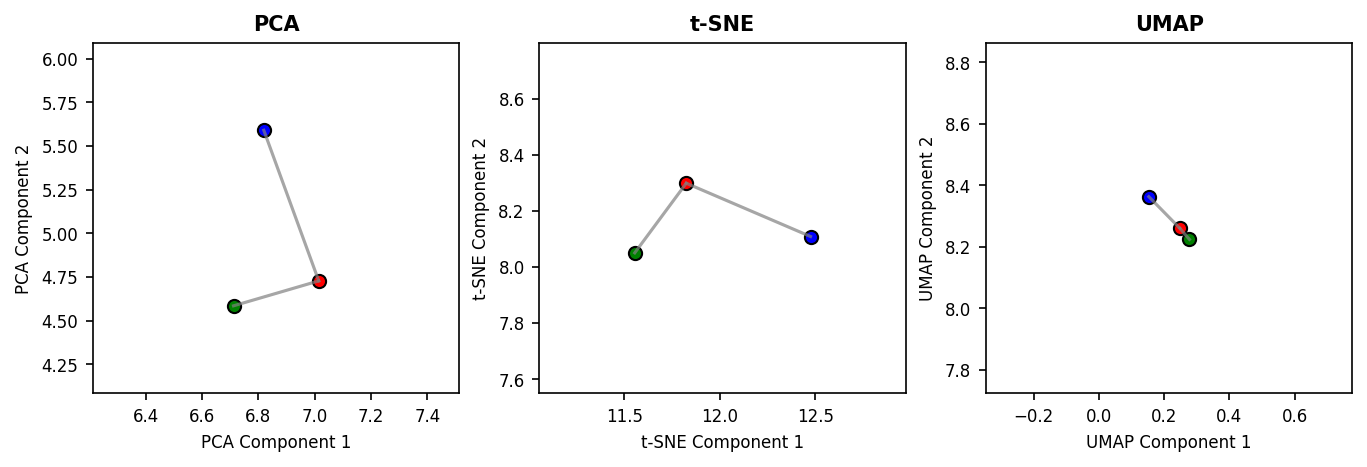

In [15]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

np.random.seed(40)
random_index = np.random.randint(0, 100) 

def plot_zoomed(ax, data, title, xlabel, ylabel):
    selected_points = np.array([
        data[random_index],         # Original
        data[random_index + 100],   # Sphere
        data[random_index + 200]    # Topological Error II
    ])

    ax.scatter(selected_points[0, 0], selected_points[0, 1], s=40, c='red', edgecolors='black', label='Original')
    ax.scatter(selected_points[1, 0], selected_points[1, 1], s=40, c='green', edgecolors='black', label='Sphere')
    ax.scatter(selected_points[2, 0], selected_points[2, 1], s=40, c='blue', edgecolors='black', label='Topological Error II')

    ax.plot([selected_points[0, 0], selected_points[1, 0]], 
            [selected_points[0, 1], selected_points[1, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)
    
    ax.plot([selected_points[0, 0], selected_points[2, 0]], 
            [selected_points[0, 1], selected_points[2, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)

    ax.set_xlim(selected_points[:, 0].min() - 0.5, selected_points[:, 0].max() + 0.5)
    ax.set_ylim(selected_points[:, 1].min() - 0.5, selected_points[:, 1].max() + 0.5)

    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150, constrained_layout=True)

plot_zoomed(axes[0], all_val_latent_vectors_pca, 'PCA', 'PCA Component 1', 'PCA Component 2')
plot_zoomed(axes[1], all_val_latent_vectors_tsne, 't-SNE', 't-SNE Component 1', 't-SNE Component 2')
plot_zoomed(axes[2], all_val_latent_vectors_umap, 'UMAP', 'UMAP Component 1', 'UMAP Component 2')

plt.show()

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


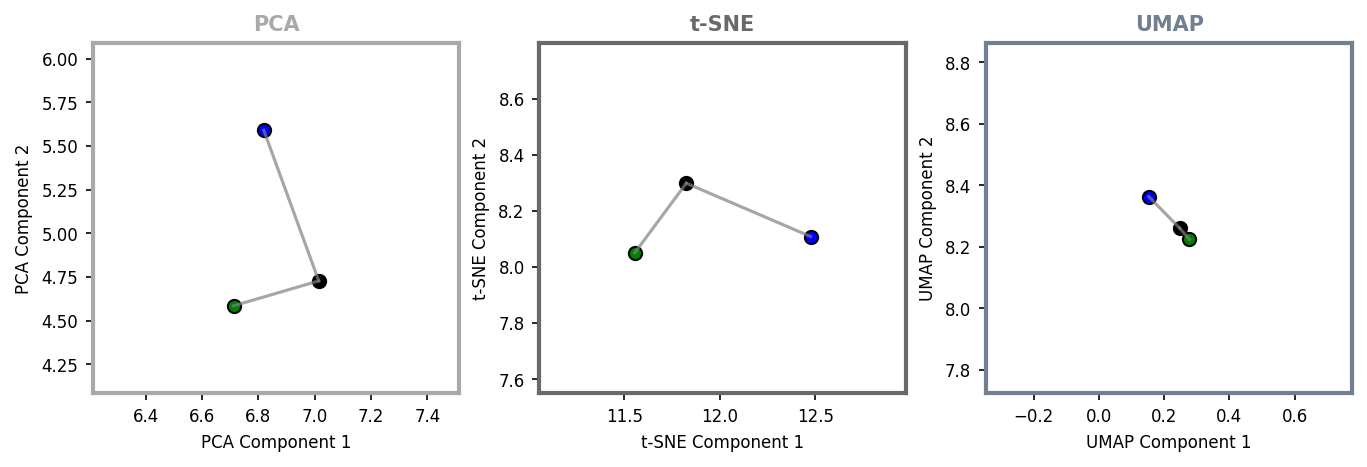

In [18]:
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere, val_latent_vectors_sphere_3], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

np.random.seed(40)
random_index = np.random.randint(0, 100)

def plot_zoomed(ax, data, title, xlabel, ylabel, border_color):
    selected_points = np.array([
        data[random_index],         
        data[random_index + 100],  
        data[random_index + 200]  
    ])

    ax.scatter(selected_points[0, 0], selected_points[0, 1], s=40, c='black', edgecolors='black', label='Original')
    ax.scatter(selected_points[1, 0], selected_points[1, 1], s=40, c='green', edgecolors='black', label='Sphere')
    ax.scatter(selected_points[2, 0], selected_points[2, 1], s=40, c='blue', edgecolors='black', label='Topological Error II')

    ax.plot([selected_points[0, 0], selected_points[1, 0]], 
            [selected_points[0, 1], selected_points[1, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)
    
    ax.plot([selected_points[0, 0], selected_points[2, 0]], 
            [selected_points[0, 1], selected_points[2, 1]], 
            c='gray', alpha=0.7, linewidth=1.5)

    ax.set_xlim(selected_points[:, 0].min() - 0.5, selected_points[:, 0].max() + 0.5)
    ax.set_ylim(selected_points[:, 1].min() - 0.5, selected_points[:, 1].max() + 0.5)

    for spine in ax.spines.values():
        spine.set_color(border_color)
        spine.set_linewidth(2)

    ax.set_title(title, fontsize=10, fontweight='bold', color=border_color)
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150, constrained_layout=True)

plot_zoomed(axes[0], all_val_latent_vectors_pca, 'PCA', 'PCA Component 1', 'PCA Component 2', 'darkgray') 
plot_zoomed(axes[1], all_val_latent_vectors_tsne, 't-SNE', 't-SNE Component 1', 't-SNE Component 2', 'dimgray')  
plot_zoomed(axes[2], all_val_latent_vectors_umap, 'UMAP', 'UMAP Component 1', 'UMAP Component 2', 'slategray') 

plt.show()
